In [238]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from ipywidgets import FloatSlider
import copy
import math
import pywt
import os

In [78]:
img1 = cv2.imread('data_eyes/001.png')
img2 = cv2.imread('data_eyes/002.png')

In [79]:
alpha = 0.5
def calcWeights(v, handles):
    weights = []
    for handle in handles:
        if np.linalg.norm(v - handle) != 0:
            weights.append(1/(np.linalg.norm(v - handle)**(2*alpha)))
        else:
            weights.append(1/(0.00001**(2*alpha)))
    return np.array(weights)

def centroid(weights, handles):
    sumW = 0
    sumWH = 0
    for w, h in zip(weights, handles):
        sumW += w
        sumWH += w * h
    return sumWH / sumW

def A_j(v, handlesOrg):
    A = []
    weights = calcWeights(v, handlesOrg)
    centOrg = centroid(weights, handlesOrg)
    Bmat = [[0, 0], [0, 0]]
    for hO, w in zip(handlesOrg, weights):
        Bmat += (hO - centOrg).T @ (w * (hO - centOrg))
    Bmat = (v - centOrg) @ np.linalg.inv(Bmat)
    
    for hO, w in zip(handlesOrg, weights):
        A.append(Bmat @ (w * (hO - centOrg).T))
        
    return np.array(A)

def mls(weights, A, handlesDfm):
    centDfm = centroid(weights, handlesDfm)
    newPos = np.copy(centDfm)
    for Aj, hD in zip(A, handlesDfm):
        newPos += Aj * hD
        
    return newPos

In [80]:
class mesh:
    def __init__(self, divX: int, divY: int, width, height, img):
        self.divX = divX
        self.divY = divY
        self.width = width
        self.height = height
        self.vartices = np.zeros(((divY+1)*(divX+1), 2))
        meshW = width / divX
        meshH = height / divY
        for i in range(divY+1):
            for j in range(divX+1):
                self.vartices[i*(divY+1) + j] = np.array([meshW*j, meshH*i])
        self.varticesDfm = np.copy(self.vartices)
        self.triangles = np.zeros((divY*divX*2, 3))
        for i in range(divY):
            for j in range(divX):
                self.triangles[(i*(divY) + j)*2] = [i*(divY)+j+i, i*(divY)+j+i+divY+1, i*(divY)+j+i+divY+2]
                self.triangles[(i*(divY) + j)*2+1] = [i*(divY)+j+i, i*(divY)+j+i+divY+2, i*(divY)+j+i+1]
        self.triangles = self.triangles.astype(np.int64)
        self.adjacentTriangles = []
        for i in range(len(self.vartices)):
            self.adjacentTriangles.append([])
        for i in range(len(self.triangles)):
            for j in range(3):
                if not(i in self.adjacentTriangles[self.triangles[i][j]]):
                    self.adjacentTriangles[self.triangles[i][j]].append(i)
                    
        self.texture = img
        self.image = cv2.resize(self.texture, (width, height))
        
    def deform(self):
        maskSum = np.zeros_like(self.image)
        newImg = np.zeros_like(self.image)
        for triangle in self.triangles:
            trianglePosOrg = np.array([self.vartices[triangle[0]], self.vartices[triangle[1]], self.vartices[triangle[2]]], dtype=np.float32)
            trianglePosDfm = np.array([self.varticesDfm[triangle[0]], self.varticesDfm[triangle[1]], self.varticesDfm[triangle[2]]], dtype=np.float32)
            affinMat = cv2.getAffineTransform(trianglePosOrg, trianglePosDfm)
            affinImg = cv2.warpAffine(self.image, affinMat, (self.width, self.height))

            black = np.zeros_like(self.image)
            mask = cv2.fillConvexPoly(black, trianglePosDfm.astype(np.int32), (255, 255, 255))        
            mask = mask / 255

            maskedImg = affinImg * mask
            newImg = newImg + maskedImg * (1 - maskSum)
            maskSum = np.clip(maskSum + mask, 0, 1) 
            
        #newImg = (newImg + self.image * (1 - maskSum)).astype(np.uint8)
        newImg = (newImg).astype(np.uint8)
        
        return newImg
    
    def setHandlesOrg(self, handles):
        self.handlesOrg = handles
        self.weightsArr = []
        self.AsArr = []
        for v in self.vartices:
            self.weightsArr.append(calcWeights(np.array([v]), handles))
            self.AsArr.append(A_j(np.array([v]), handles))
        self.weightsArr = np.array(self.weightsArr)
        self.AsArr = np.array(self.AsArr)
        
    def setHandlesDfm(self, handles):
        self.handlesDfm = handles
        
    def applyHandles(self):
        i = 0
        for w, A in zip(self.weightsArr, self.AsArr):
            self.varticesDfm[i] = mls(w, A, self.handlesDfm)[0]
            i+=1

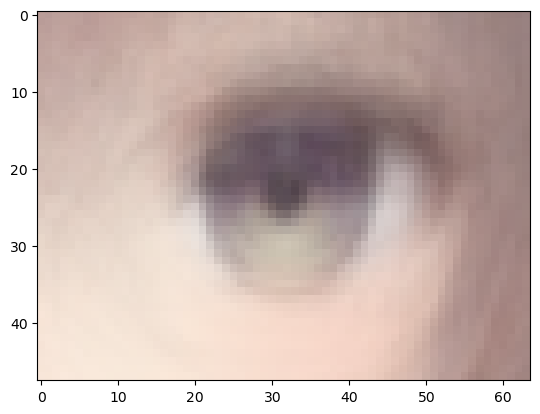

In [5]:
dataNum = 143

sum = np.zeros(48*64*3)
eye_data = np.empty((dataNum, 48*64*3))
for i in range(dataNum):
    img = cv2.imread('data_eyes/'+ str(i+1).zfill(3)+ '.png')
    #img = cv2.imread('data_eyes/001.png')
    sum += img.reshape(48*64*3)
    eye_data[i] = img.reshape(48*64*3)
    
sum = sum // dataNum
new_img = sum.reshape(48, 64, 3)
avg_eye_vec = sum
new_img = new_img.astype(np.uint8)

plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)) # OpenCV は色がGBR順なのでRGB順に並べ替える
plt.show()

In [41]:
#固有値計算（時間かかります）
eye_data_center = eye_data - avg_eye_vec
print(eye_data_center, eye_data)
eye_data_center_T = eye_data_center.T
#print(eye_data_T.shape)
cov_mat = np.cov(eye_data_center_T)
eye_eig = np.linalg.eig(cov_mat)

[[ -49.  -97. -133. ...   42.   48.   57.]
 [ -12.   -2.   14. ...  -48.  -60.  -12.]
 [  65.   76.   67. ...   17.   46.   47.]
 ...
 [  86.   86.   68. ...  -52.  -69.  -31.]
 [  92.   80.   66. ...   91.   74.   77.]
 [  16.   37.   16. ...   80.   41.   11.]] [[103.  60.  53. ... 171. 181. 218.]
 [140. 155. 200. ...  81.  73. 149.]
 [217. 233. 253. ... 146. 179. 208.]
 ...
 [238. 243. 254. ...  77.  64. 130.]
 [244. 237. 252. ... 220. 207. 238.]
 [168. 194. 202. ... 209. 174. 172.]]


In [7]:
np.save('saves/eye_eig_val_1', eye_eig[0].real)
np.save('saves/eye_eig_vec_1', eye_eig[1].real.T)

NameError: name 'eye_eig' is not defined

In [14]:
eye_eig_val = np.load('saves/eye_eig_val_1.npy')
eye_eig_vec = np.load('saves/eye_eig_vec_1.npy')
max_indices = np.argsort(eye_eig_val)[::-1]
print(max_indices)

[  0   1   2 ... 148 149 144]


In [8]:
def func(x1, x2, x3, x4):
    new_eye = avg_eye_vec + x1 * eye_eig_vec[max_indices[0]] + x2 * eye_eig_vec[max_indices[1]] + x3 * eye_eig_vec[max_indices[2]] + x4 * eye_eig_vec[max_indices[3]]
    new_eye = new_eye.astype(np.uint8)
    new_eye = new_eye.reshape(48, 64, 3)

    plt.imshow(cv2.cvtColor(new_eye, cv2.COLOR_BGR2RGB)) # OpenCV は色がGBR順なのでRGB順に並べ替える
    plt.show()

interact(func, x1=(-10000, 10000, 1000), x2=(-10000, 10000, 1000), x3=(-10000, 10000, 1000), x4=(-10000, 10000, 1000))

interactive(children=(IntSlider(value=0, description='x1', max=10000, min=-10000, step=1000), IntSlider(value=…

<function __main__.func(x1, x2, x3, x4)>

In [81]:
def detectP(url):
    img = cv2.imread(url)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hues = [0, 45, 90, 135]
    points = []
    
    for hue in hues:
        hsv_min = np.array([hue,64,0])
        hsv_max = np.array([hue,255,255])
        mask = cv2.inRange(hsv, hsv_min, hsv_max)

        contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE ) 

        cnt = contours[0]
        M = cv2.moments(cnt)
        cx = M['m10']/M['m00']
        cy = M['m01']/M['m00']
        
        points.append([[cx, cy]])
        
    return np.array(points)

print(detectP('data_eyes_p/001_p.png'))

[[[31.9047619 17.0952381]]

 [[51.        21.       ]]

 [[31.9047619 31.9047619]]

 [[15.0952381 24.0952381]]]


38


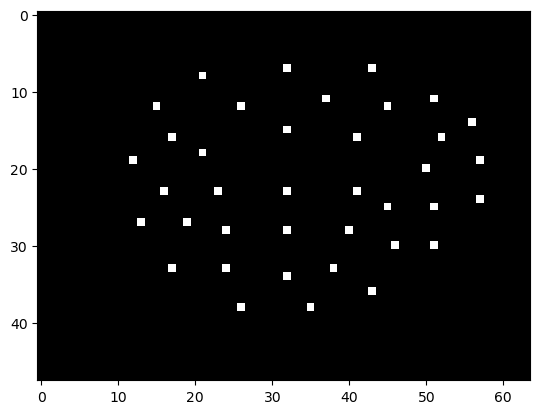

(59, 3, 2) (38, 2)
[[ 0.  3.  4.]
 [ 3.  0.  1.]
 [ 1.  6.  5.]
 [ 2.  0.  4.]
 [ 8.  4. 10.]
 [ 4.  8.  2.]
 [ 3.  1.  5.]
 [ 5. 11.  3.]
 [11.  5.  9.]
 [ 4.  3. 11.]
 [ 7.  2.  8.]
 [ 4. 11. 10.]
 [ 5.  6. 12.]
 [ 8. 16.  7.]
 [16.  8. 14.]
 [ 9.  5. 12.]
 [ 8. 10. 14.]
 [18. 11.  9.]
 [11. 18. 10.]
 [10. 18. 17.]
 [10. 17. 14.]
 [19.  9. 12.]
 [ 9. 19. 18.]
 [12.  6. 13.]
 [12. 13. 20.]
 [23. 15. 21.]
 [16. 21. 15.]
 [21. 16. 14.]
 [15.  7. 16.]
 [21. 14. 17.]
 [27. 17. 18.]
 [17. 27. 21.]
 [19. 12. 20.]
 [19. 24. 29.]
 [24. 19. 20.]
 [18. 19. 29.]
 [24. 20. 26.]
 [20. 13. 22.]
 [21. 27. 30.]
 [20. 22. 26.]
 [23. 21. 25.]
 [28. 23. 25.]
 [25. 21. 30.]
 [27. 18. 29.]
 [25. 30. 33.]
 [22. 32. 26.]
 [24. 26. 35.]
 [29. 24. 31.]
 [27. 29. 34.]
 [28. 25. 33.]
 [30. 27. 34.]
 [31. 24. 35.]
 [29. 31. 37.]
 [30. 34. 36.]
 [34. 29. 37.]
 [31. 35. 37.]
 [35. 26. 32.]
 [33. 30. 36.]
 [36. 34. 37.]] [[[35. 38.]
  [32. 34.]
  [38. 33.]]

 [[32. 34.]
  [35. 38.]
  [26. 38.]]

 [[26. 38.]
  [17. 

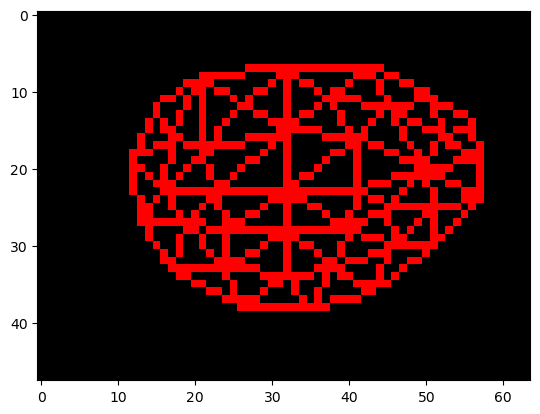

In [82]:
# メッシュ形成
img = cv2.imread('data/eye_mesh5.png')
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
hues = [0]
points = []

hsv_min = np.array([0,64,0])
hsv_max = np.array([0,255,255])
mask = cv2.inRange(hsv, hsv_min, hsv_max)

contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE ) 

print(len(contours))


for cnt in contours:
    M = cv2.moments(cnt)
    cx = M['m10']/M['m00']
    cy = M['m01']/M['m00']

    points.append(np.array([cx, cy]))

points = np.array(points)

points = points.astype(np.uint8)

img = np.zeros((48, 64, 3), np.uint8)
for p in points:
    cv2.drawMarker(img, tuple(p), (255, 255, 255), markerType=cv2.MARKER_SQUARE, markerSize=1)
    
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # OpenCV は色がGBR順なのでRGB順に並べ替える
plt.show()

rect = (0, 0, 64, 48)

subdiv = cv2.Subdiv2D(rect)

for p in points:
    subdiv.insert((p[0], p[1]))
    
triangles = subdiv.getTriangleList()

pols = triangles.reshape(-1, 3, 2)

print(pols.shape, points.shape)

triangles_ind = np.zeros((len(triangles), 3))

for j in range(len(pols)):
    for i in range(3):
        for p in range(len(points)):
            if pols[j][i][0] == points[p][0] and pols[j][i][1] == points[p][1]:
                triangles_ind[j][i] = p

img_draw = img.copy()

print(triangles_ind, pols, points)

cv2.polylines(img_draw, pols.astype(int), True, (0, 0, 255), thickness=1)

plt.imshow(cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB)) # OpenCV は色がGBR順なのでRGB順に並べ替える
plt.show()

In [83]:
class mesh2:
    def __init__(self, width, height, img):
        self.width = width
        self.height = height
        self.vartices = np.copy(points.astype(np.float64))
        self.varticesDfm = np.copy(self.vartices)
        self.triangles = np.copy(triangles_ind.astype(np.int64))
                    
        self.texture = img
        self.image = cv2.resize(self.texture, (width, height))
        
    def deform(self):
        maskSum = np.zeros_like(self.image)
        newImg = np.zeros_like(self.image)
        for triangle in self.triangles:
            trianglePosOrg = np.array([self.vartices[triangle[0]], self.vartices[triangle[1]], self.vartices[triangle[2]]], dtype=np.float32)
            trianglePosDfm = np.array([self.varticesDfm[triangle[0]], self.varticesDfm[triangle[1]], self.varticesDfm[triangle[2]]], dtype=np.float32)
            affinMat = cv2.getAffineTransform(trianglePosOrg, trianglePosDfm)
            affinImg = cv2.warpAffine(self.image, affinMat, (self.width, self.height))

            black = np.zeros_like(self.image)
            mask = cv2.fillConvexPoly(black, trianglePosDfm.astype(np.int32), (255, 255, 255))        
            mask = mask / 255

            maskedImg = affinImg * mask
            newImg = newImg + maskedImg * (1 - maskSum)
            maskSum = np.clip(maskSum + mask, 0, 1) 
            
        #newImg = (newImg + self.image * (1 - maskSum)).astype(np.uint8)
        newImg = (newImg).astype(np.uint8)
        
        return newImg
    
    def setHandlesOrg(self, handles):
        self.handlesOrg = handles
        self.weightsArr = []
        self.AsArr = []
        
        tWArr = []
        tAArr = []
        
        for v in self.vartices:
            tWArr.append(calcWeights(np.array([v]), handlesAvg))
            tAArr.append(A_j(np.array([v]), handlesAvg))
        tWArr = np.array(tWArr)
        tAArr = np.array(tAArr)
        
        i = 0
        for w, A in zip(tWArr, tAArr):
            self.vartices[i] = mls(w, A, handles)[0]
            i+=1
            
        for v in self.vartices:
            self.weightsArr.append(calcWeights(np.array([v]), handles))
            self.AsArr.append(A_j(np.array([v]), handles))
        self.weightsArr = np.array(self.weightsArr)
        self.AsArr = np.array(self.AsArr)
        
    def setHandlesDfm(self, handles):
        self.handlesDfm = handles
        
    def applyHandles(self):
        i = 0
        for w, A in zip(self.weightsArr, self.AsArr):
            self.varticesDfm[i] = mls(w, A, self.handlesDfm)[0]
            i+=1

In [50]:
def test(i):
    
    if i == 84 or i == 122 or i == 123:
        print("no data")
    else:
        testMesh = tex = cv2.imread('data_eyes/'+ str(i+1).zfill(3)+ '.png')
        eyeMesh = mesh2(64,48, tex)

        handles = detectP('data_eyes_p/'+ str(i+1).zfill(3)+ '_p.png')
        handles2 = detectP('data_eyes_p2/'+ str(i+1).zfill(3)+ '_p2.png')
        handles3 = detectP('data_eyes_p3/'+ str(i+1).zfill(3)+ '_p3.png')

        handles = np.append(handles, handles2, axis=0)
        handles = np.append(handles, handles3, axis=0)
        handles = np.append(handles, np.array([[[32.5, 24.5]]]), axis=0)

        eyeMesh.setHandlesOrg(handles)
        eyeMesh.setHandlesDfm(handles)
        eyeMesh.applyHandles()
        a = eyeMesh.deform()
        
        for p in eyeMesh.vartices:
            cv2.drawMarker(a, tuple(p.astype(np.int64)), (0, 0, 255), markerType=cv2.MARKER_SQUARE, markerSize=1)

        plt.imshow(cv2.cvtColor(a, cv2.COLOR_BGR2RGB)) # OpenCV は色がGBR順なのでRGB順に並べ替える
        plt.show()
        
interact(test, i=(0, 142, 1))

interactive(children=(IntSlider(value=71, description='i', max=142), Output()), _dom_classes=('widget-interact…

<function __main__.test(i)>

In [158]:
# ハンドル平均
N = 143    # データの数
n = N - 3
H = 13     # ハンドルの数
handlesArr = []
handlesAvg = np.zeros((H,1,2))

dummy = detectP('data_eyes_p/001_p.png')
dummy2 = detectP('data_eyes_p2/001_p2.png')
dummy3 = detectP('data_eyes_p3/001_p3.png')

dummy = np.append(dummy, dummy2, axis=0)
dummy = np.append(dummy, dummy3, axis=0)
dummy = np.append(dummy, np.array([[[32.5, 24.5]]]), axis=0)

for i in range(N):
    
    if i == 84 or i == 122 or i == 123:
        handlesArr.append(dummy)
        continue
    
    handles = detectP('data_eyes_p/'+ str(i+1).zfill(3)+ '_p.png')
    handles2 = detectP('data_eyes_p2/'+ str(i+1).zfill(3)+ '_p2.png')
    handles3 = detectP('data_eyes_p3/'+ str(i+1).zfill(3)+ '_p3.png')
    
    handles = np.append(handles, handles2, axis=0)
    handles = np.append(handles, handles3, axis=0)
    handles = np.append(handles, np.array([[[32.5, 24.5]]]), axis=0)
    handlesAvg += handles
    handlesArr.append(handles)
    
handlesAvg = handlesAvg / n

print(len(handlesArr))

143


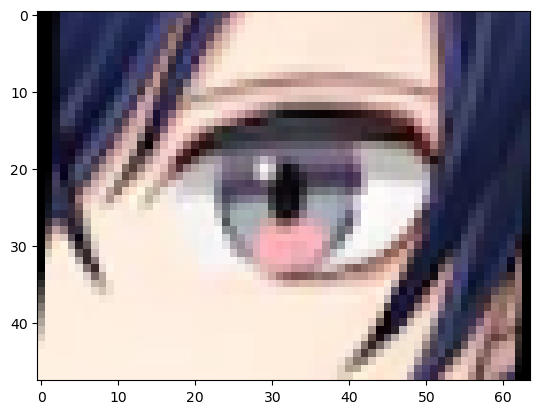

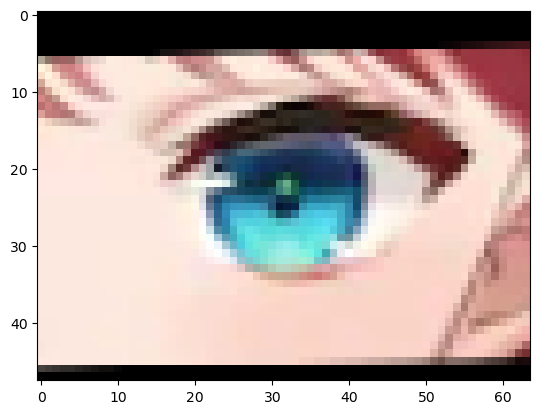

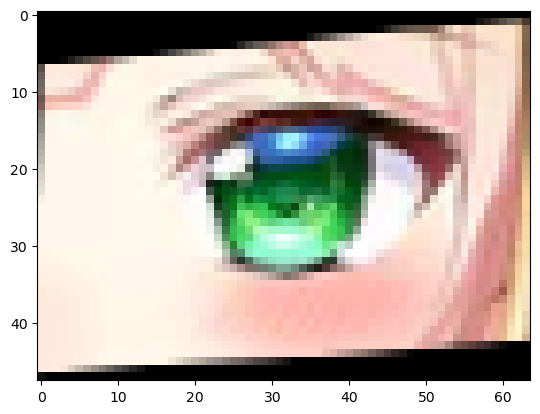

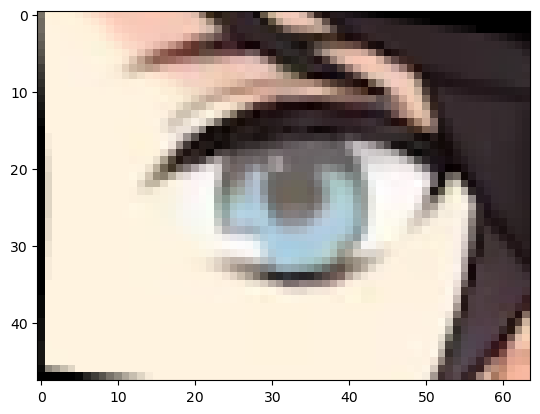

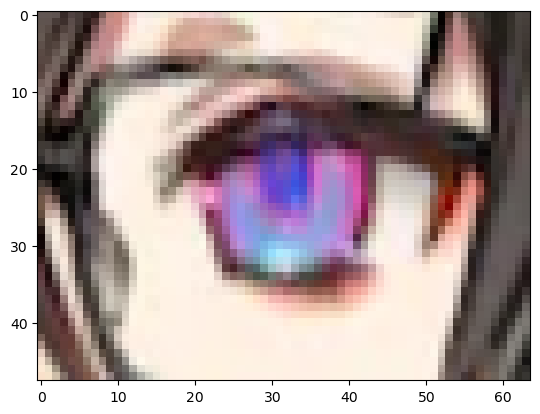

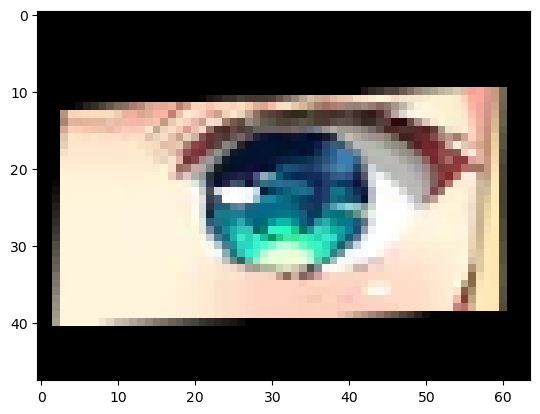

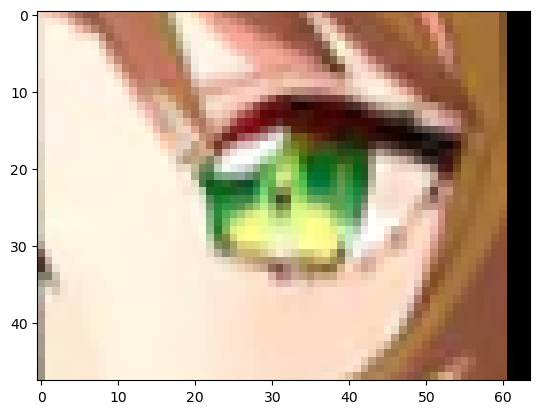

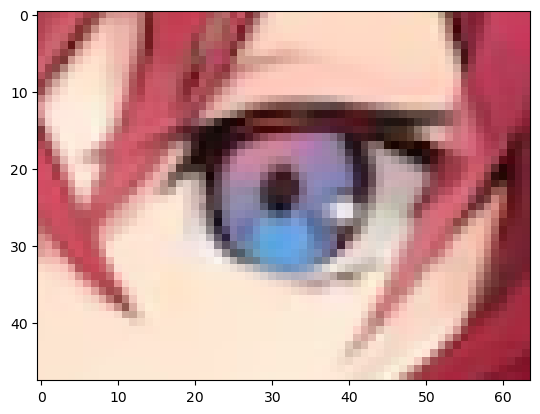

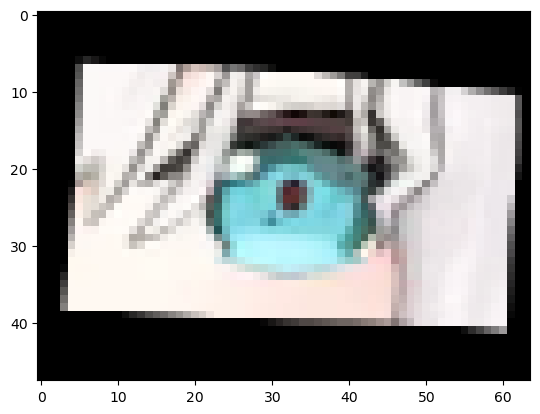

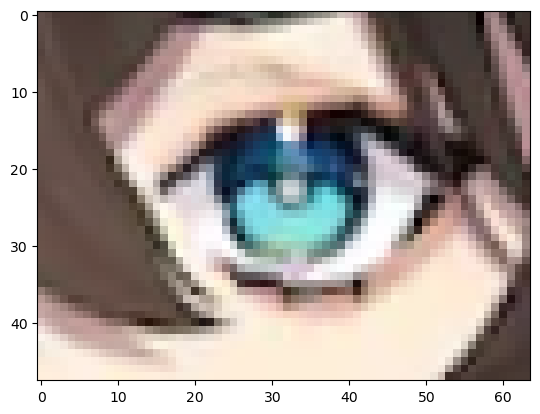

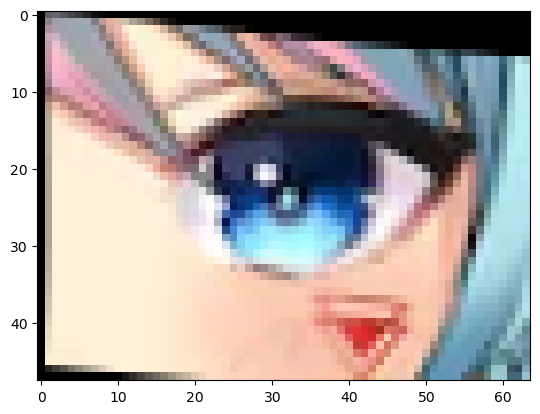

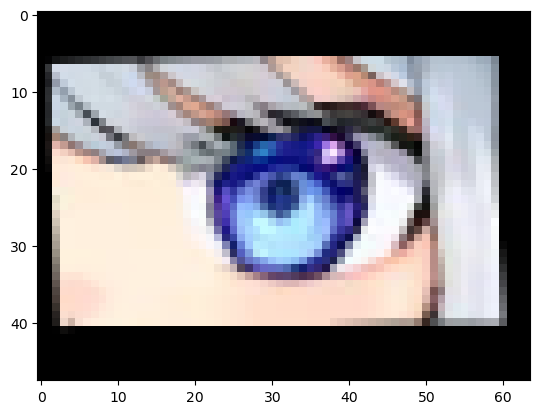

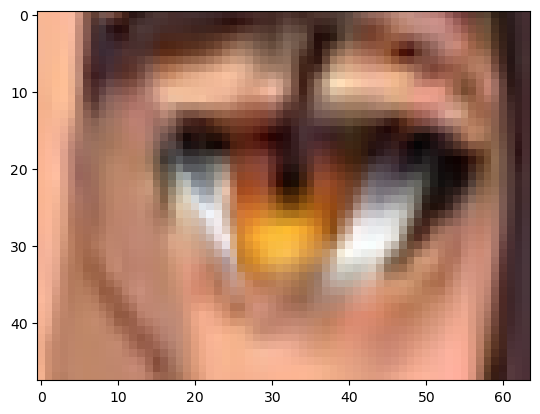

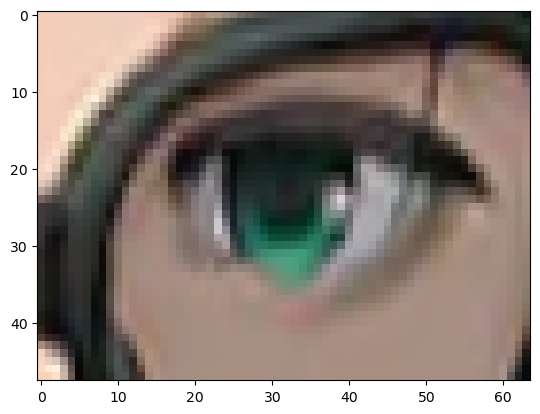

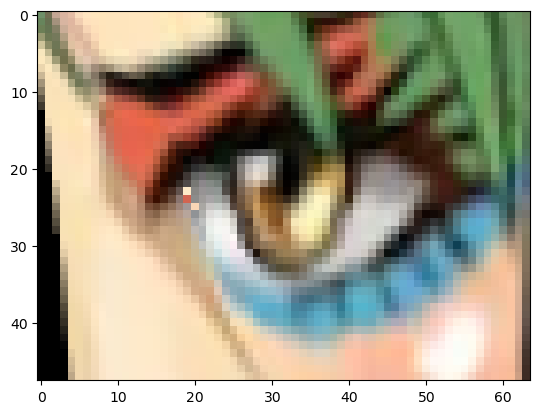

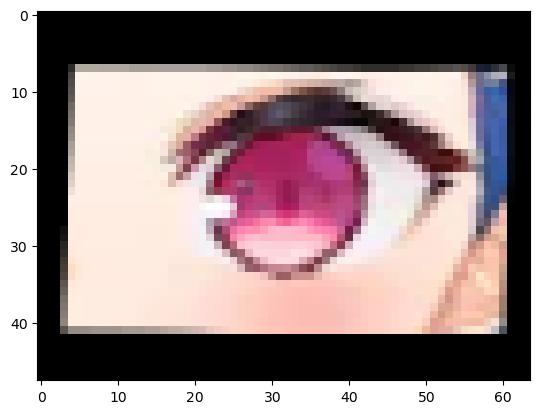

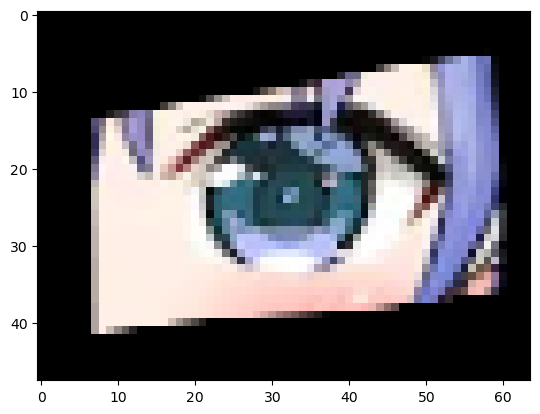

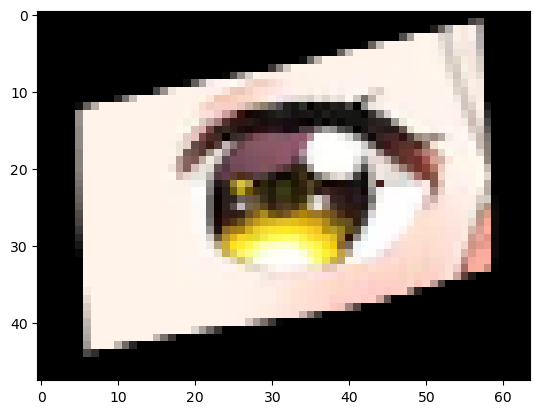

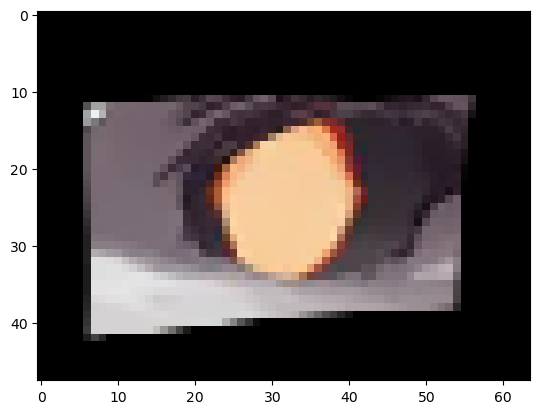

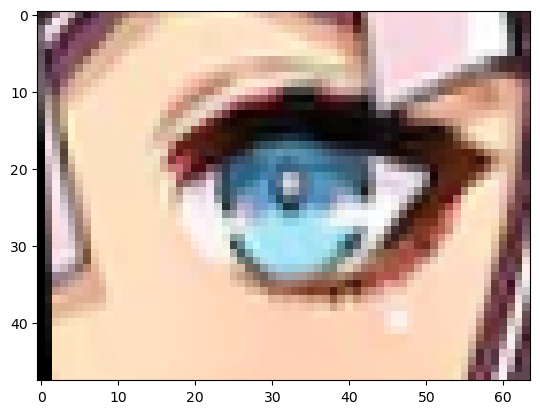

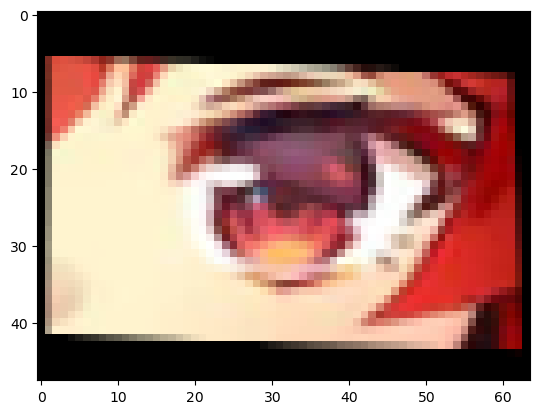

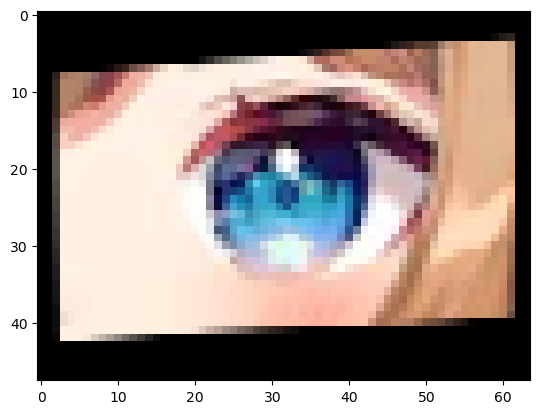

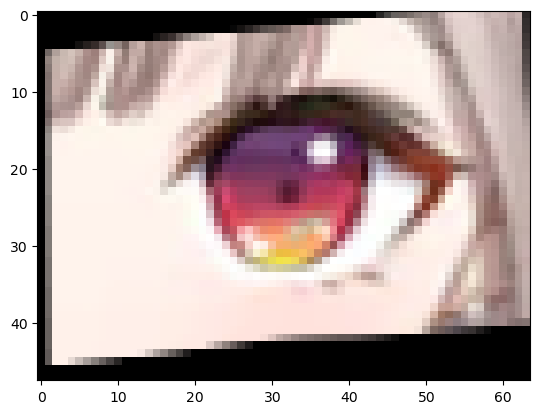

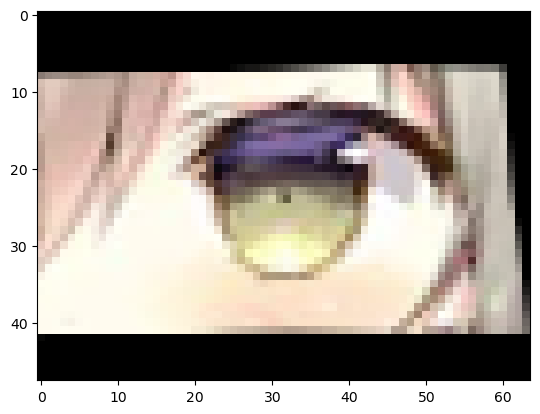

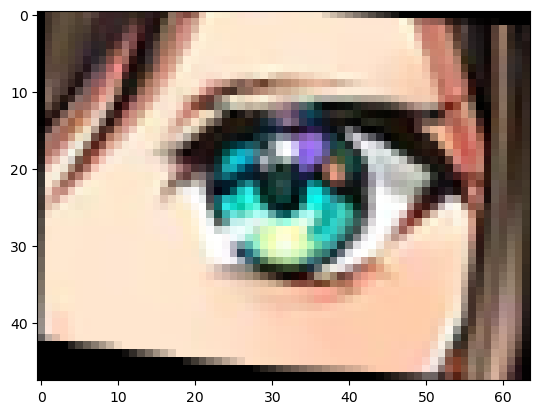

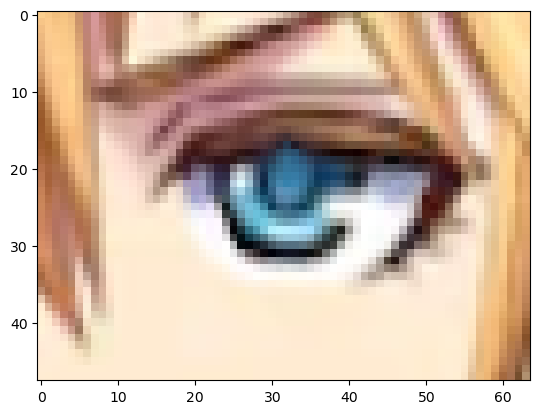

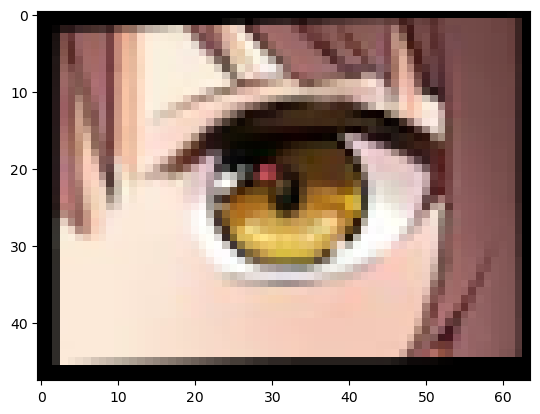

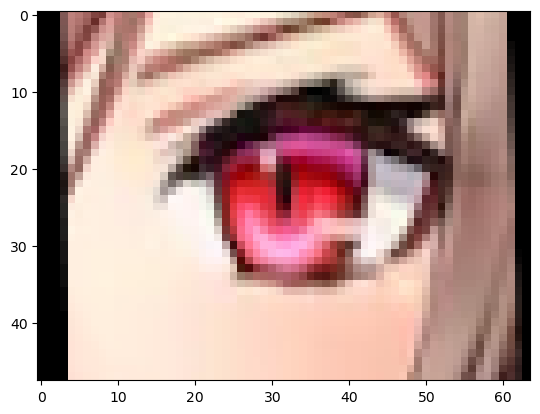

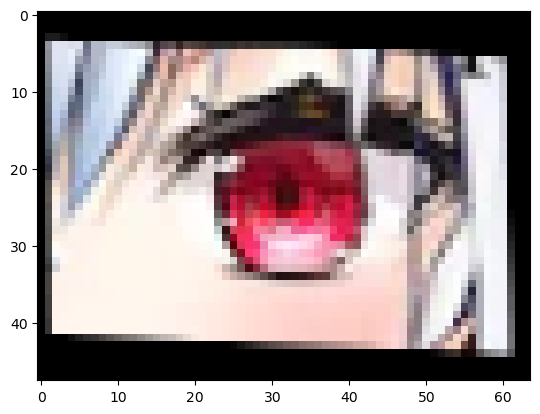

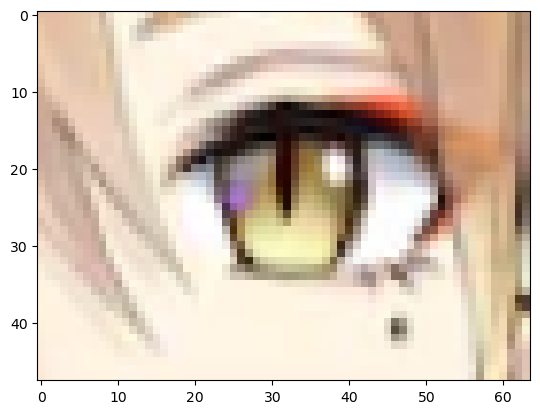

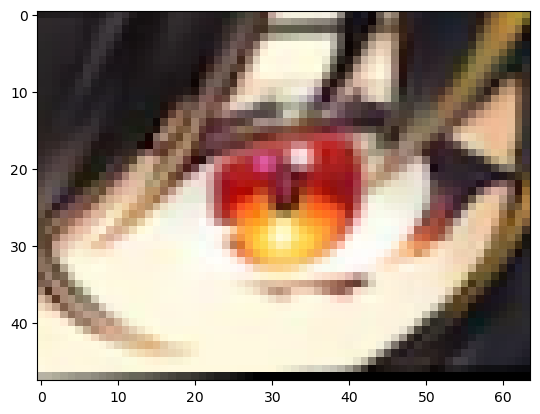

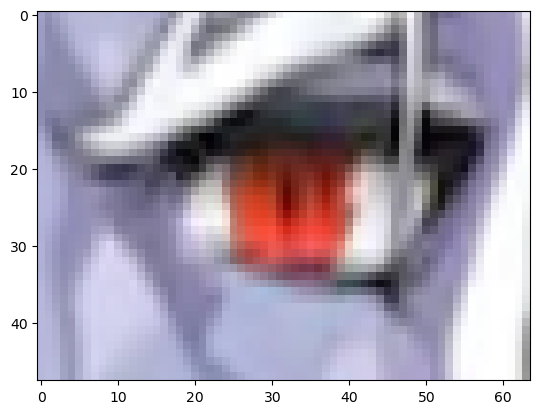

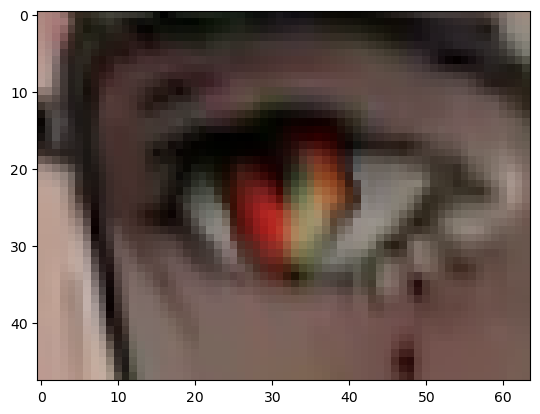

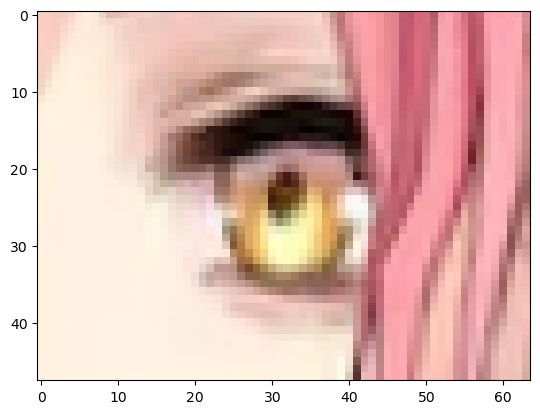

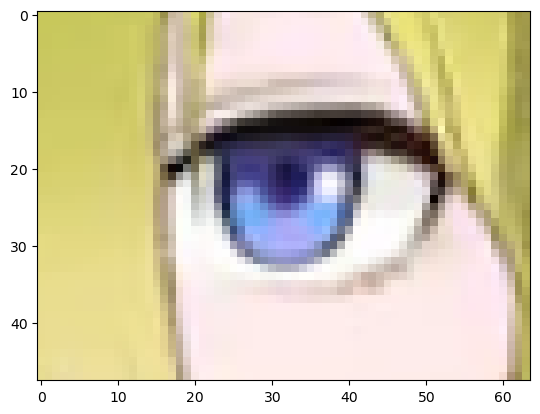

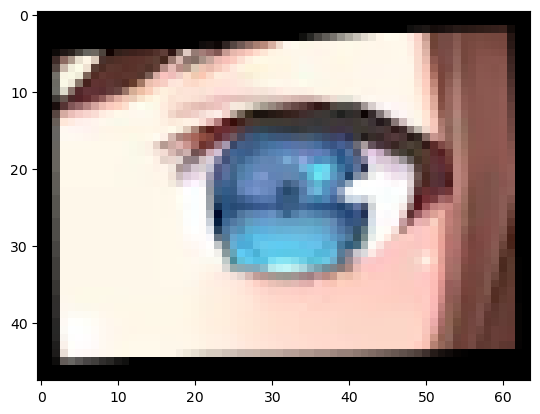

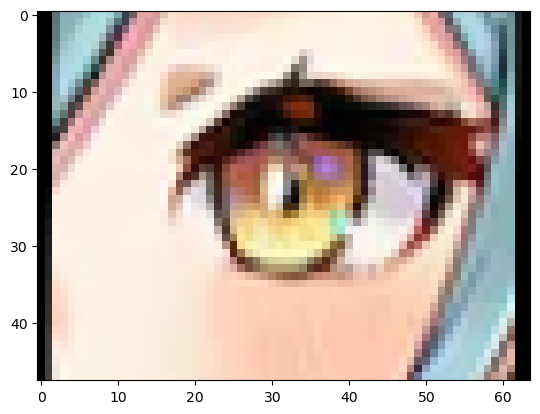

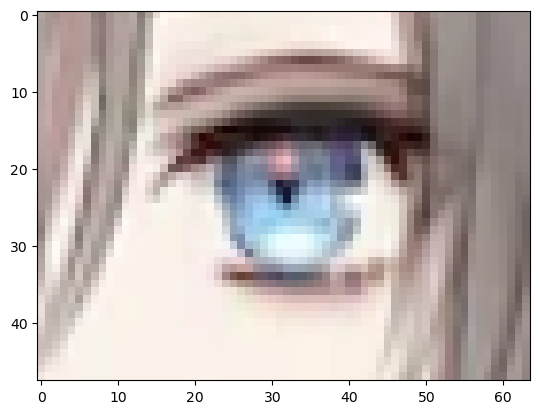

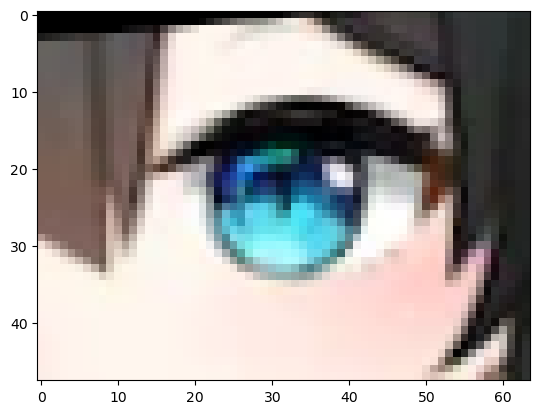

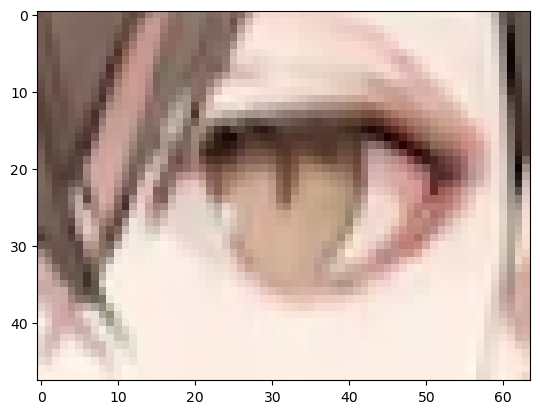

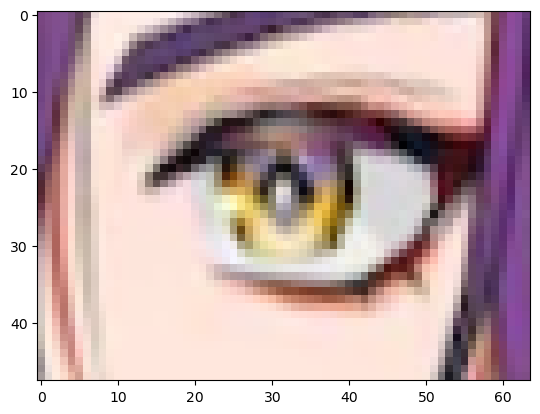

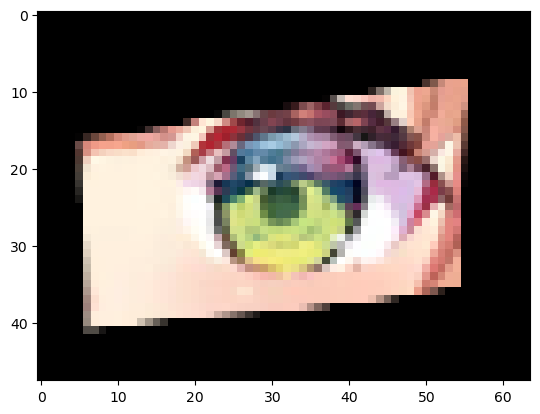

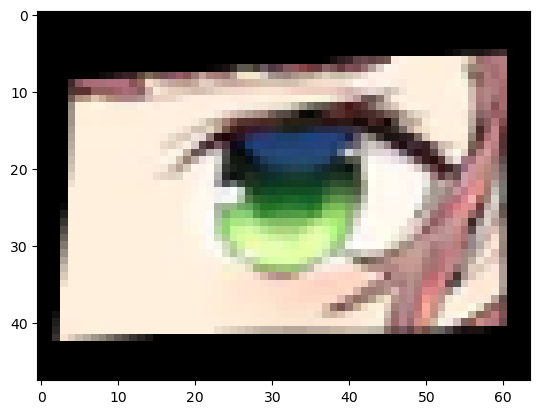

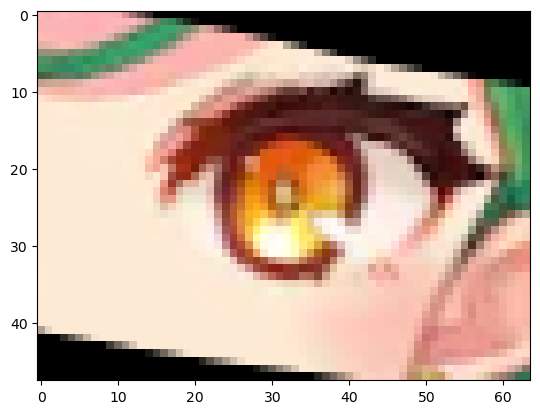

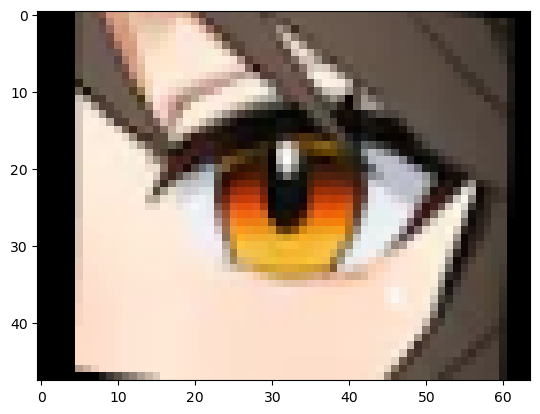

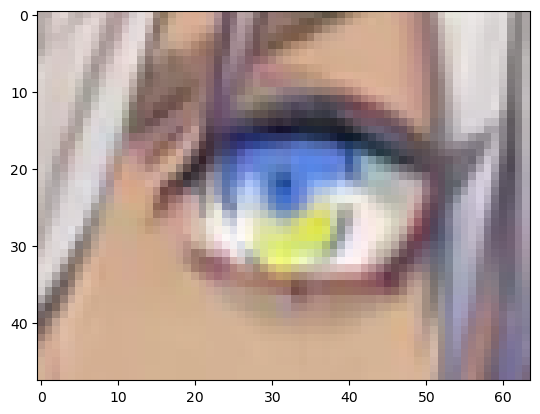

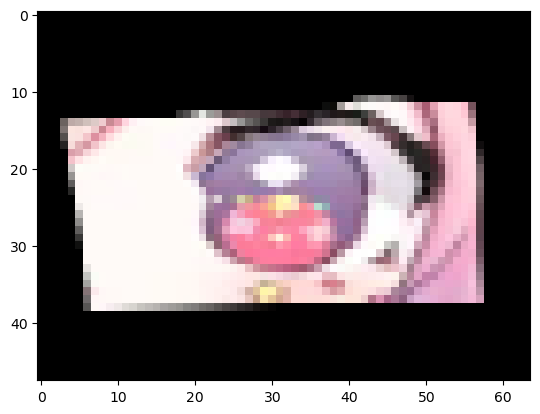

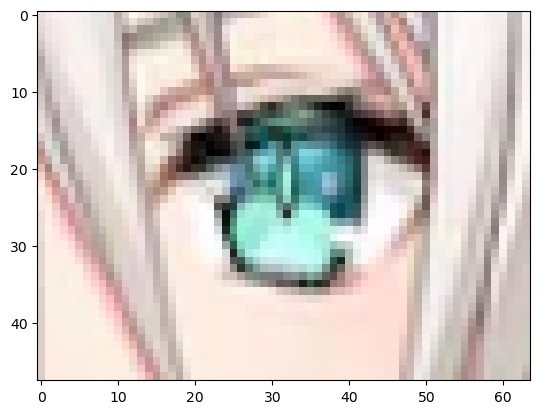

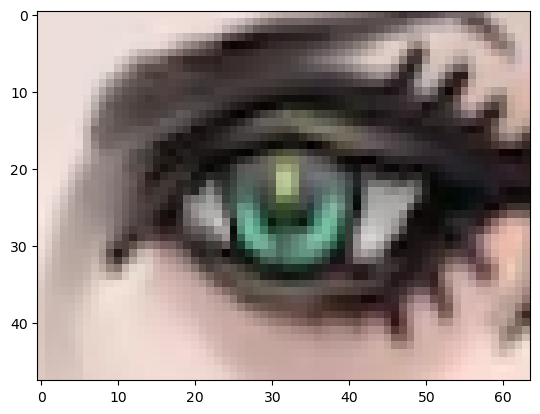

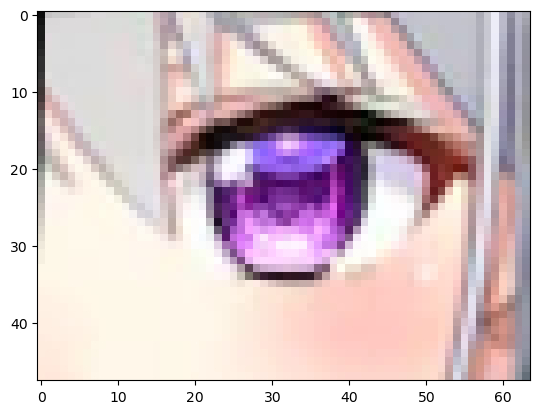

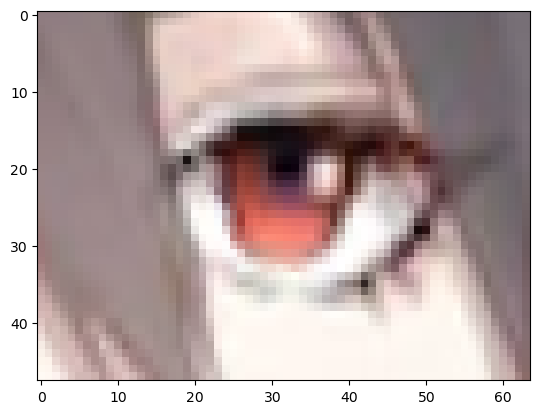

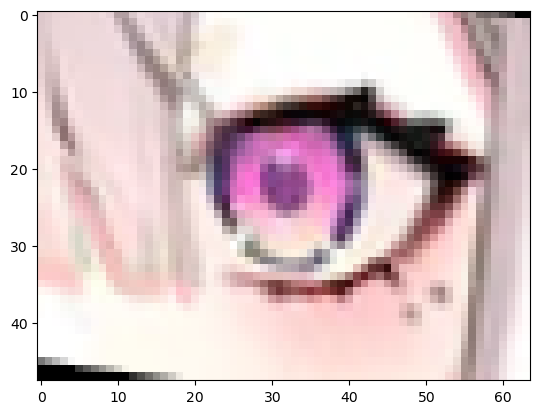

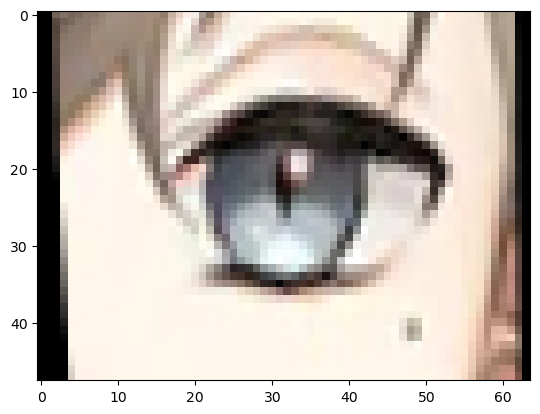

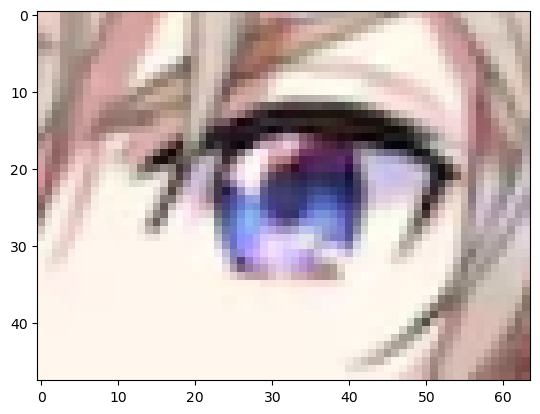

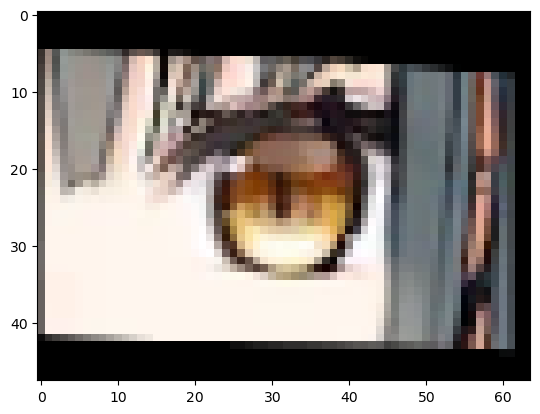

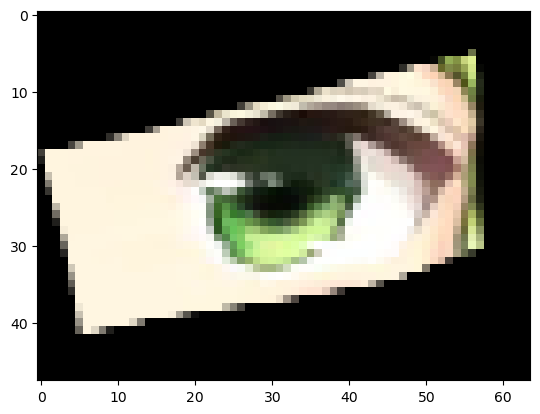

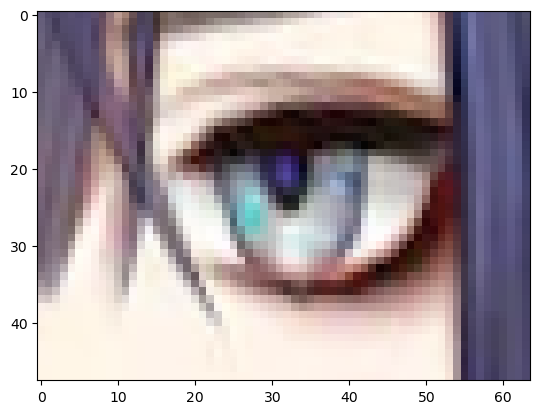

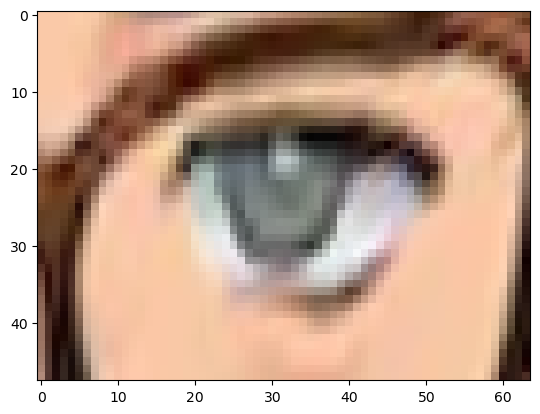

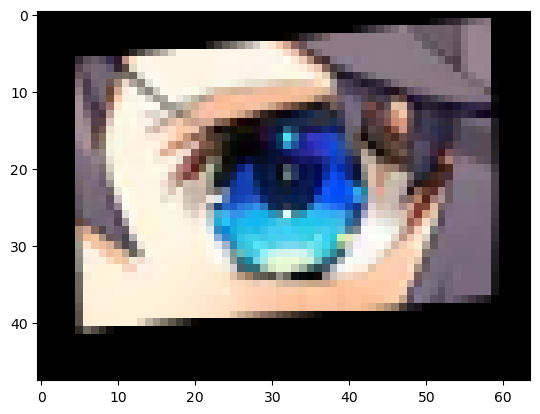

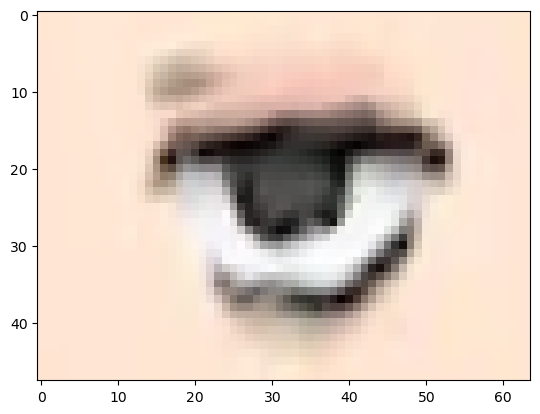

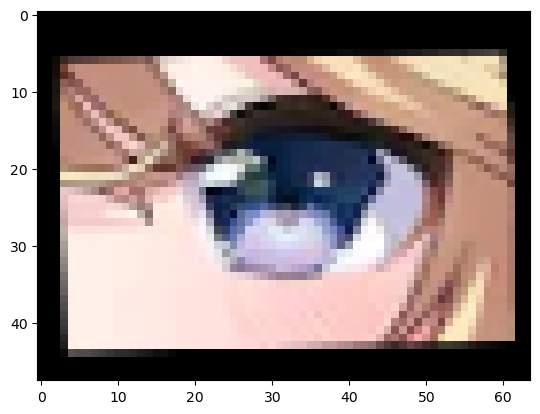

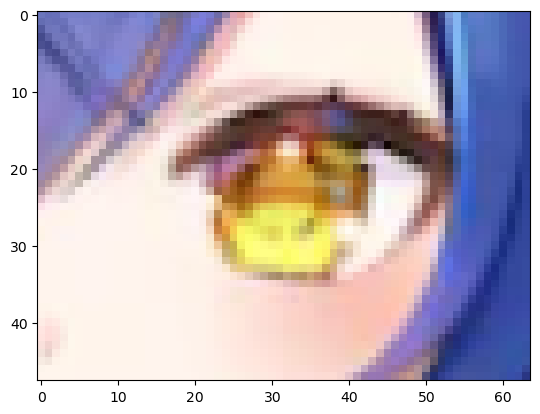

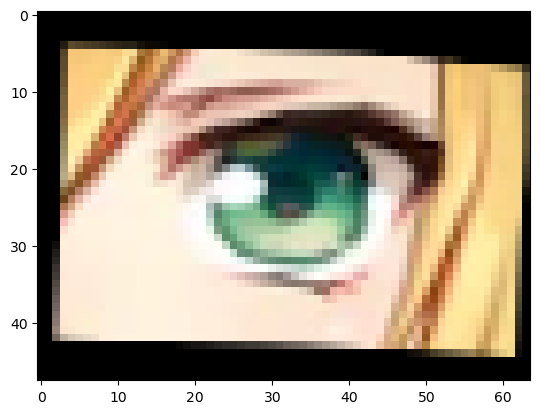

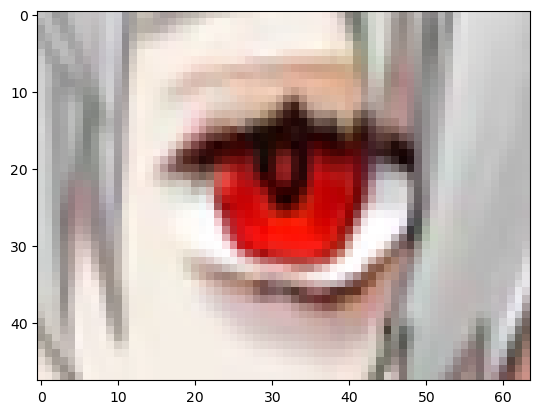

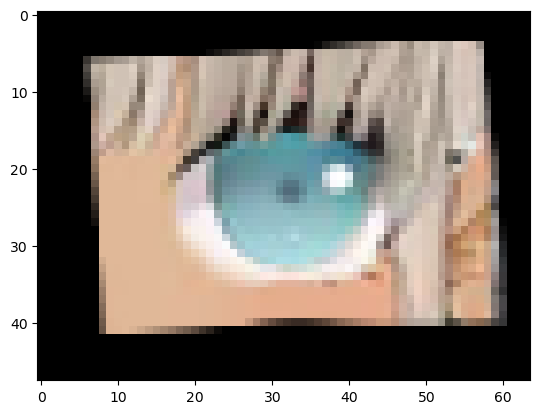

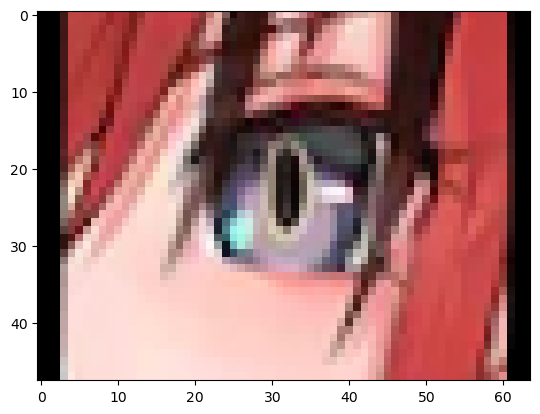

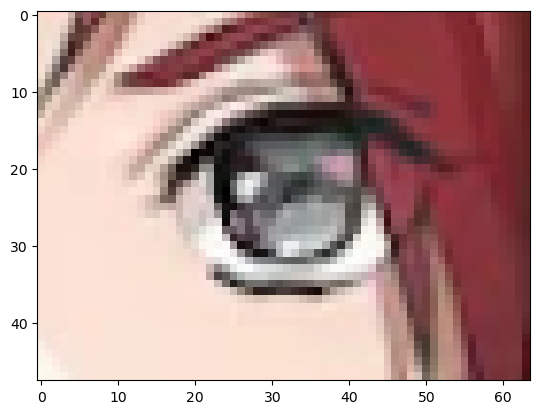

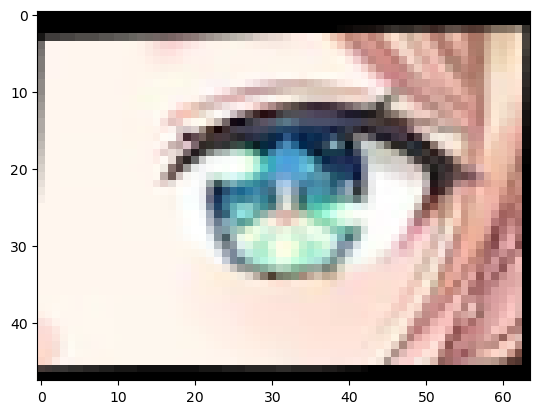

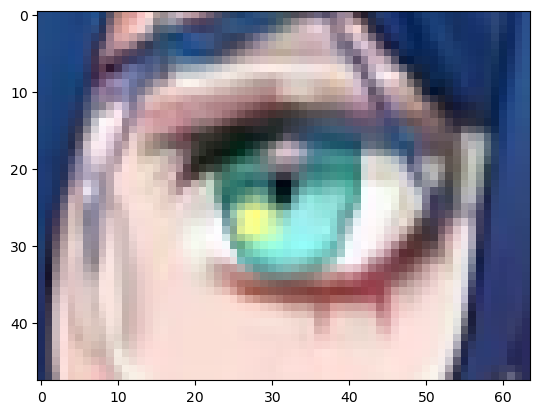

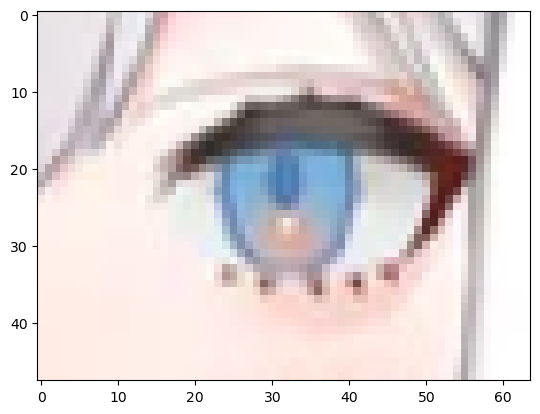

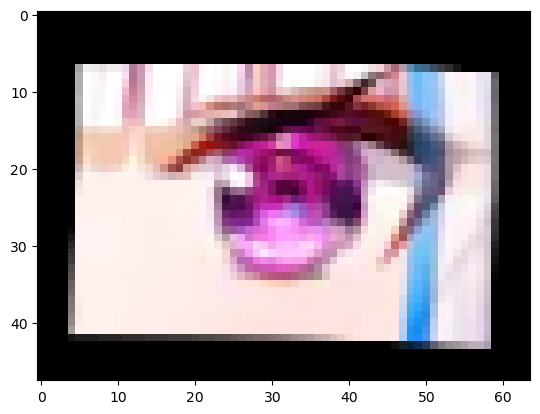

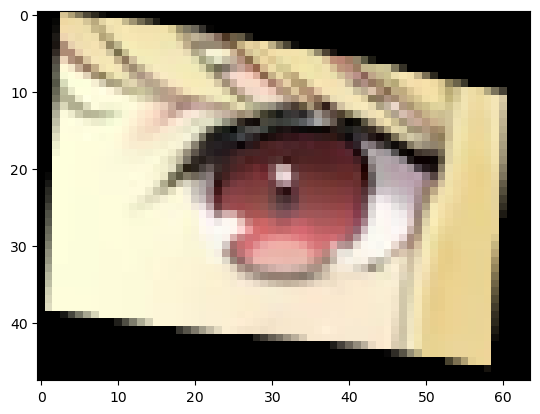

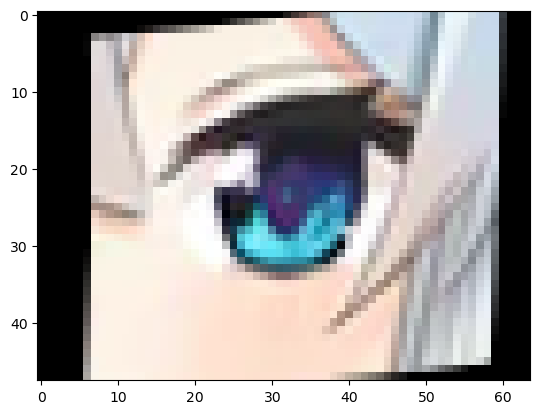

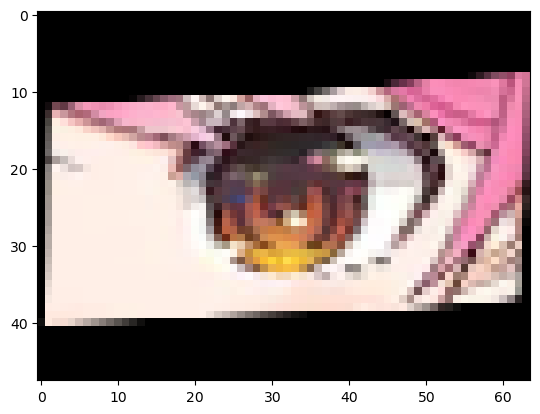

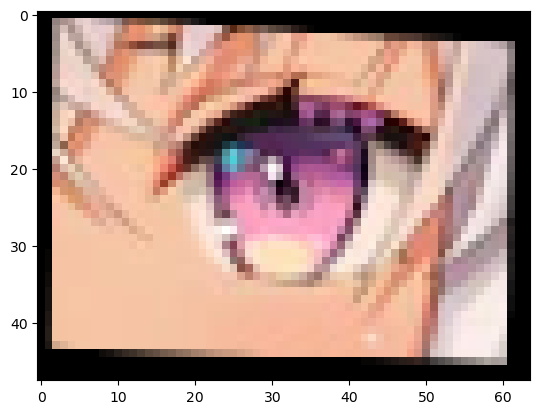

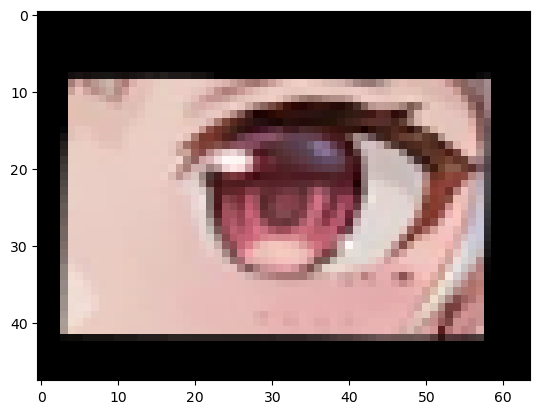

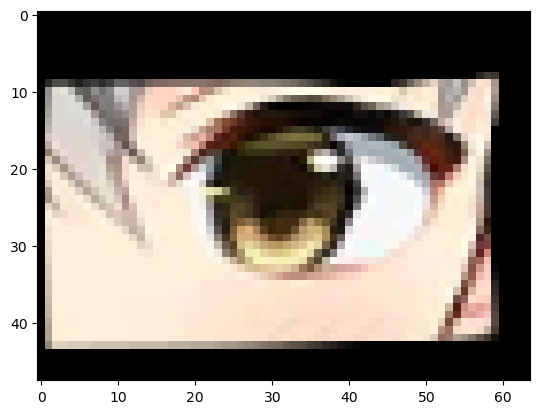

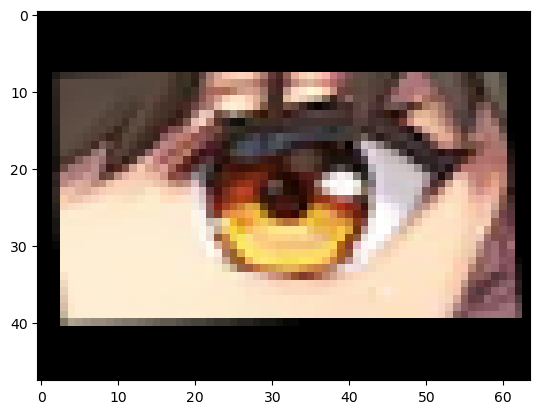

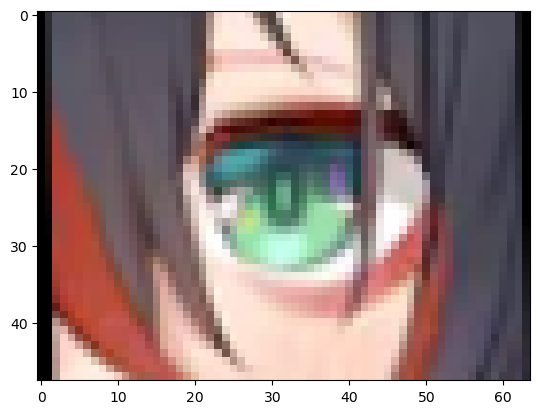

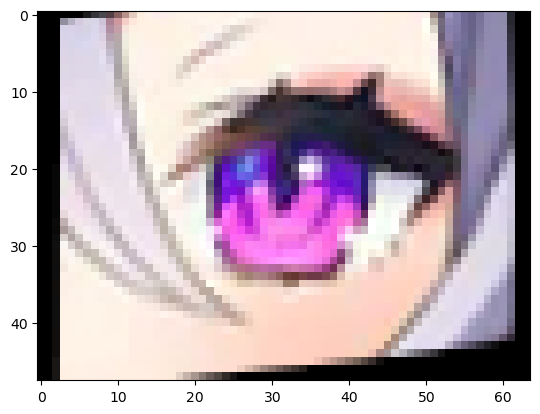

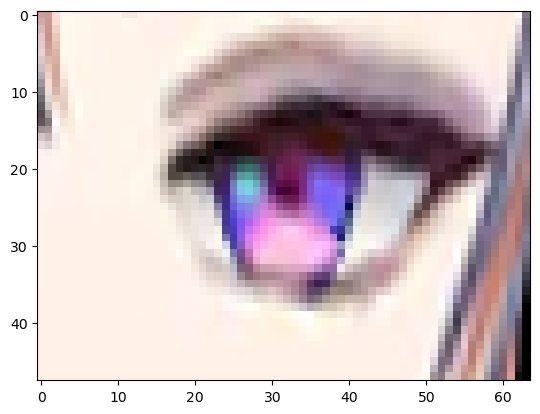

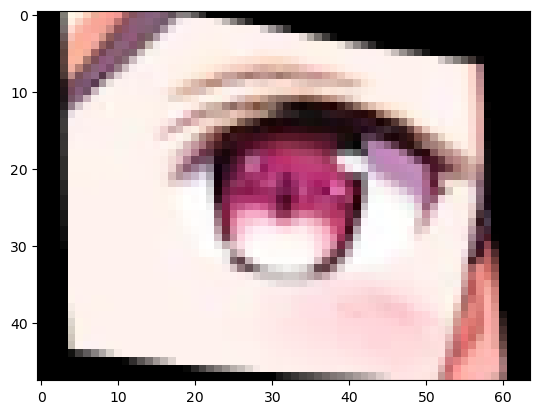

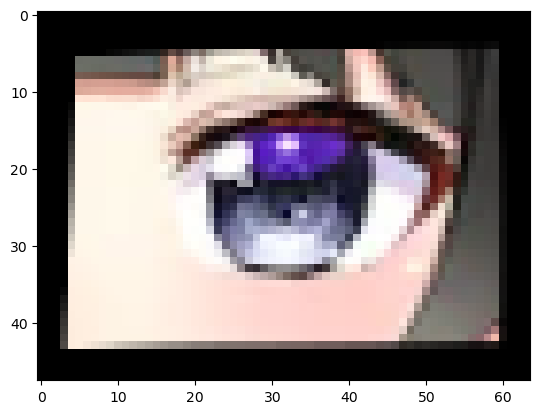

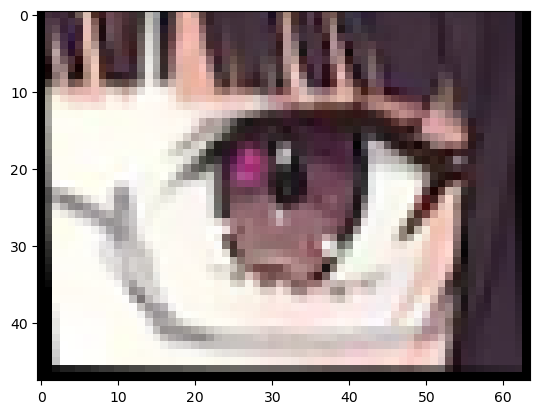

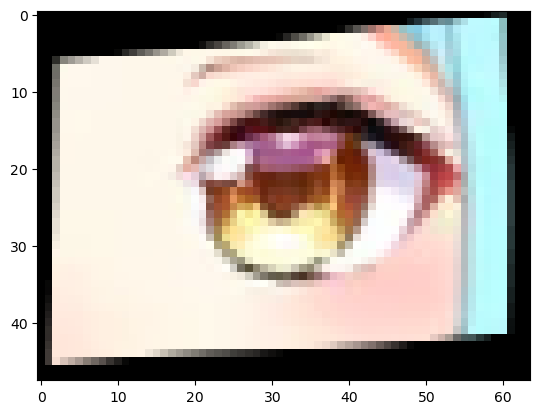

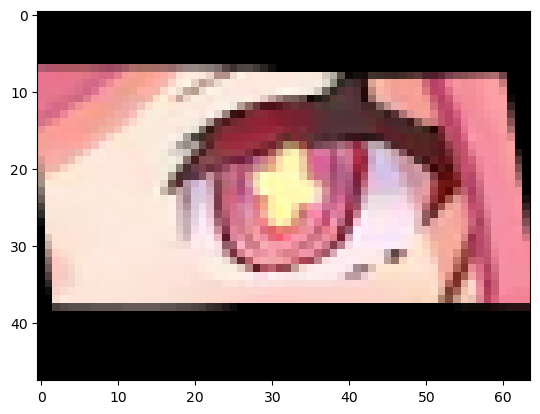

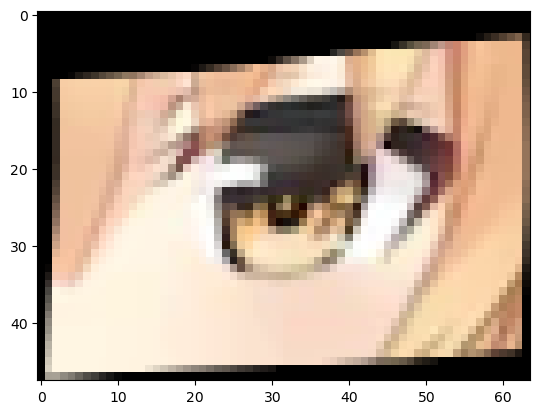

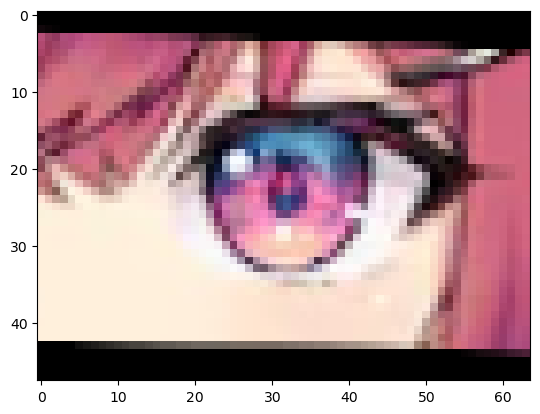

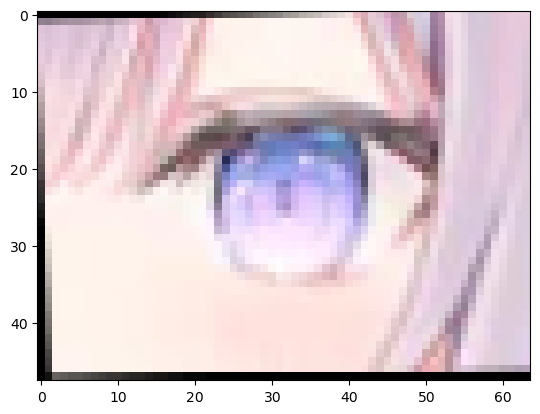

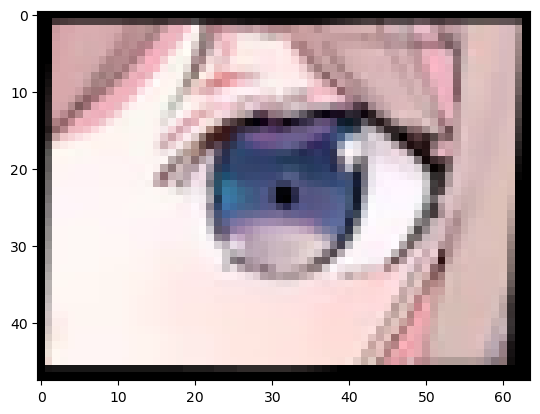

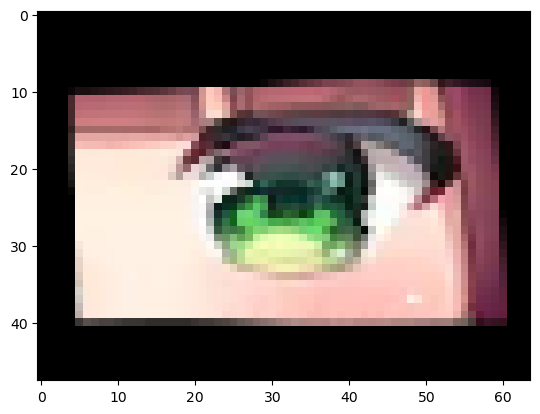

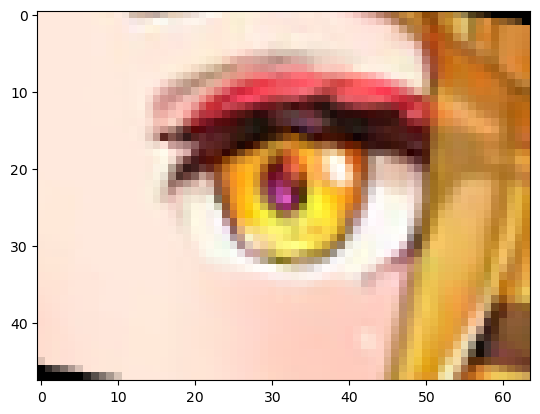

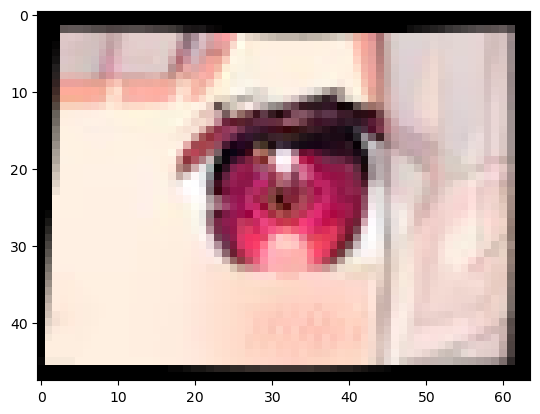

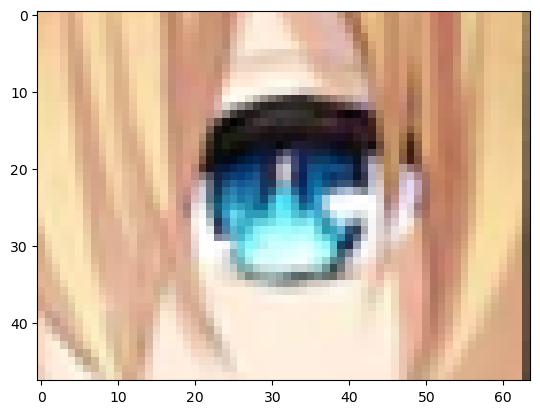

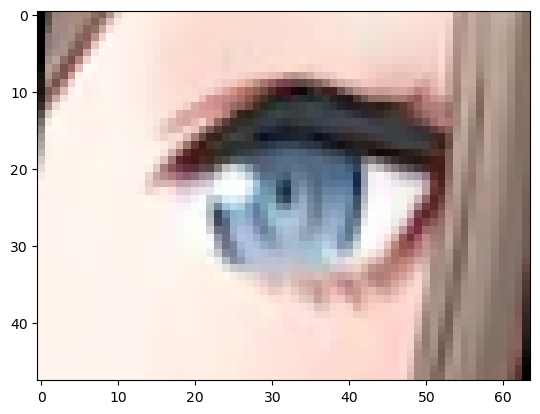

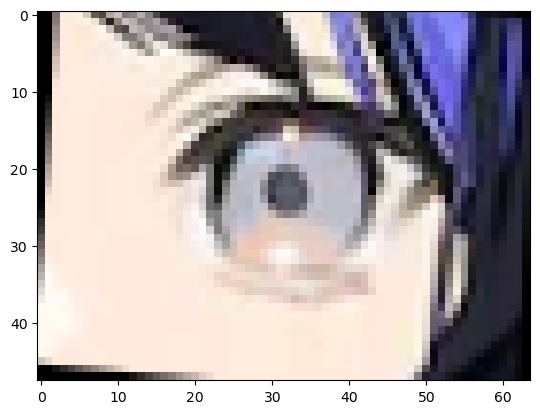

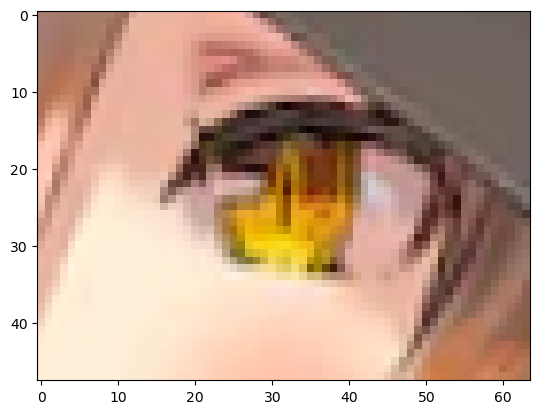

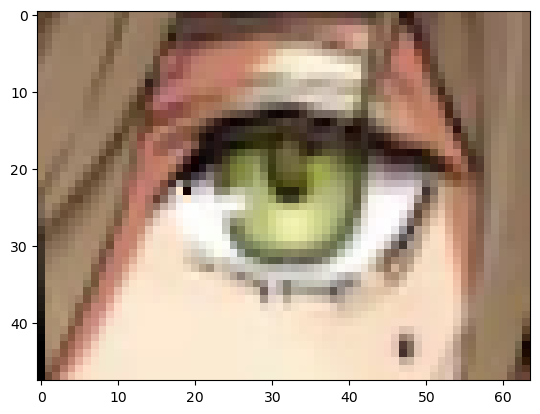

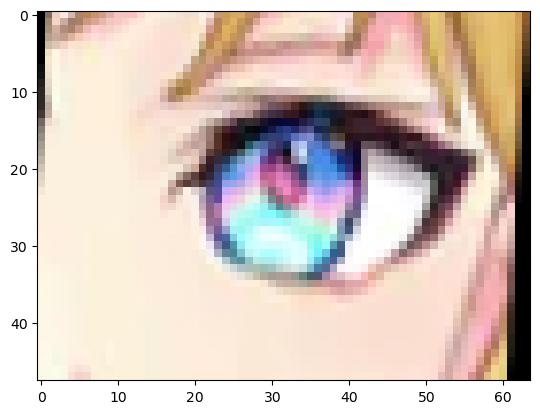

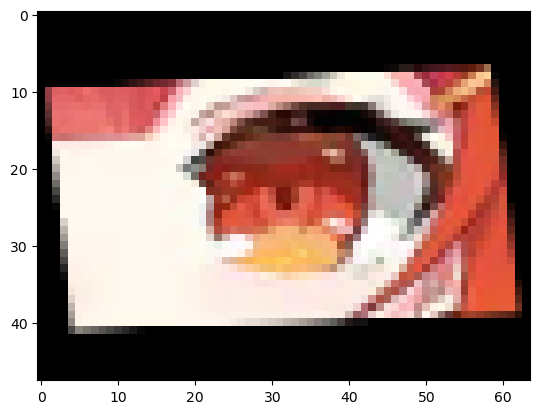

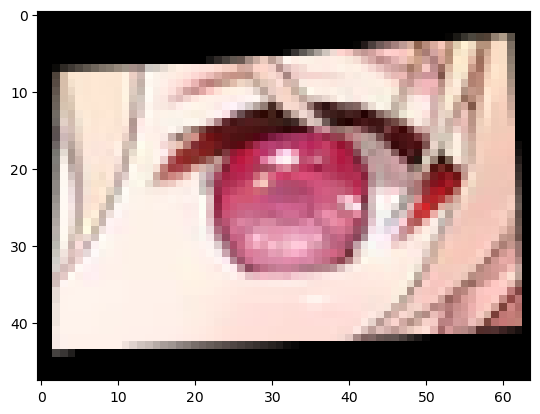

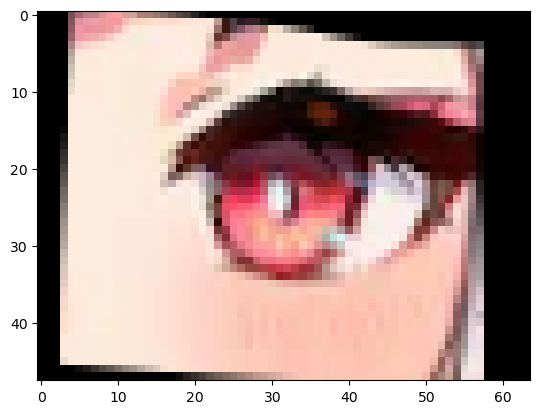

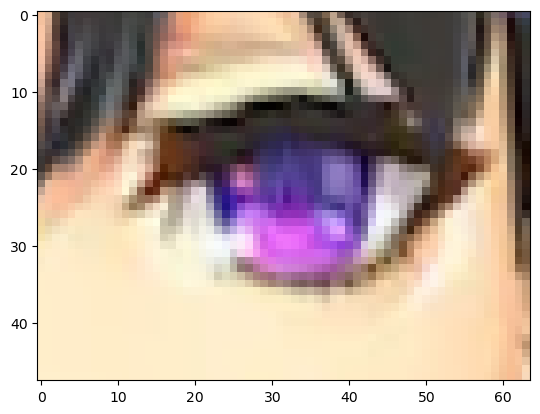

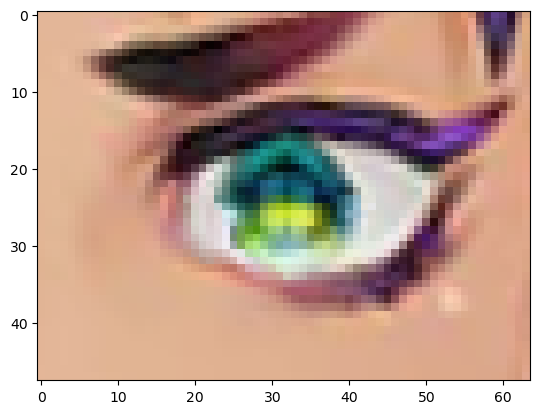

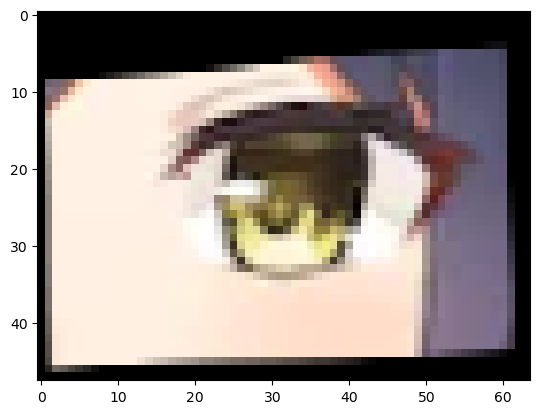

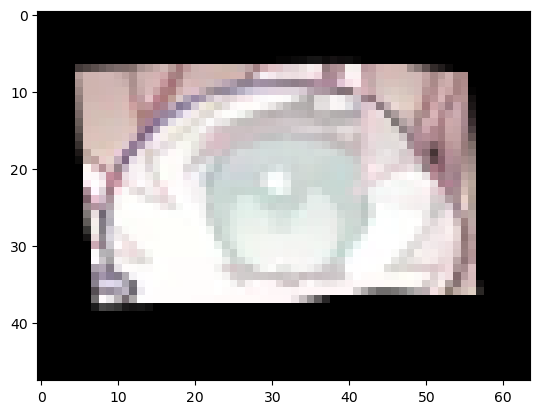

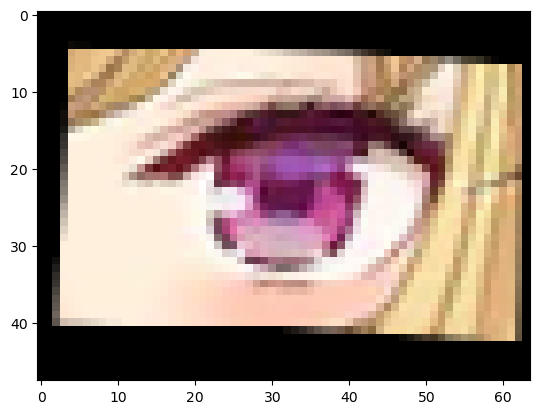

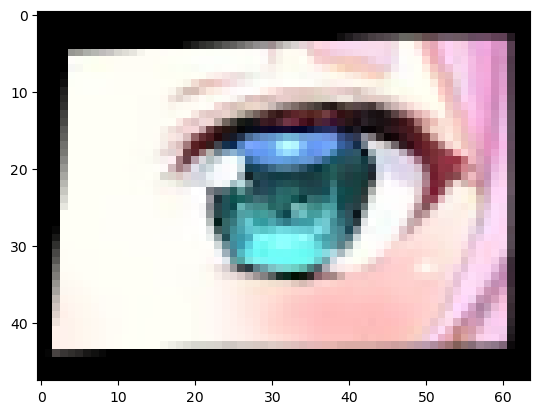

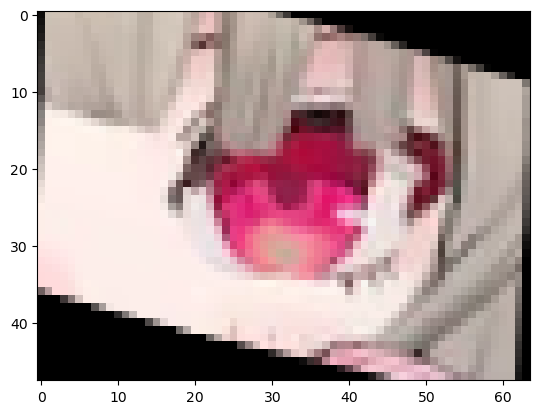

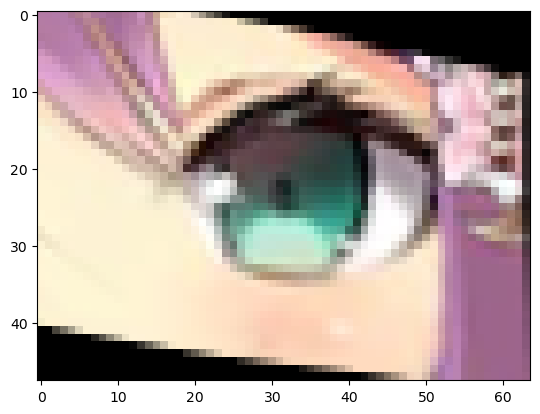

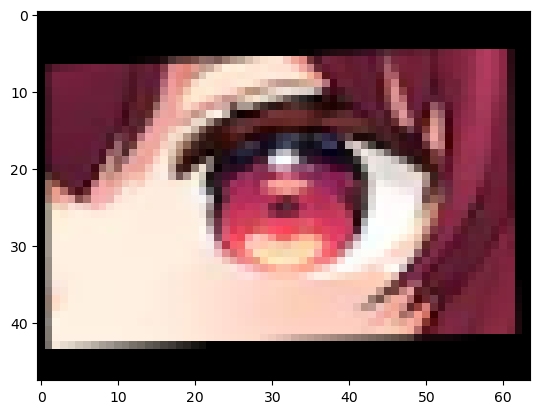

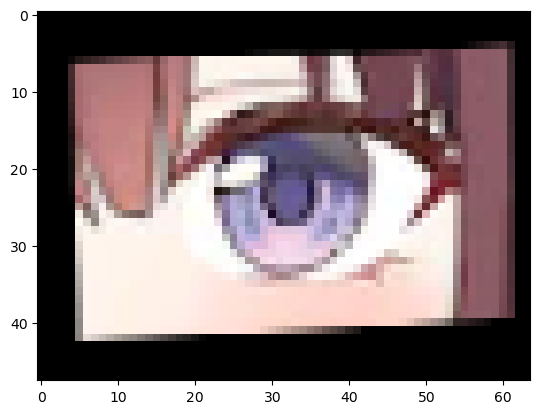

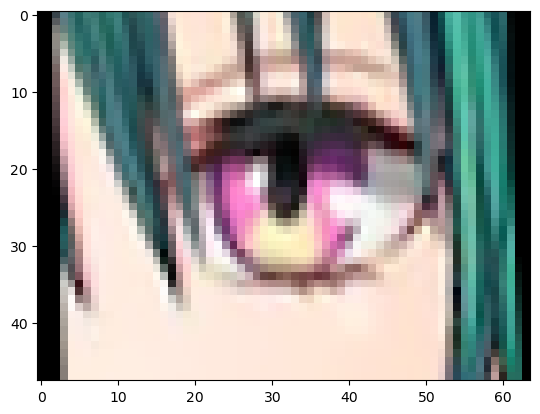

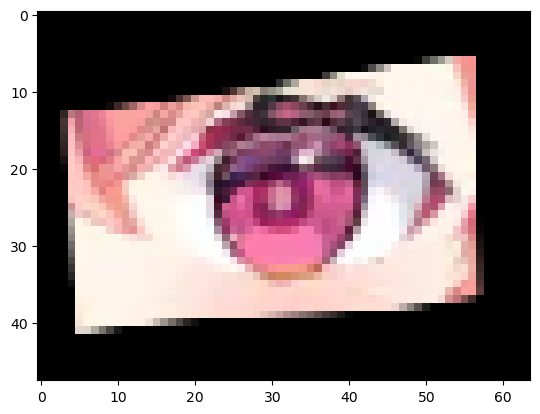

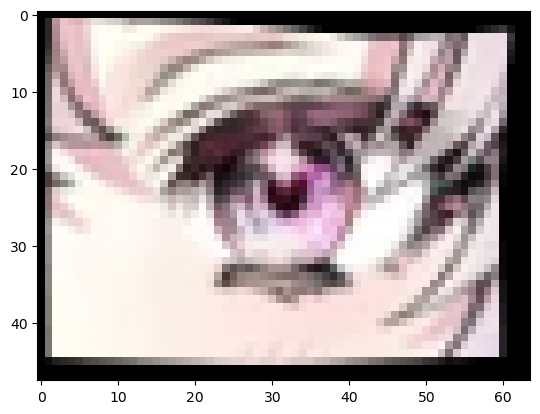

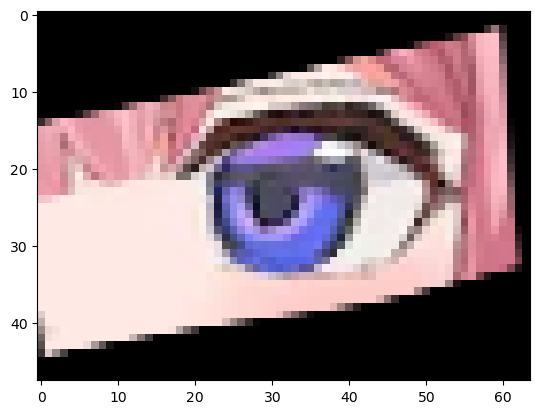

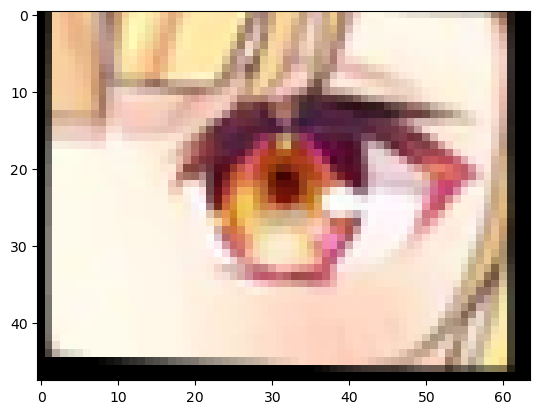

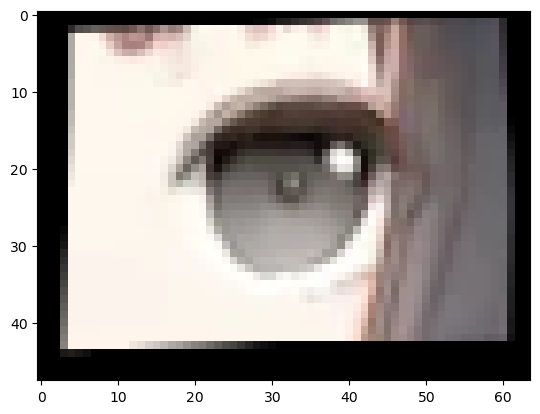

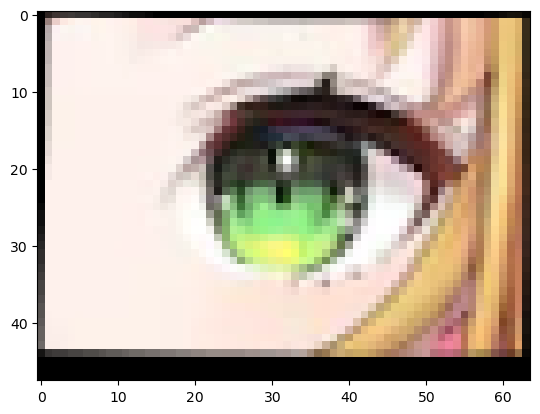

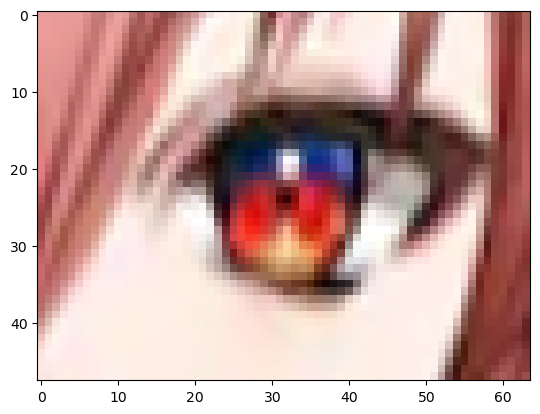

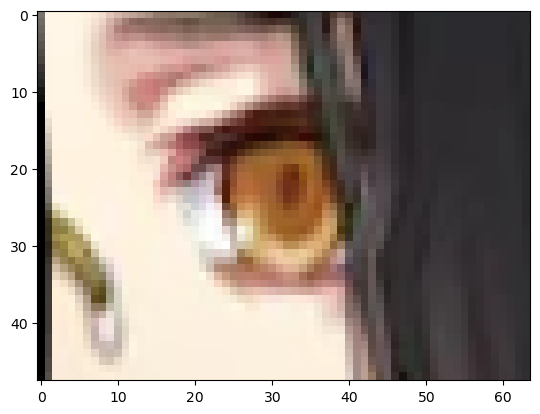

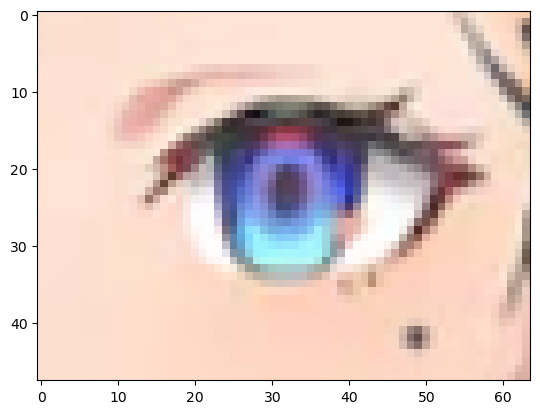

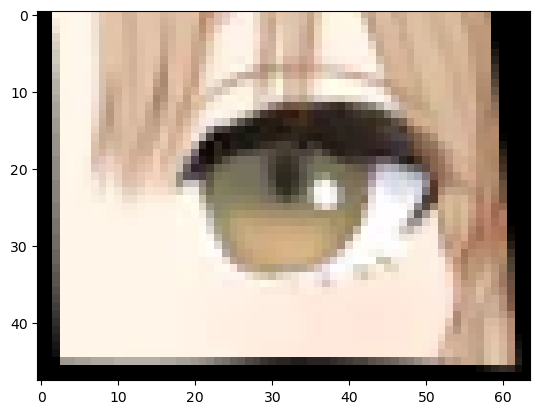

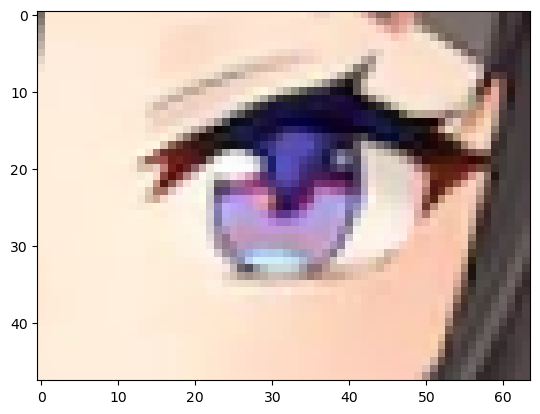

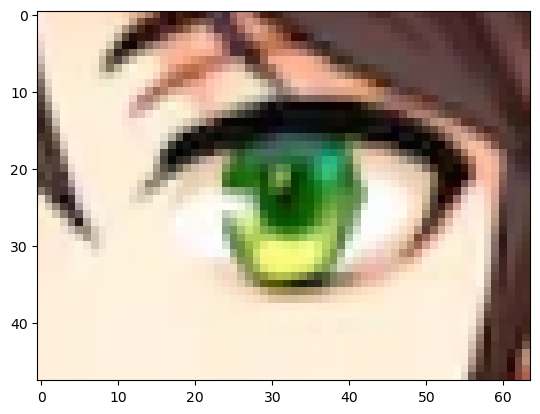

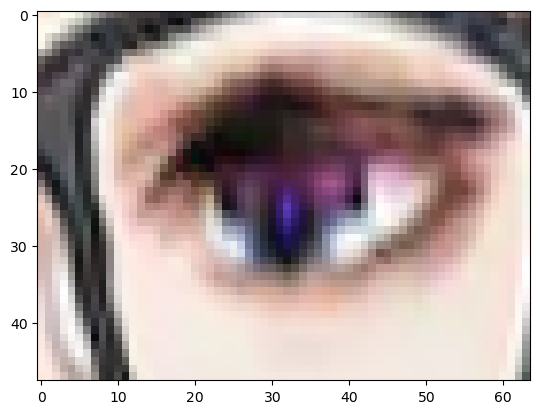

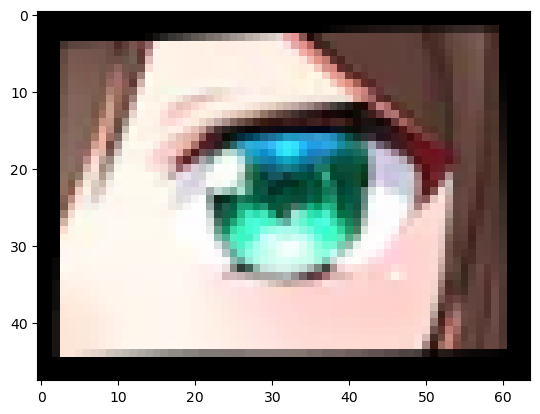

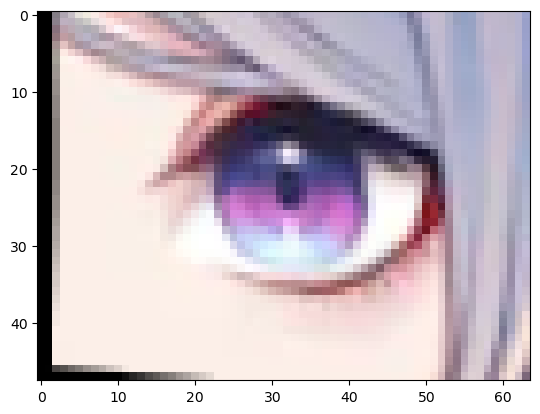

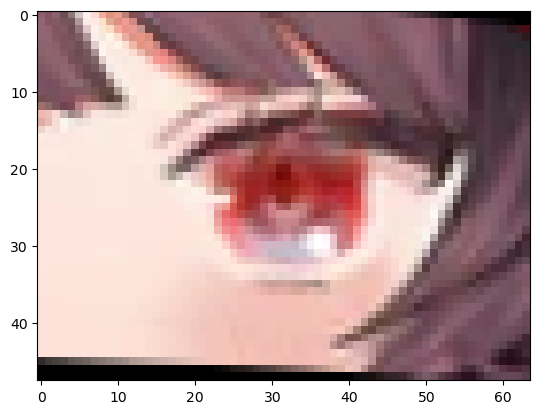

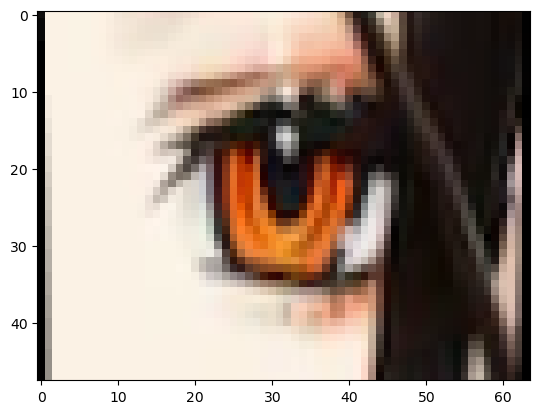

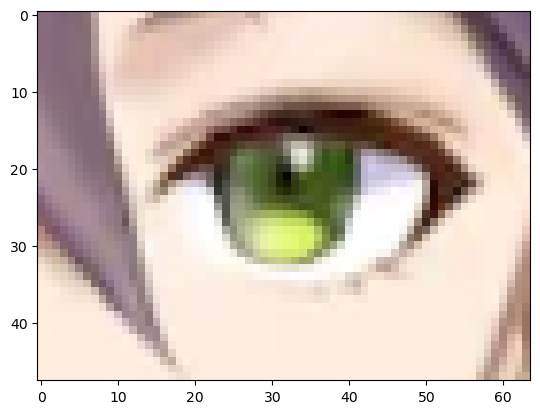

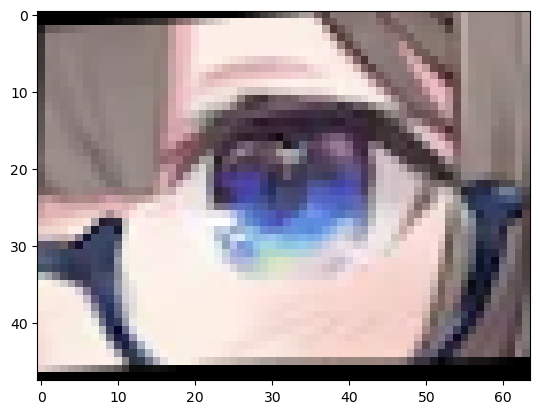

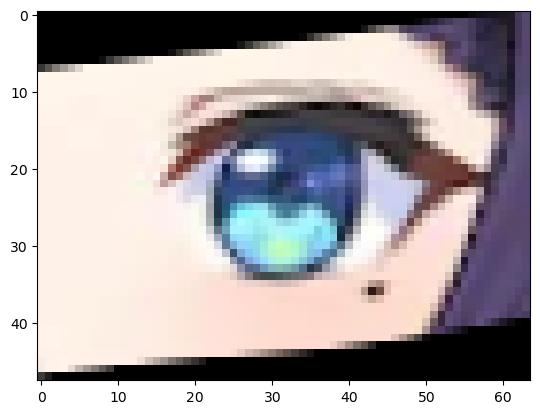

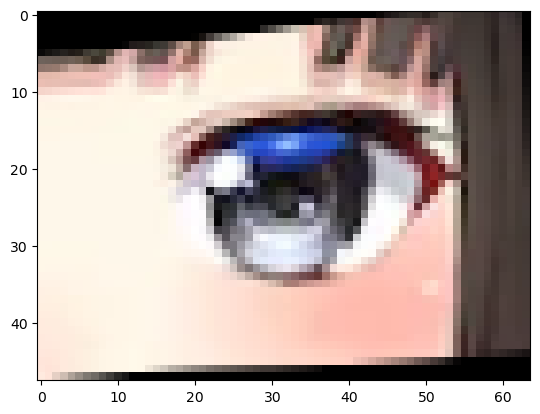

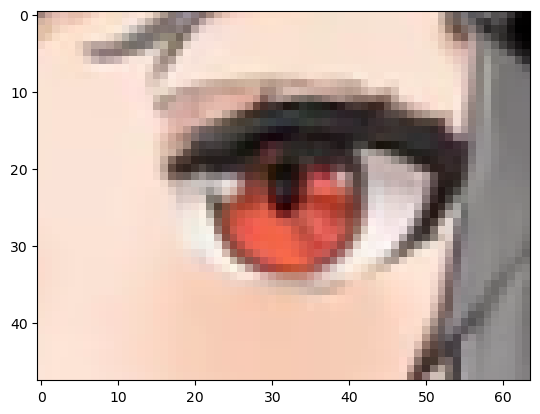

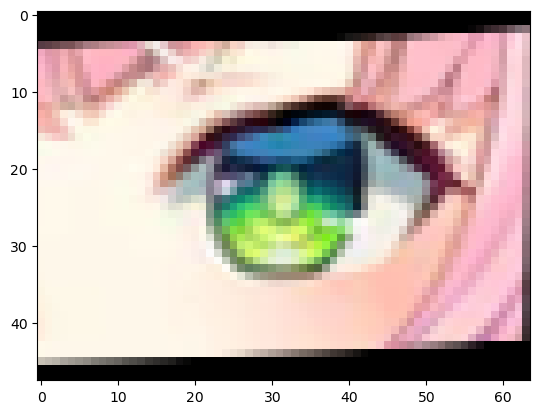

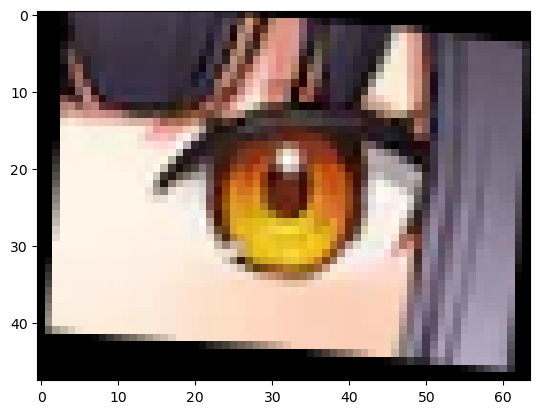

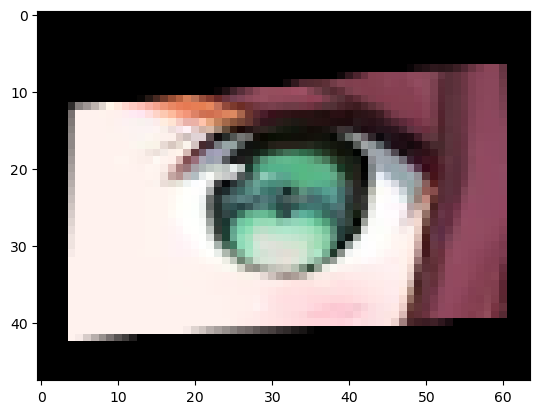

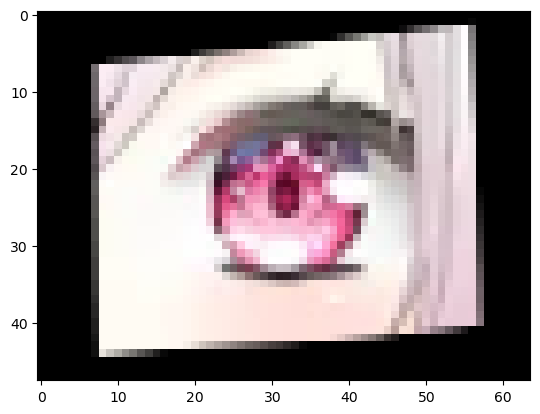

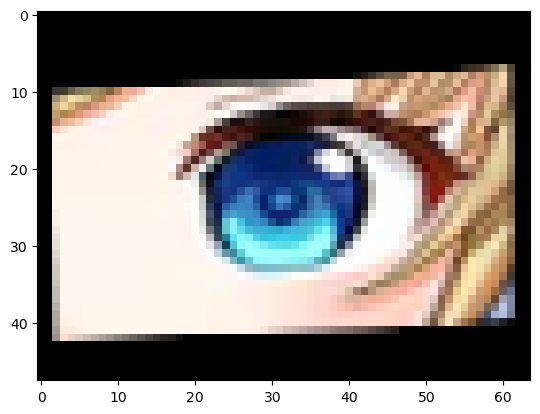

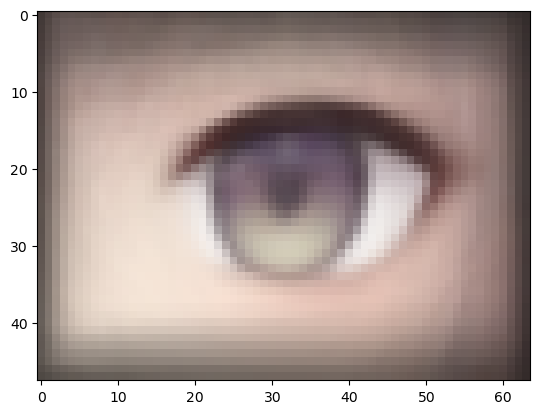

In [9]:
avgEye = np.zeros_like(img1)*(1.0)
avgEyeHSV = np.zeros_like(img1)*(1.0)
eyeDatas = []
eyeDatasHSV = []
handleDatas = []

for i in range(N):
    
    if i == 84 or i == 122 or i == 123:
        continue
    
    tex = cv2.imread('data_eyes/'+ str(i+1).zfill(3)+ '.png')
    eyeMesh = mesh(30,30,64,48, tex)
    eyeMesh.setHandlesOrg(handlesArr[i])
    eyeMesh.setHandlesDfm(handlesAvg)
    eyeMesh.applyHandles()
    
    newImg = eyeMesh.deform()
    newImgHSV = cv2.cvtColor(newImg, cv2.COLOR_BGR2HSV)
    
    avgEye += newImg/1
    avgEyeHSV += newImgHSV/1
    
    plt.imshow(cv2.cvtColor(newImg, cv2.COLOR_BGR2RGB)) # OpenCV は色がGBR順なのでRGB順に並べ替える
    plt.show()
    
    eyeVec = newImg.reshape(48*64*3)
    eyeVecHSV = newImgHSV.reshape(48*64*3)
    
    handleVec = handlesArr[i].reshape(H*1*2)
    
    eyeData = np.append(eyeVec, handleVec)
    eyeDataHSV = np.append(eyeVecHSV, handleVec)
    
    eyeDatas.append(eyeData)
    eyeDatasHSV.append(eyeDataHSV)
    handleDatas.append(handleVec)
    
avgEye = avgEye / n
avgEyeHSV = avgEyeHSV / n

avgEye = avgEye.astype(np.uint8)
avgEyeHSV = avgEyeHSV.astype(np.uint8)

eyeDatas = np.array(eyeDatas)
eyeDatasHSV = np.array(eyeDatasHSV)

plt.imshow(cv2.cvtColor(avgEye, cv2.COLOR_BGR2RGB)) # OpenCV は色がGBR順なのでRGB順に並べ替える
plt.show()
#cv2.imwrite('output/avgEye_5p.png', avgEye)

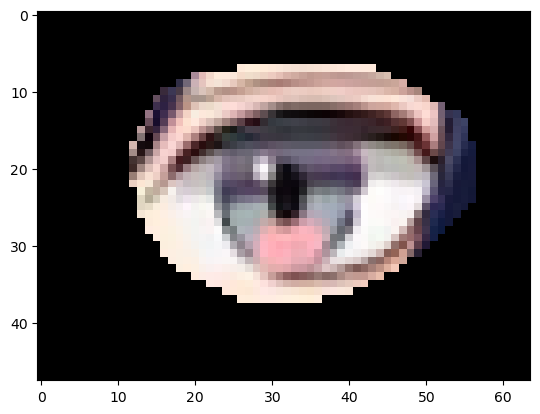

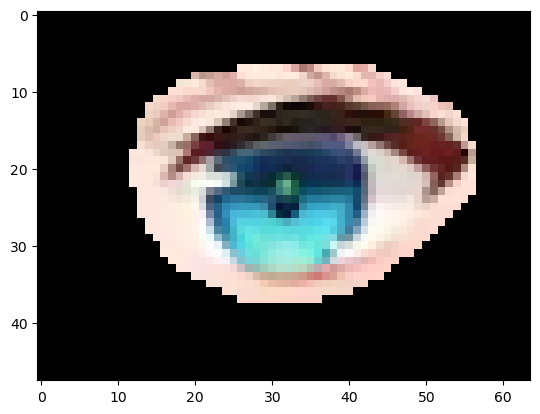

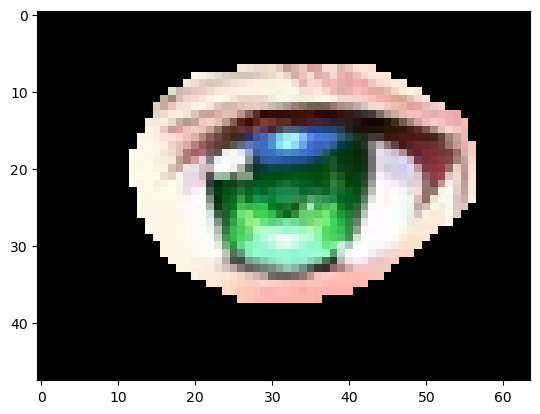

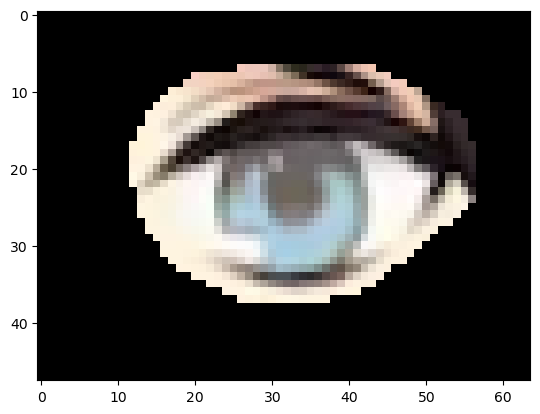

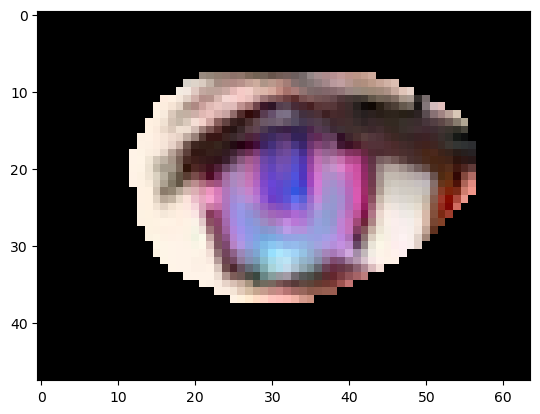

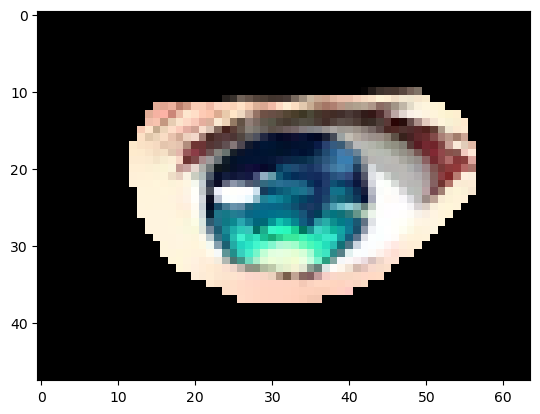

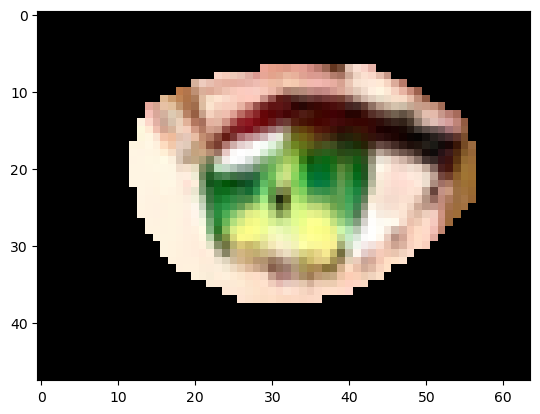

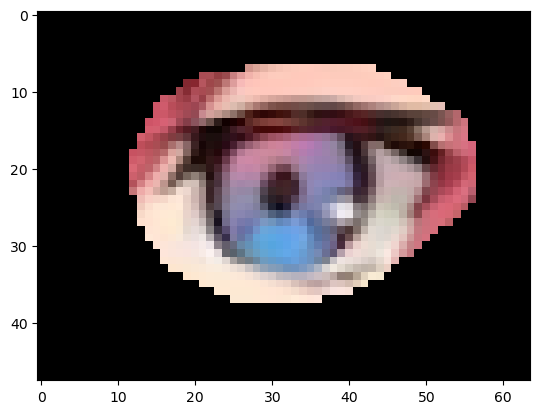

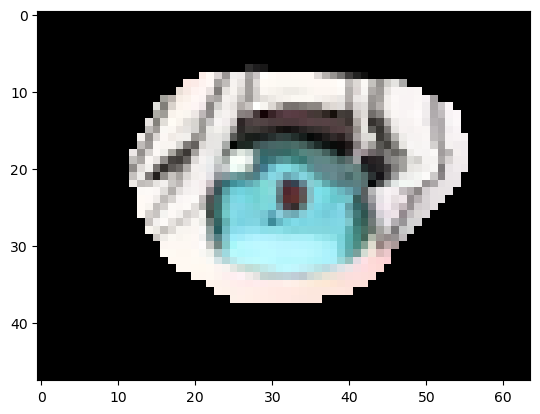

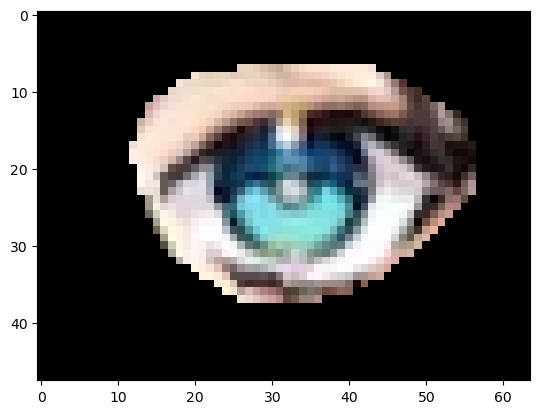

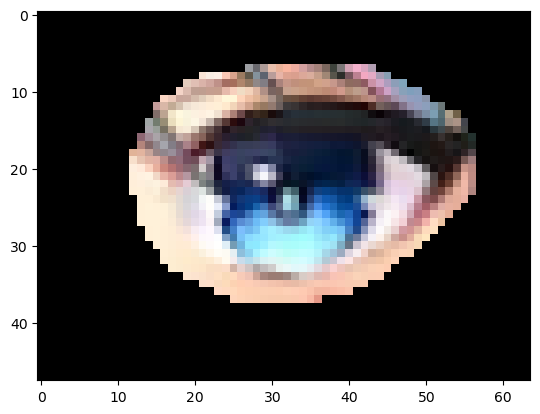

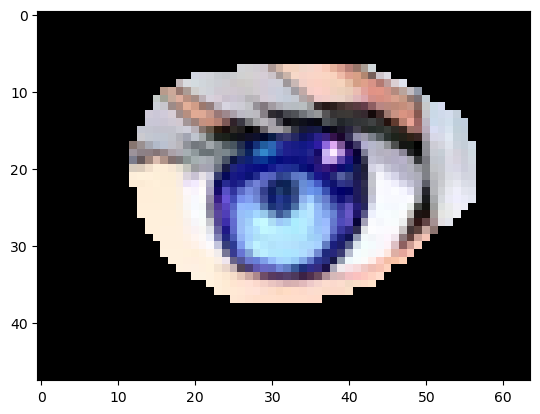

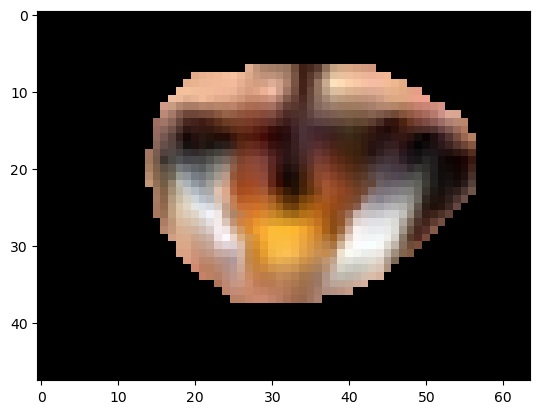

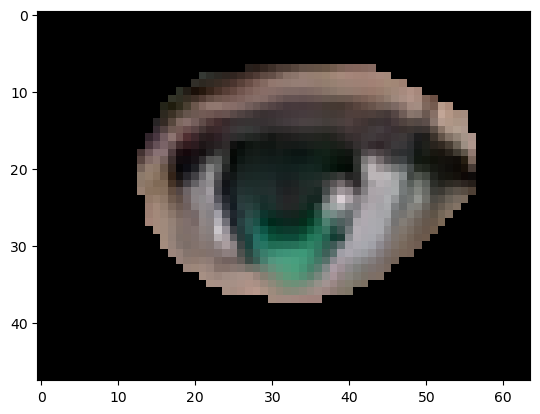

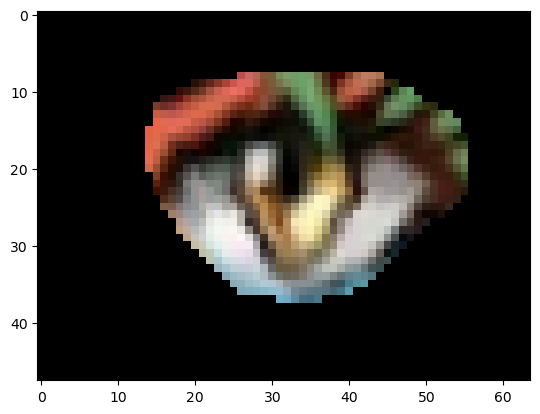

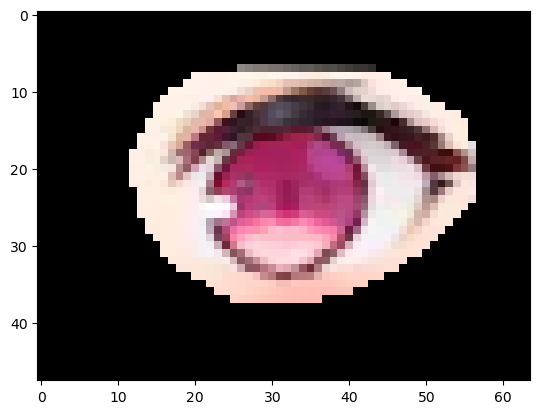

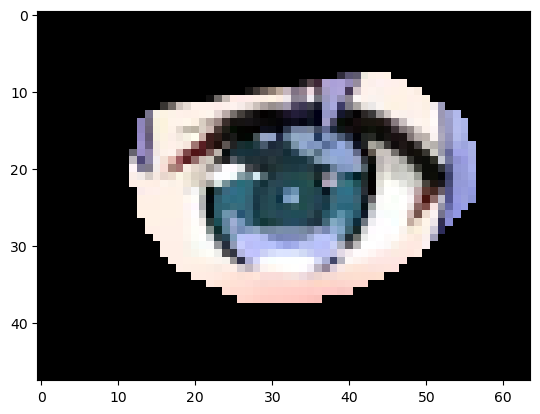

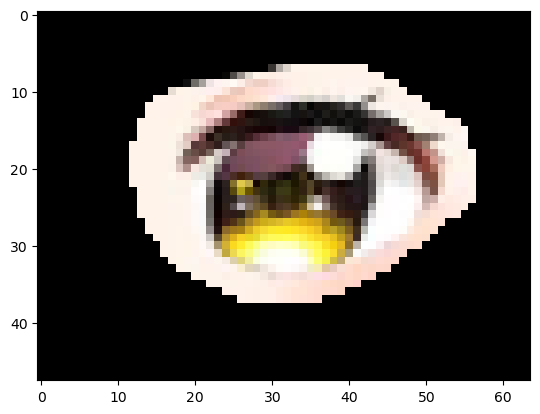

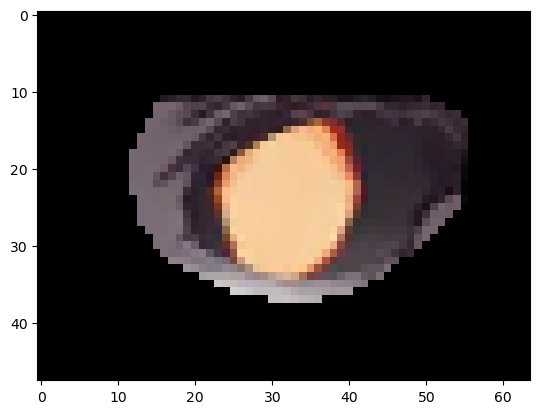

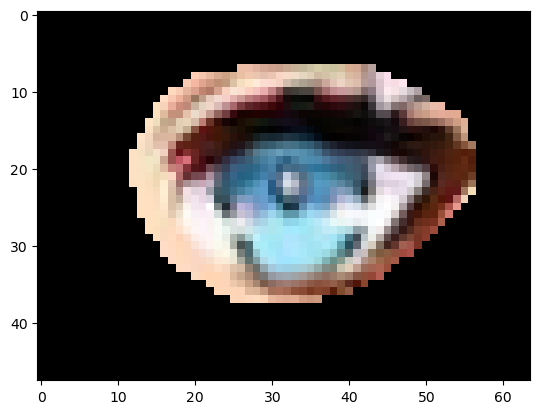

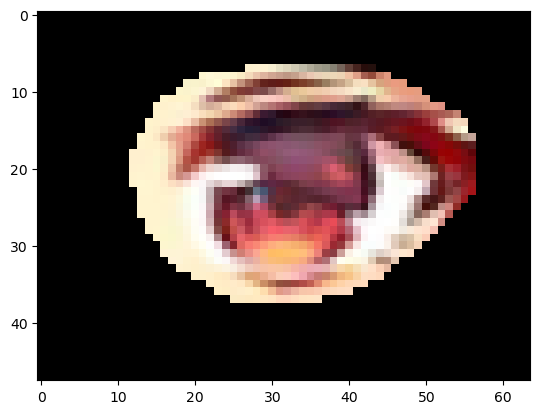

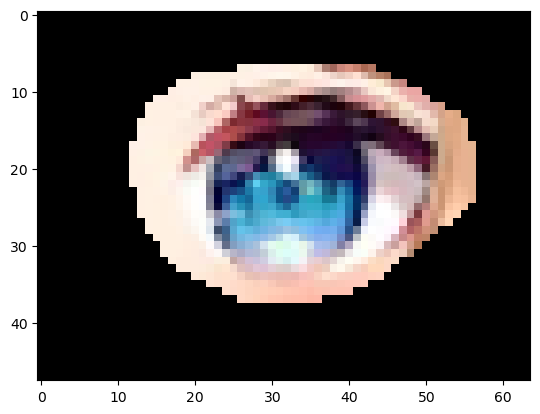

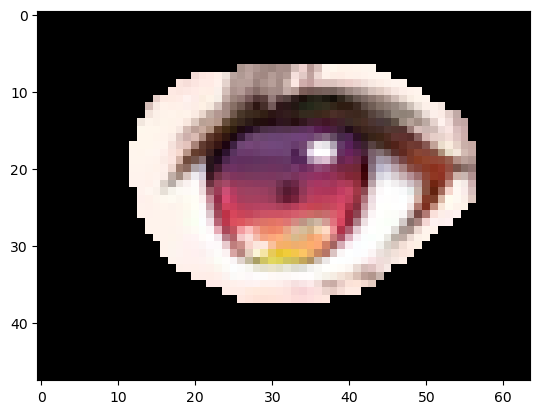

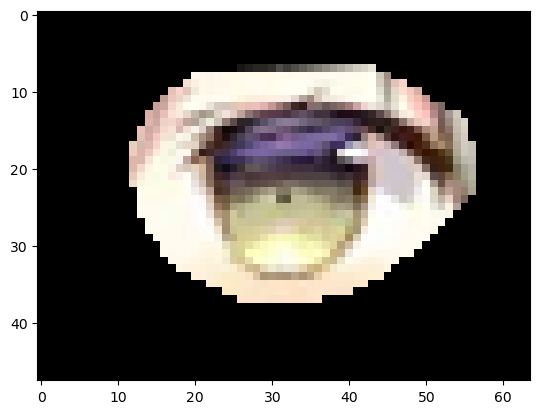

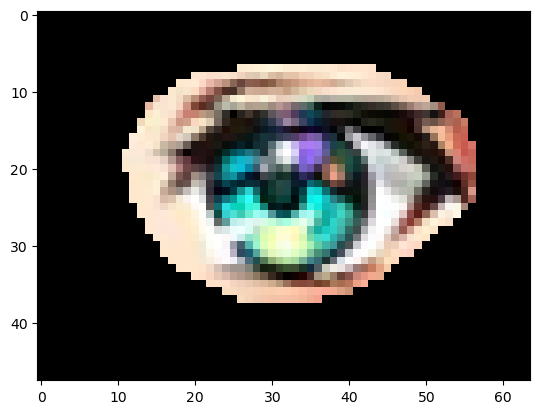

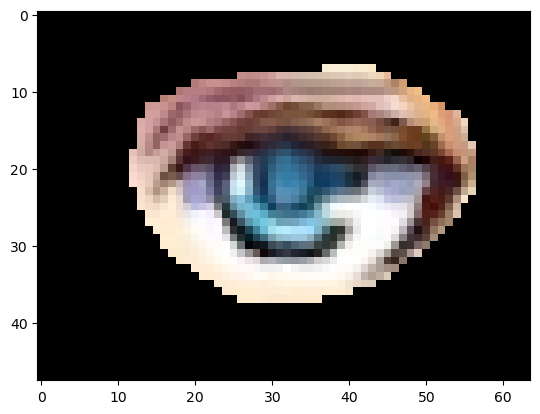

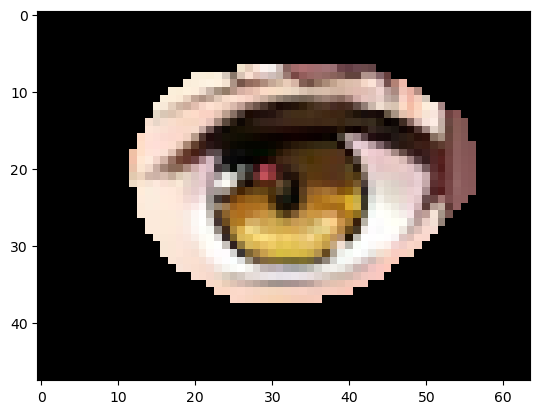

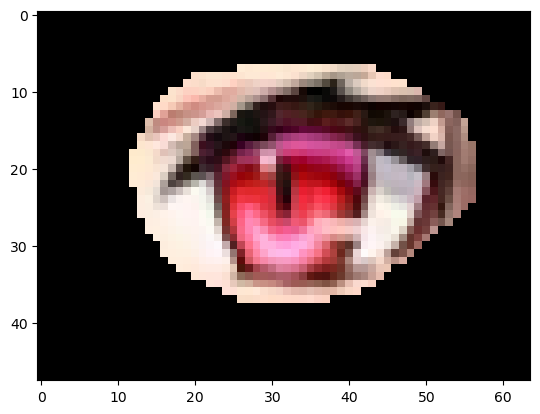

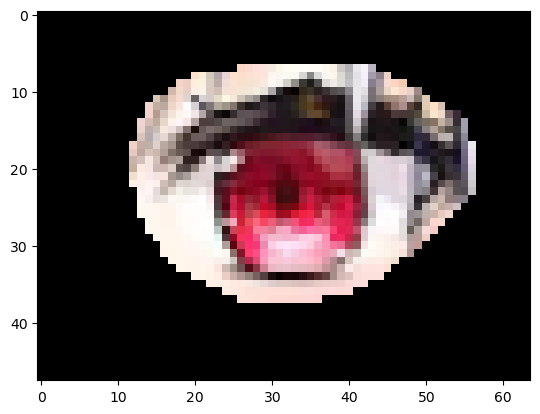

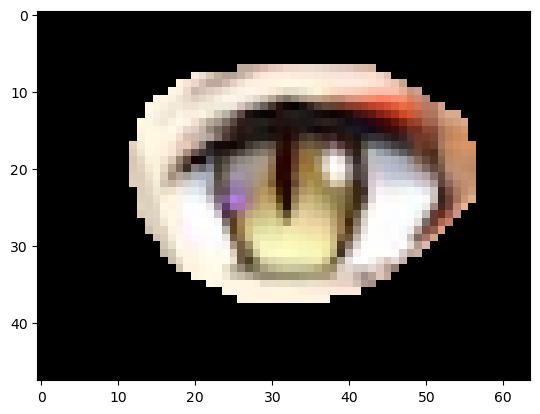

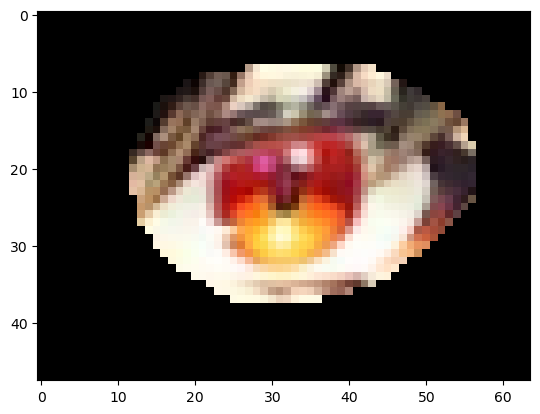

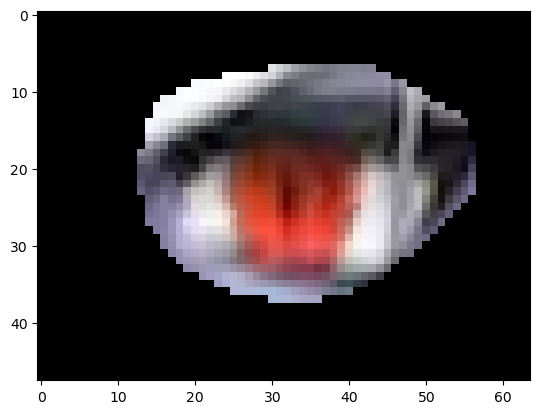

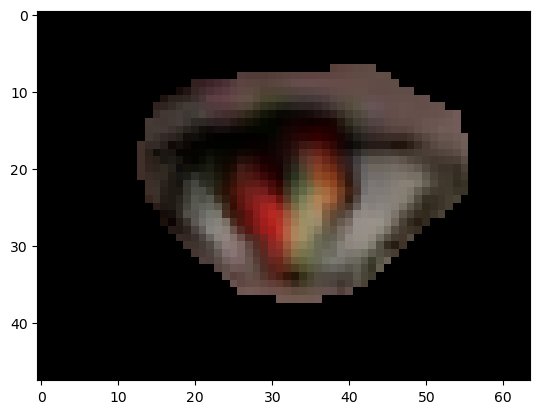

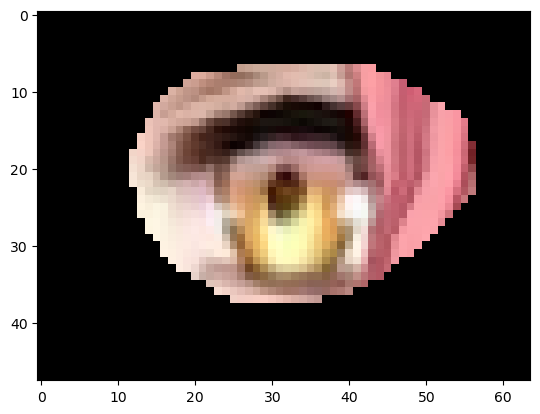

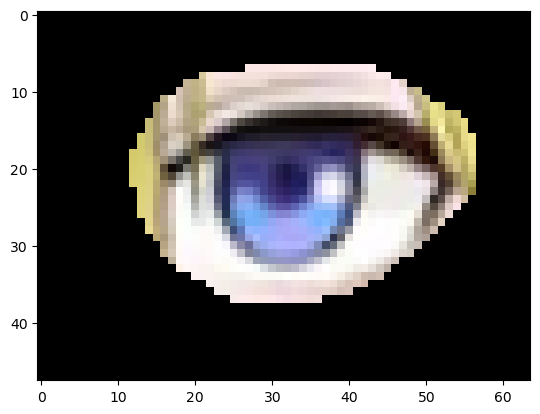

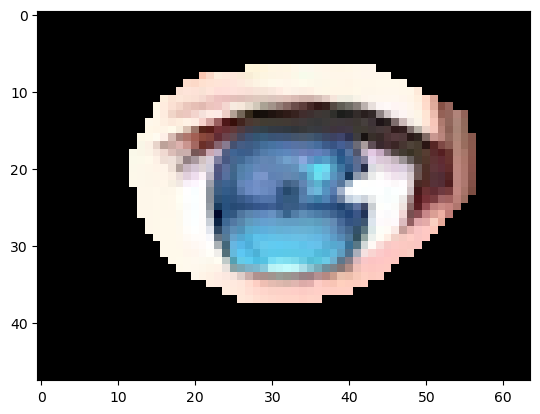

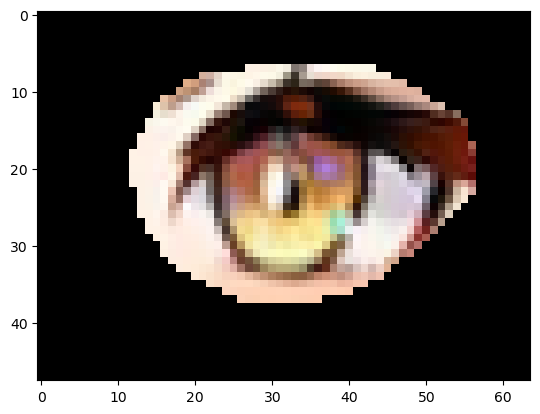

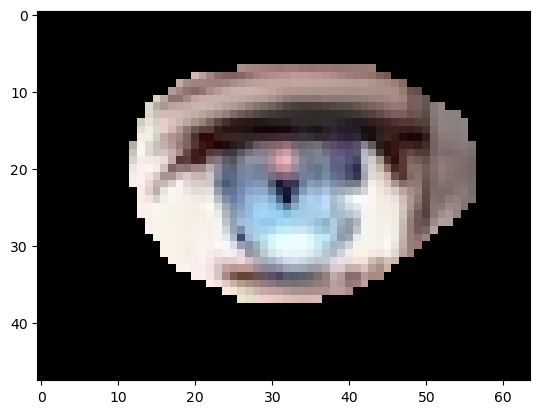

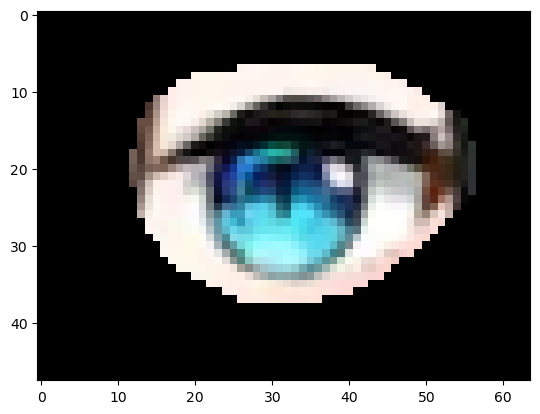

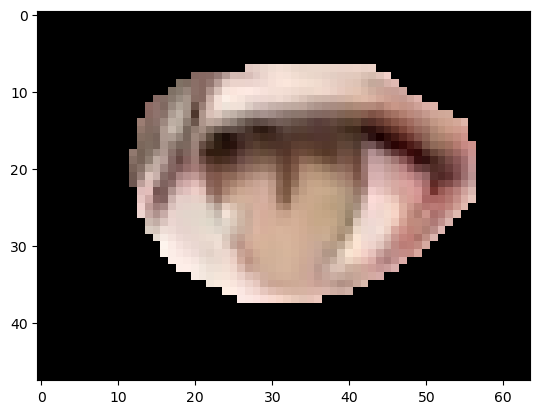

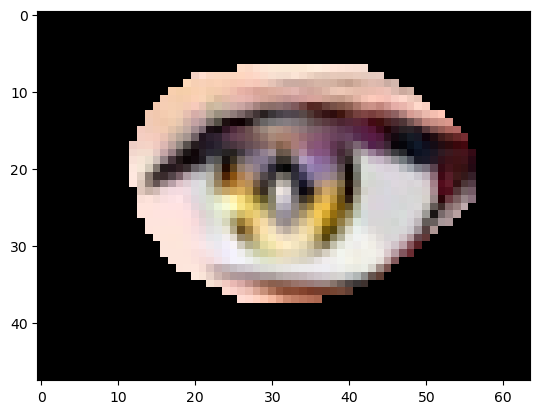

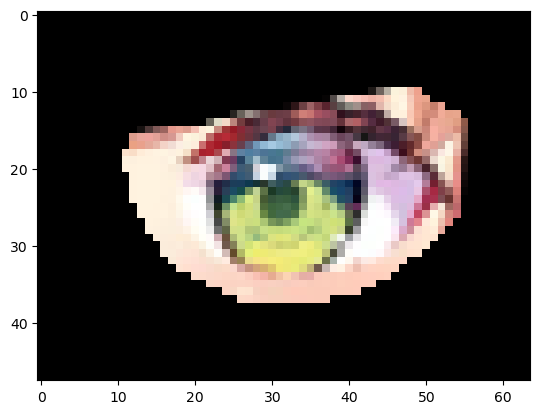

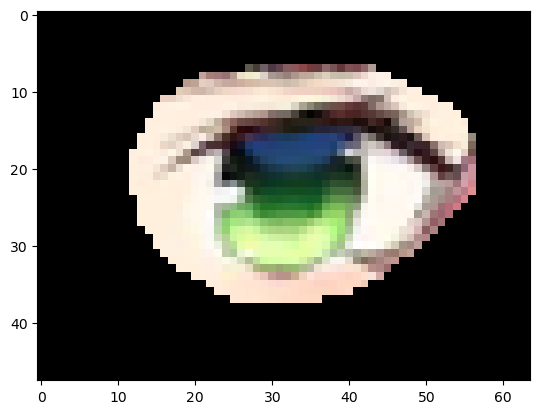

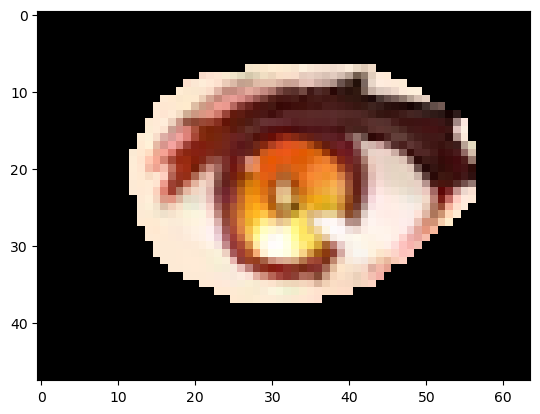

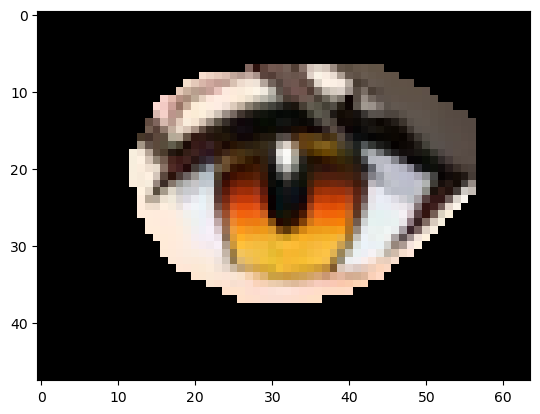

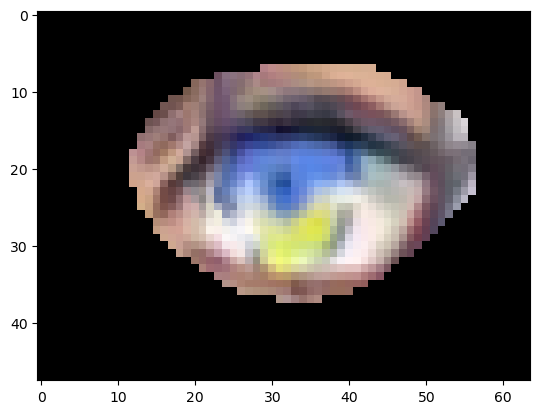

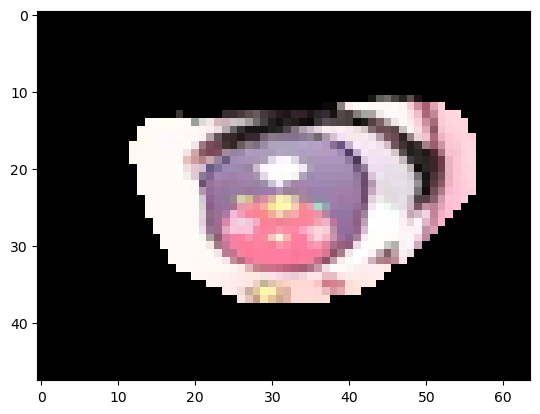

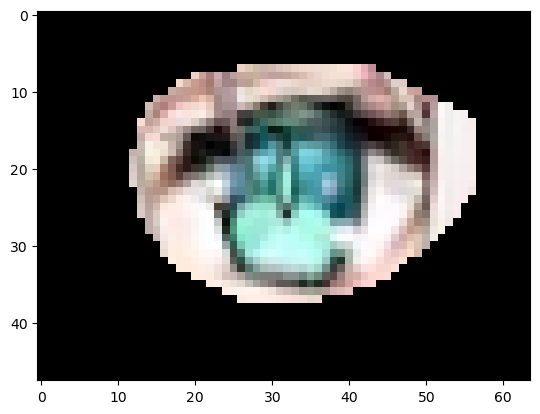

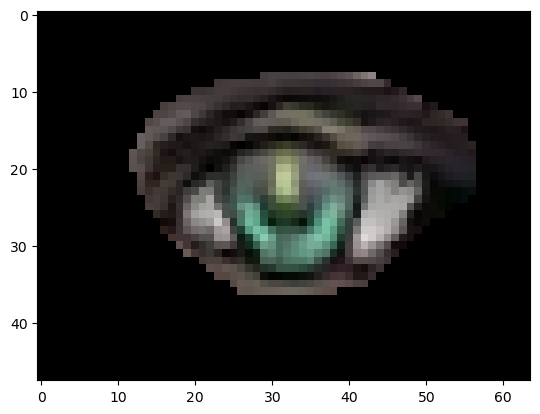

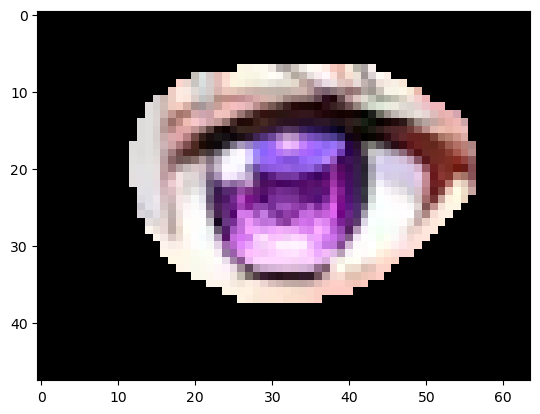

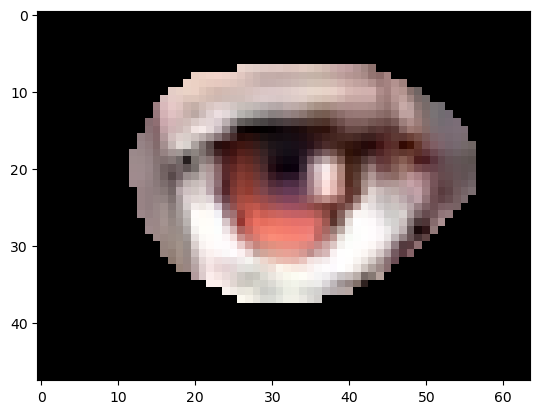

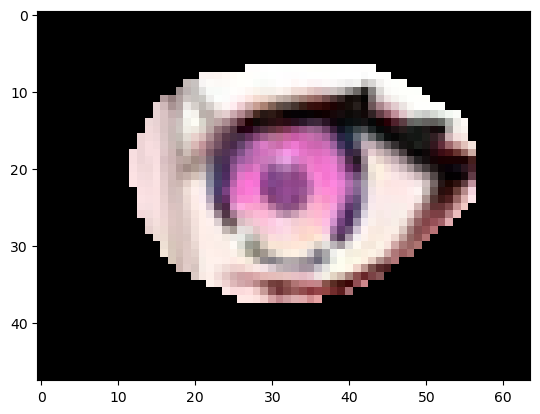

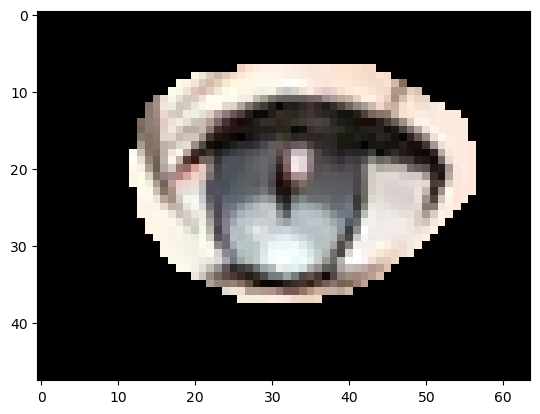

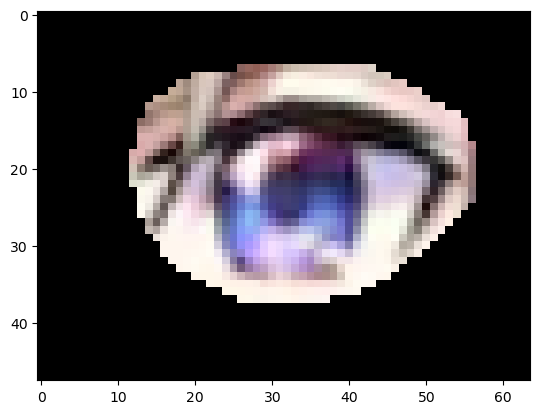

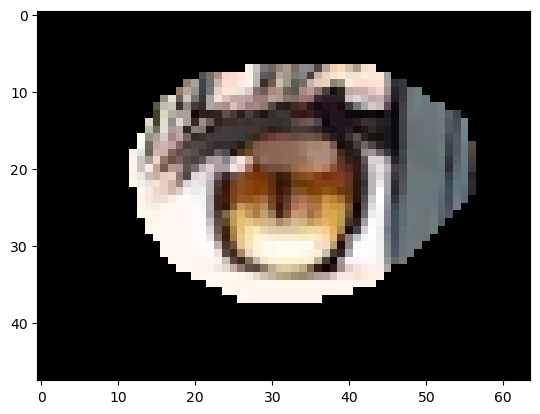

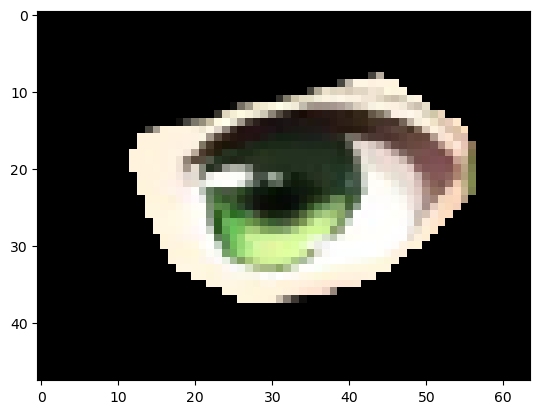

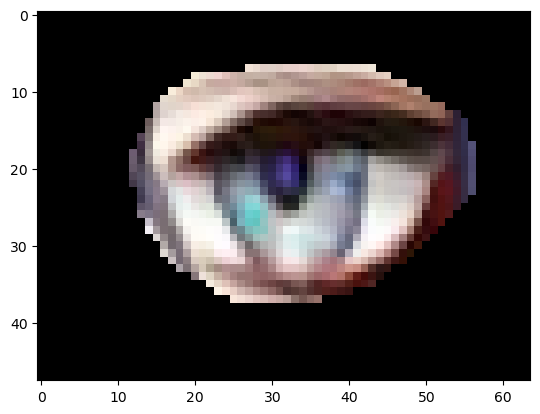

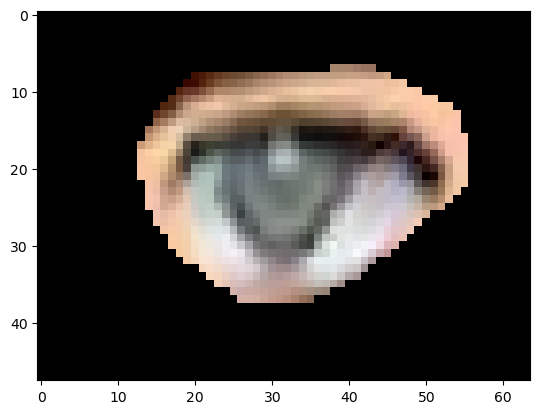

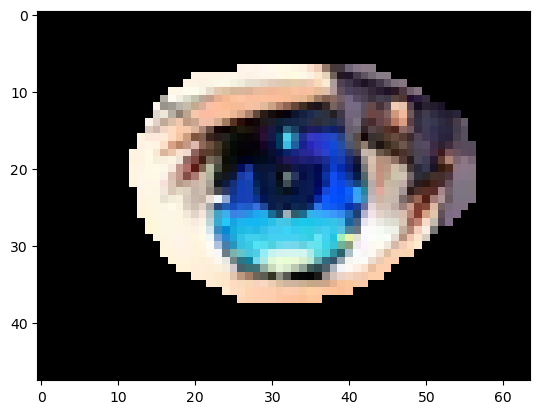

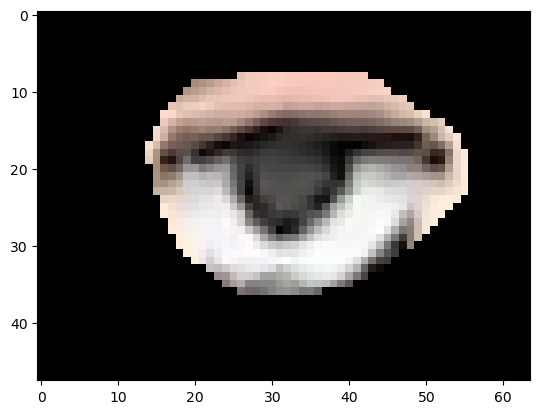

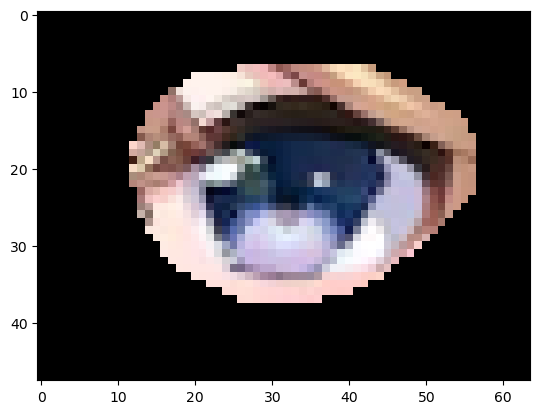

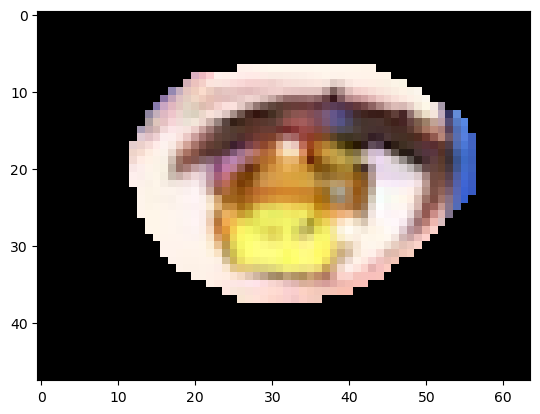

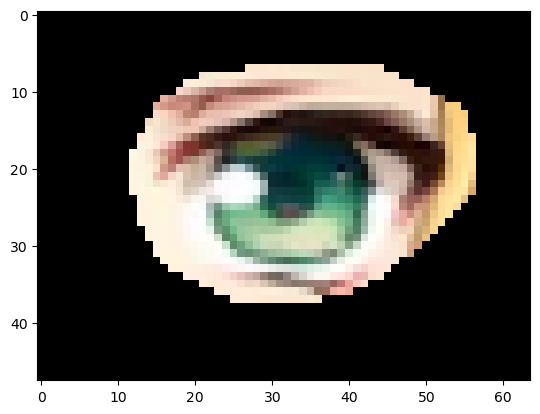

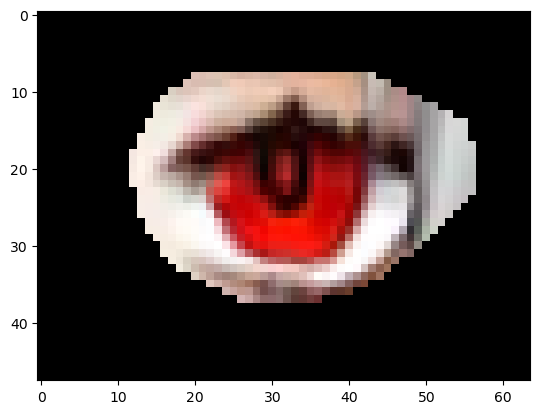

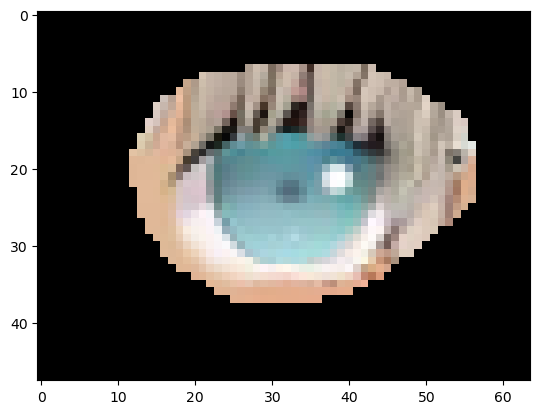

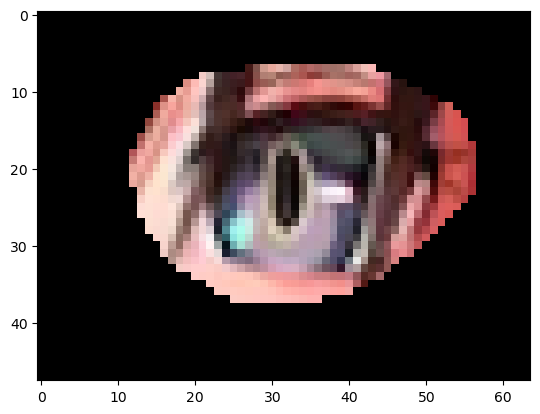

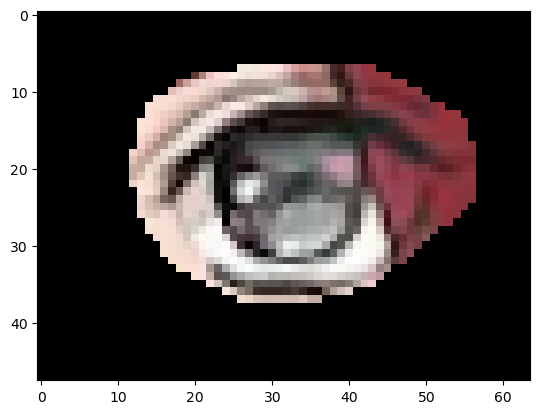

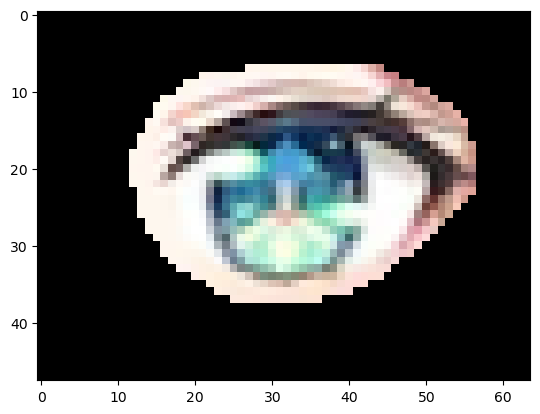

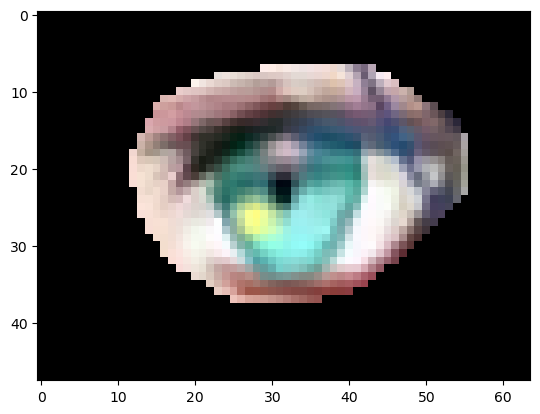

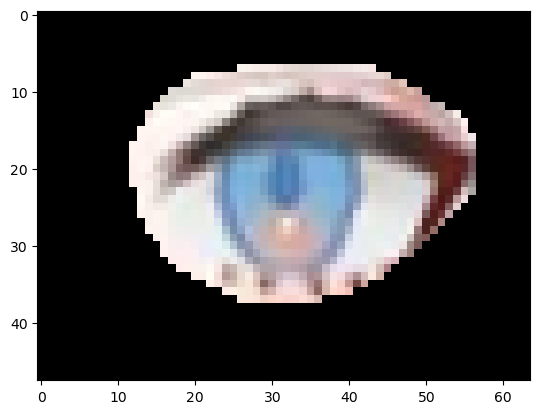

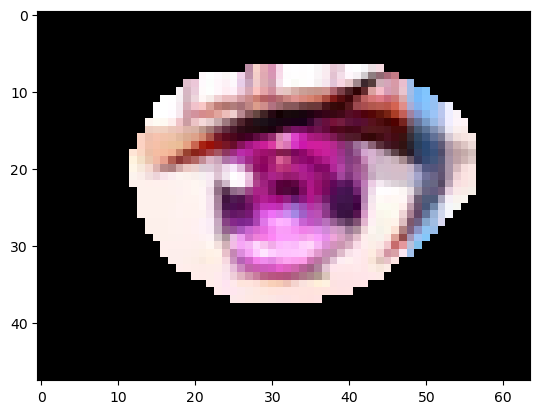

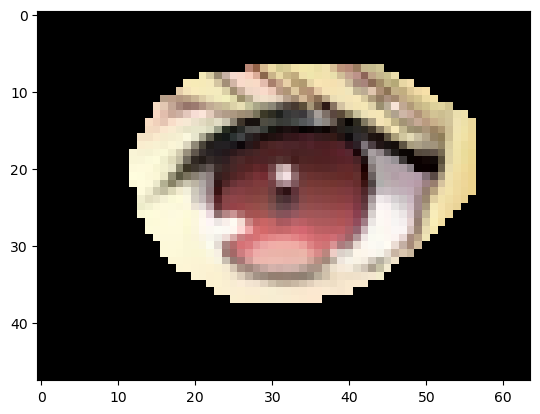

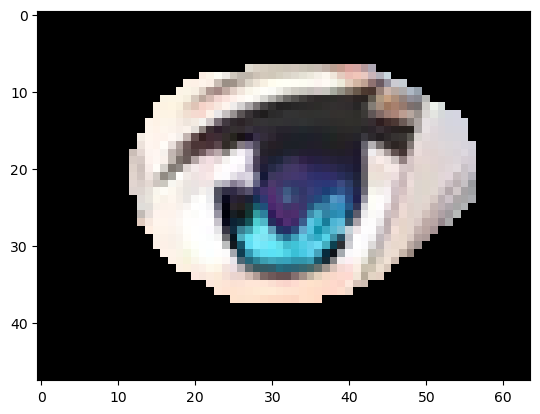

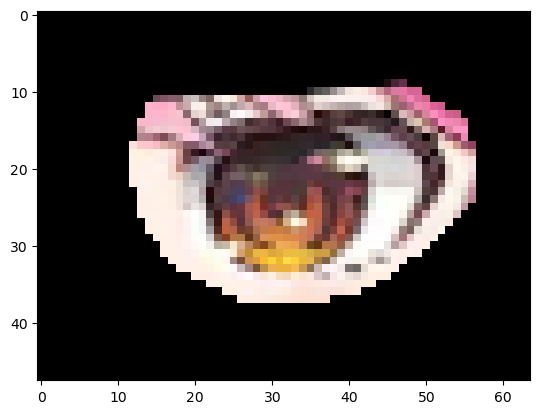

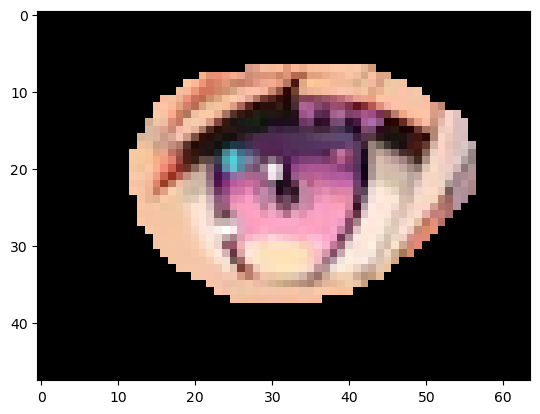

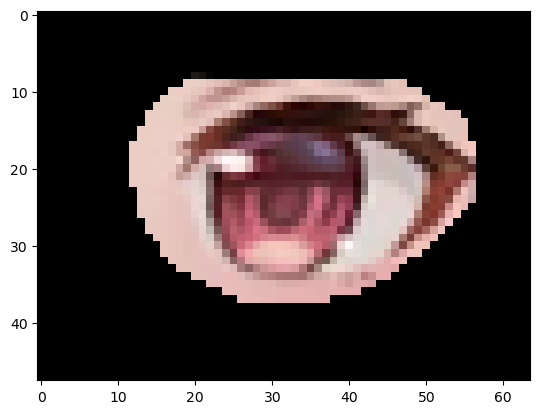

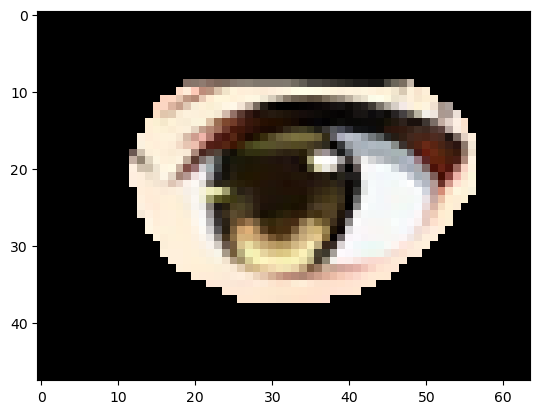

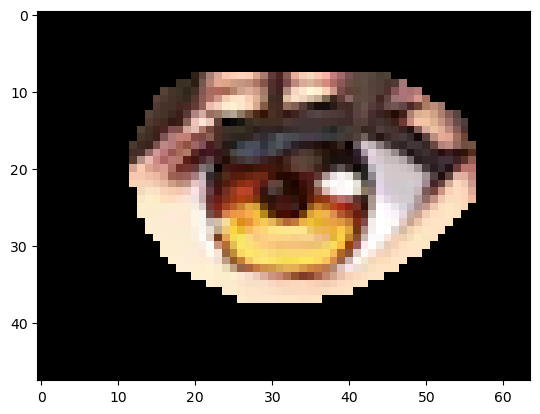

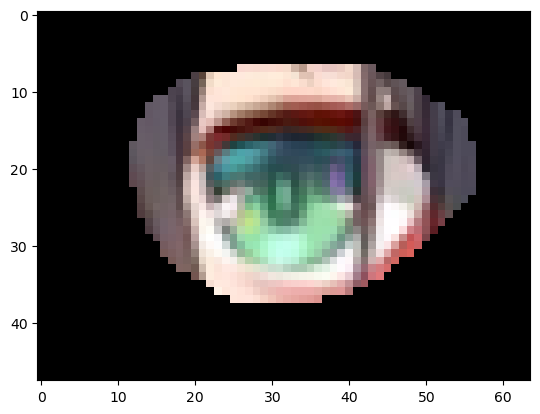

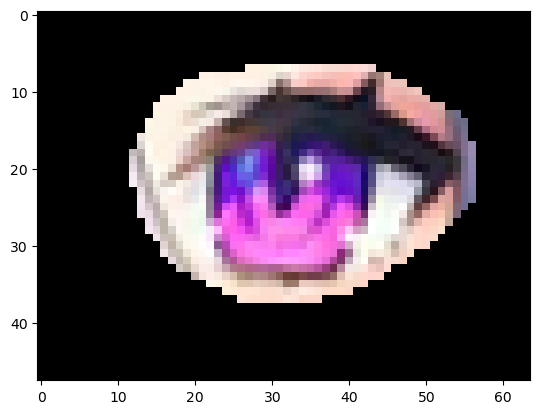

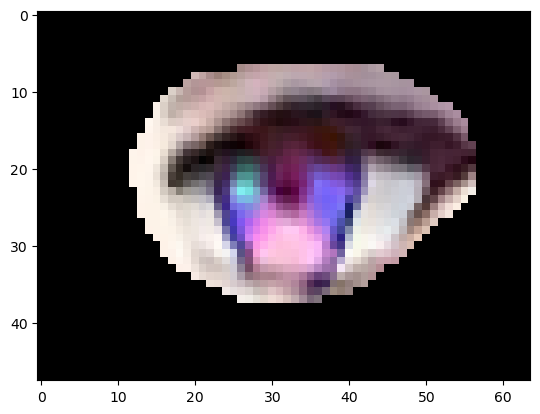

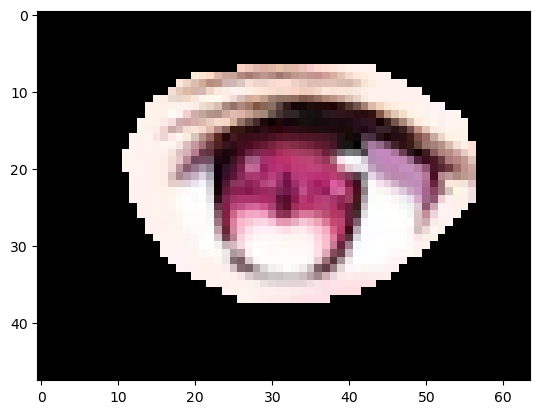

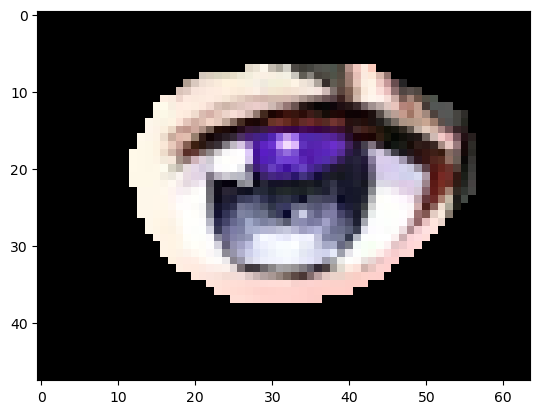

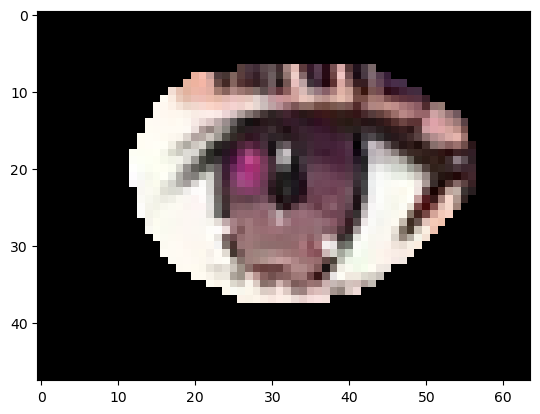

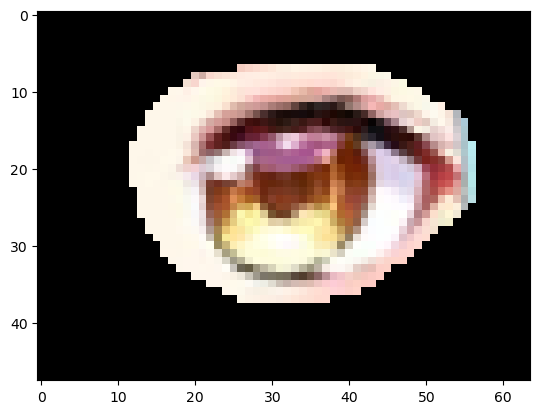

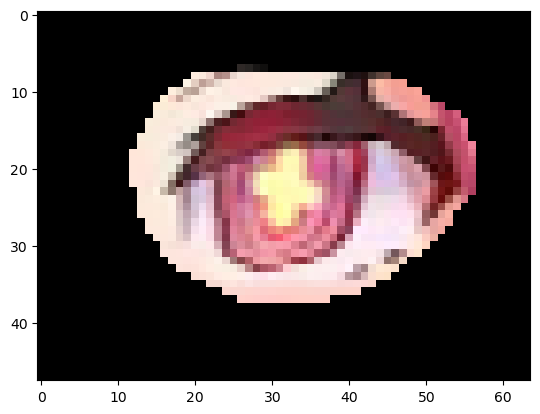

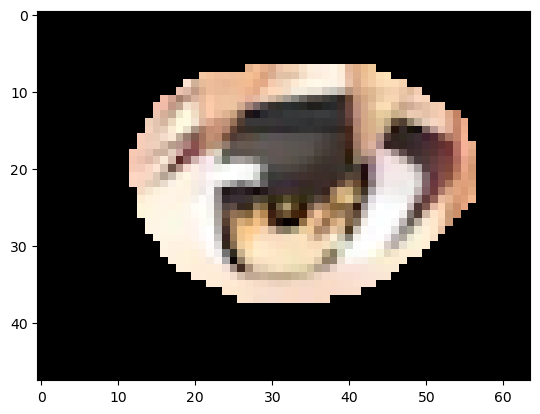

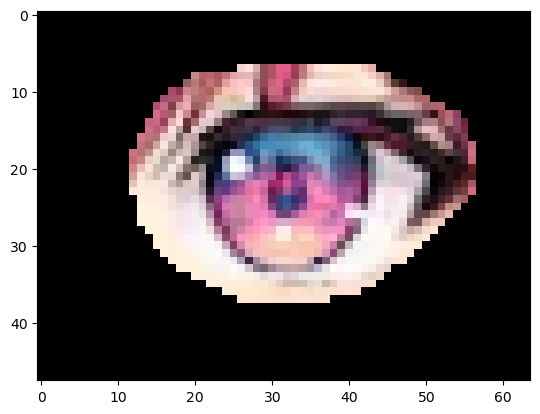

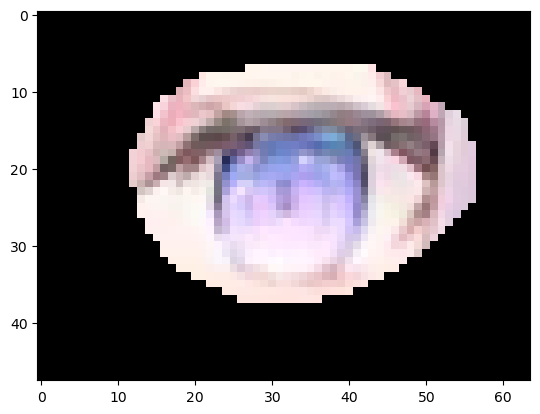

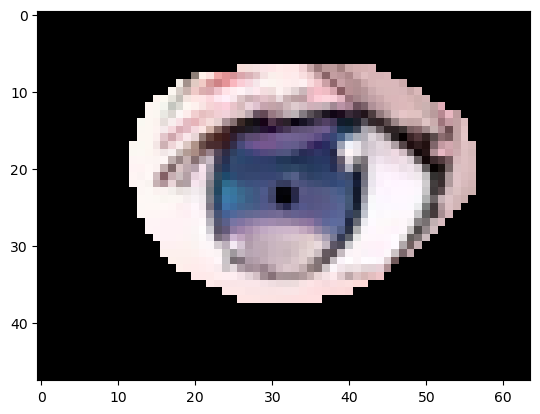

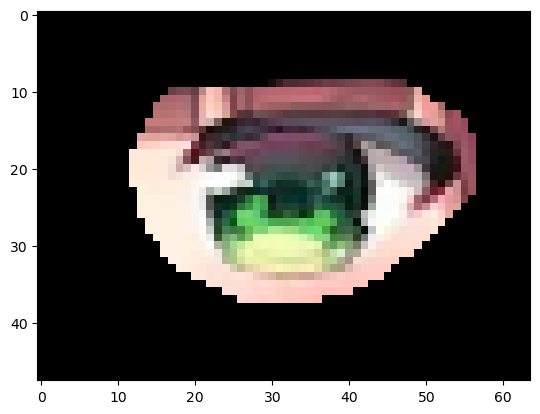

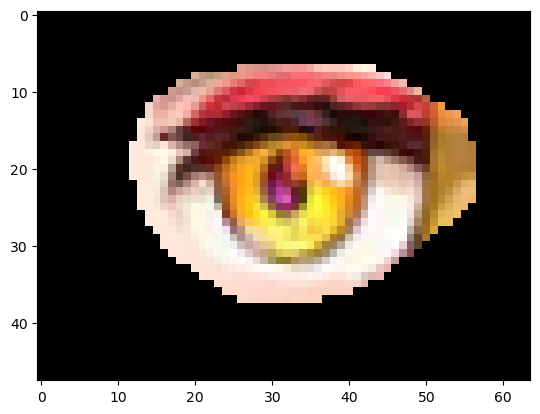

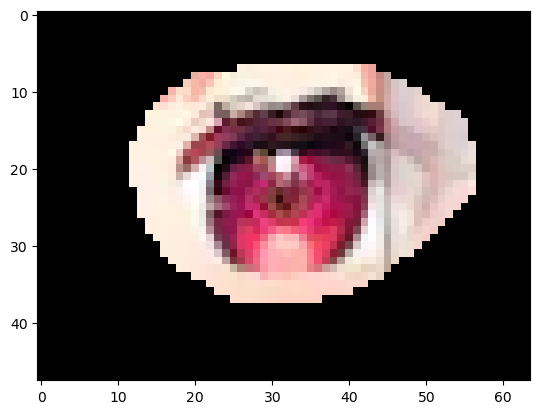

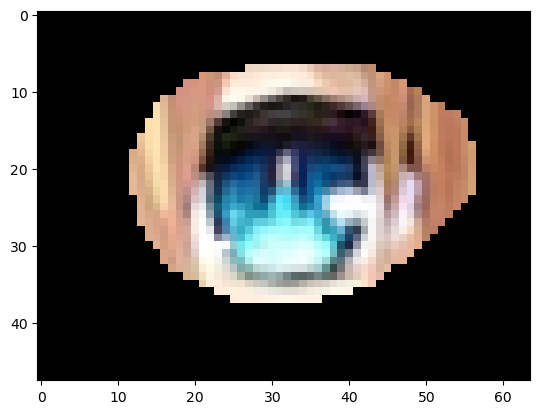

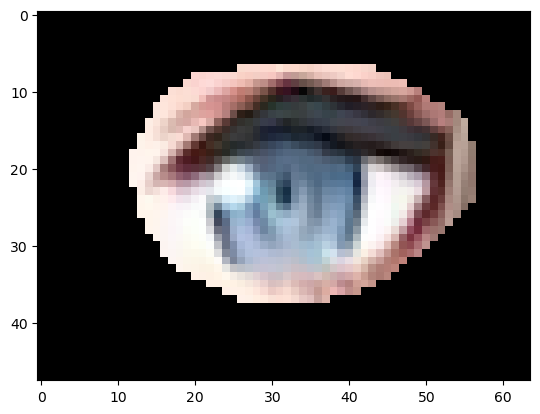

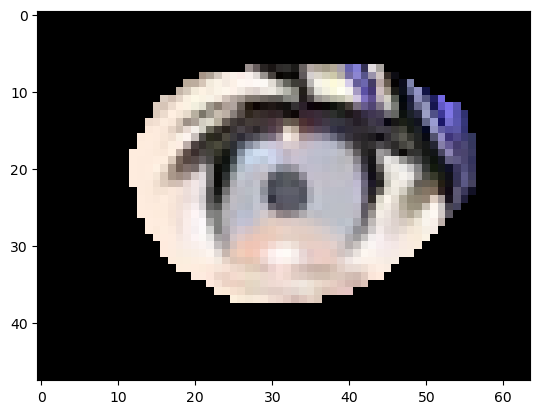

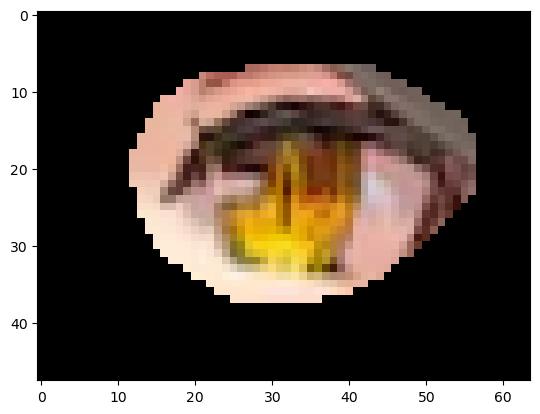

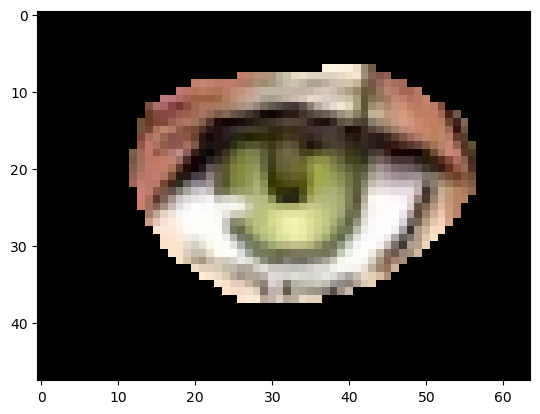

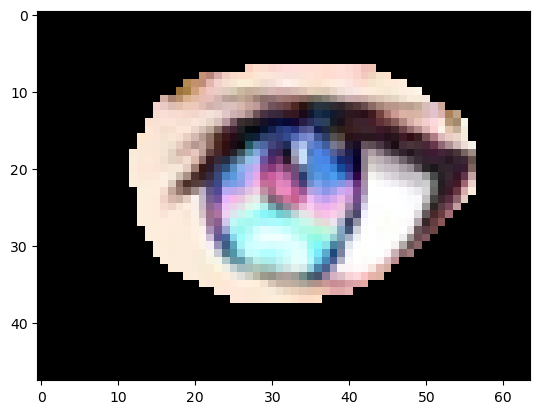

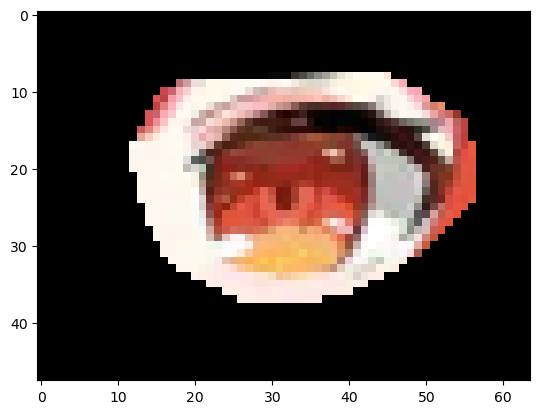

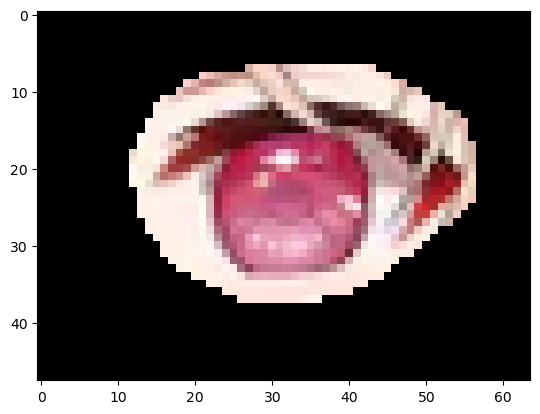

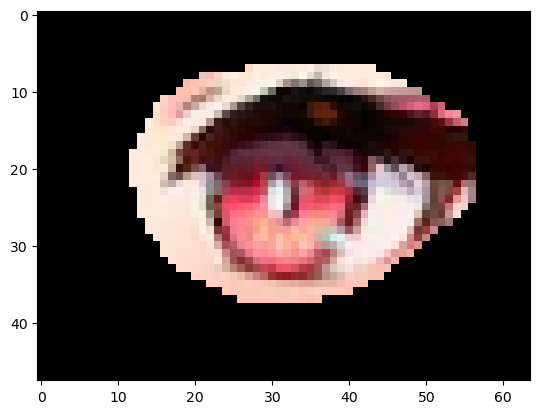

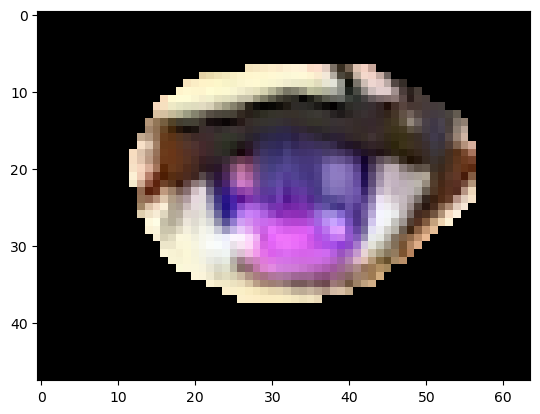

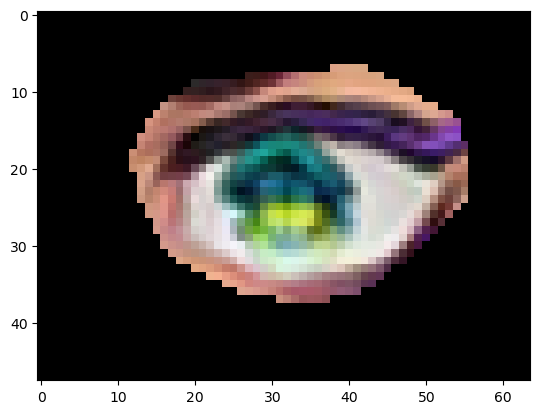

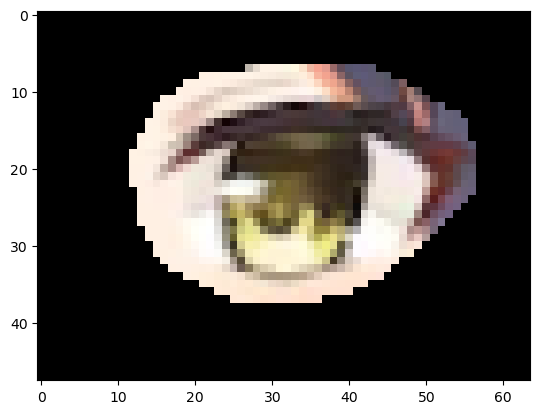

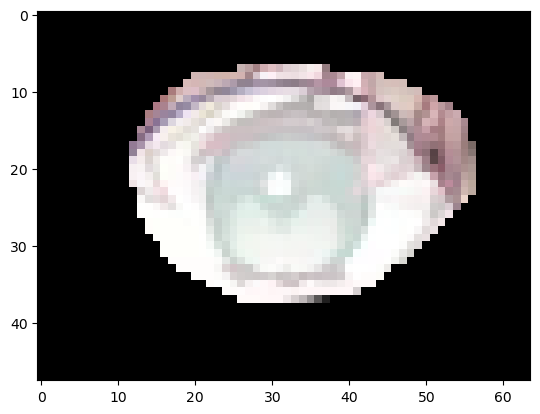

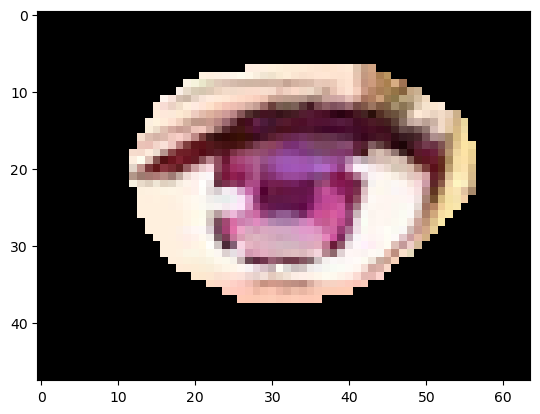

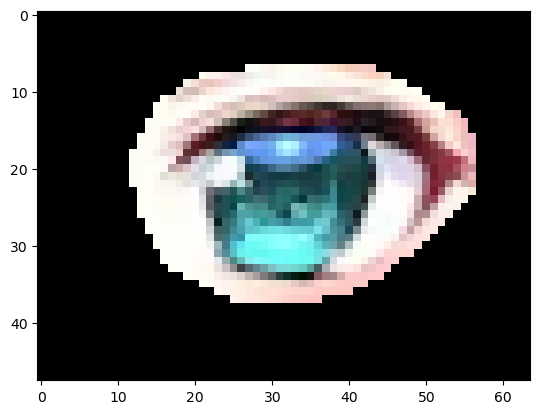

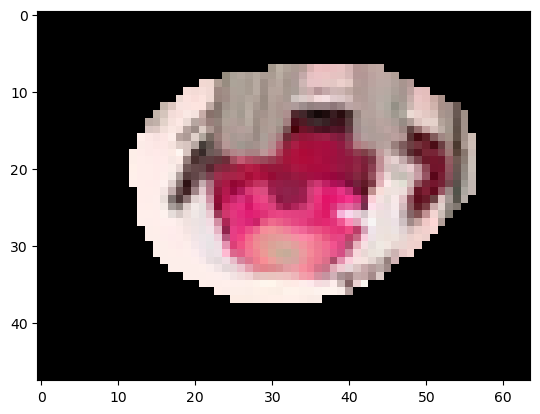

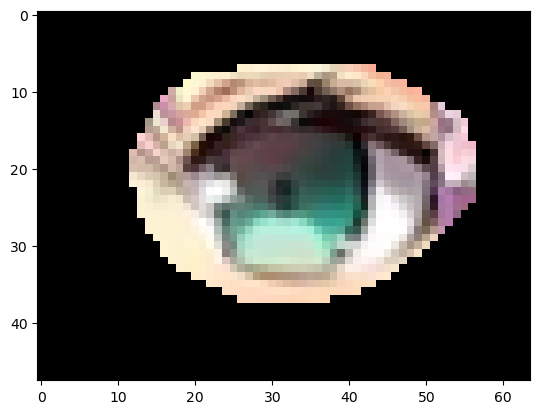

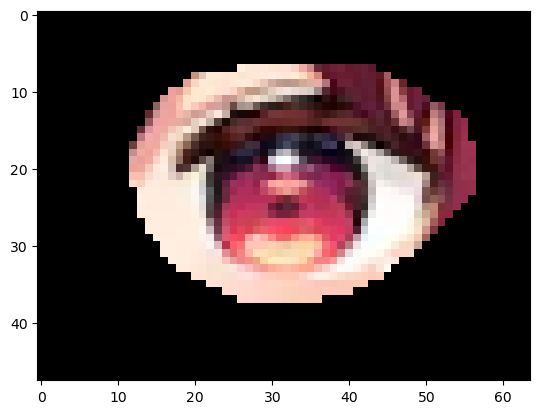

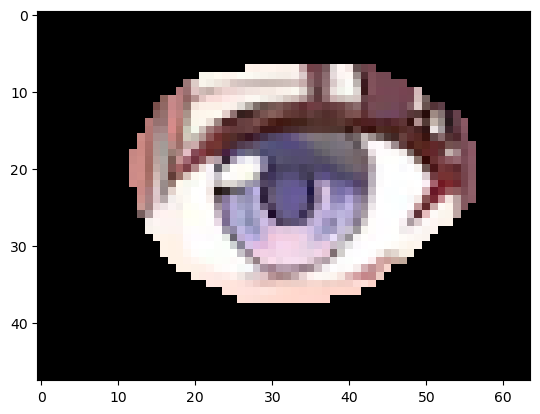

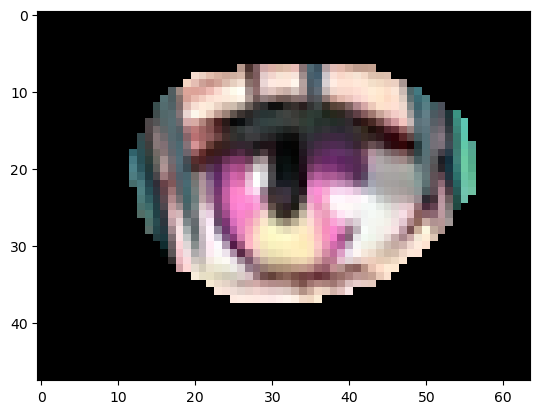

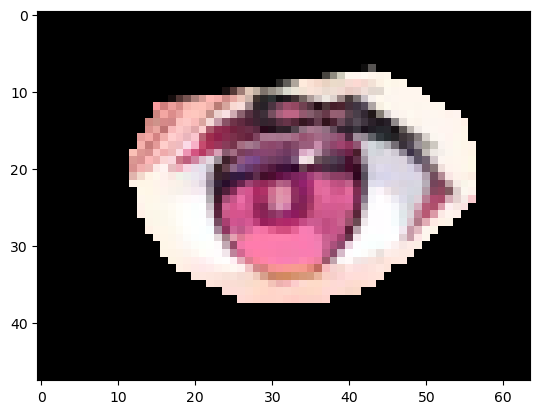

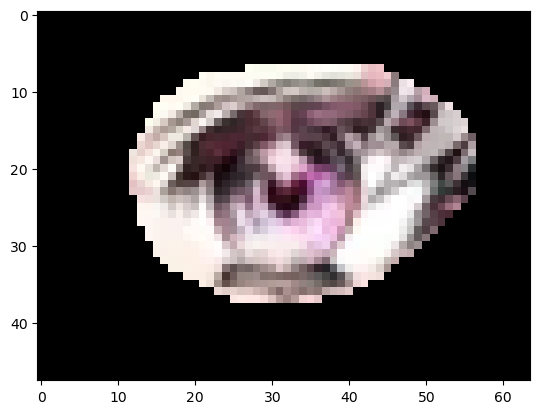

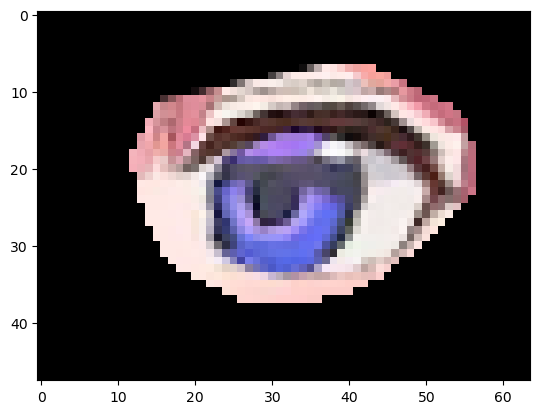

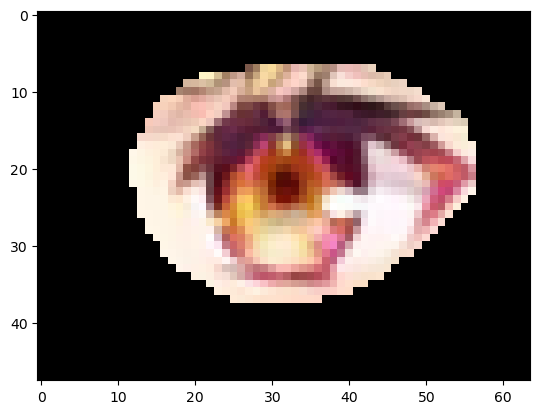

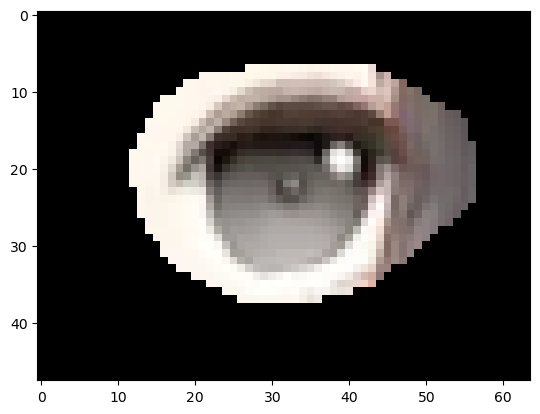

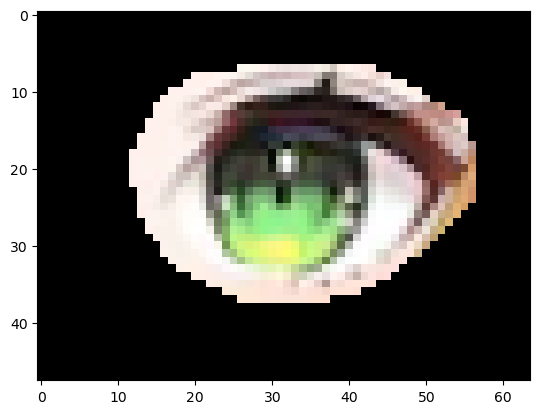

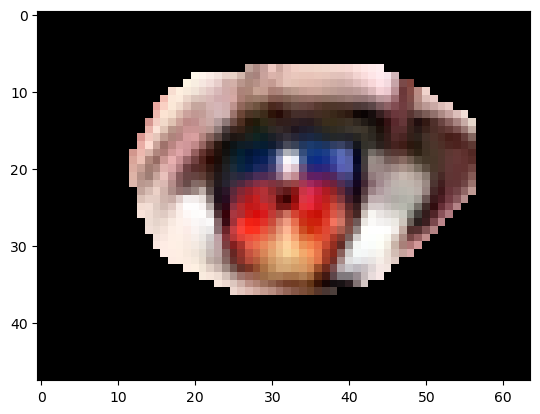

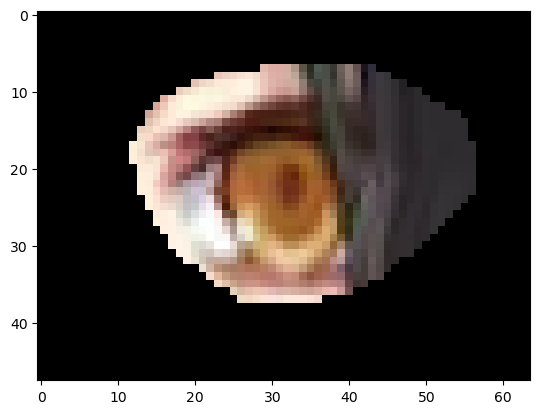

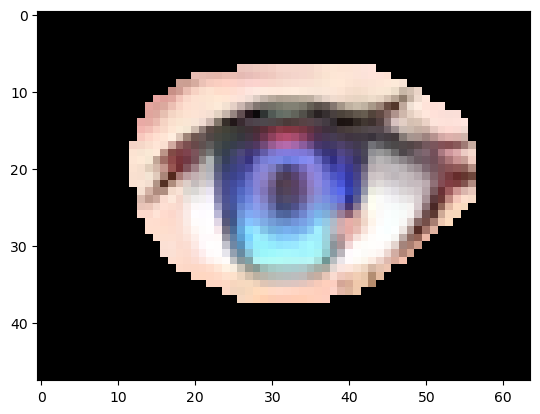

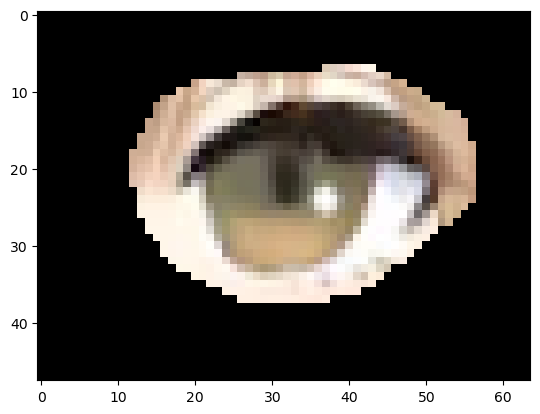

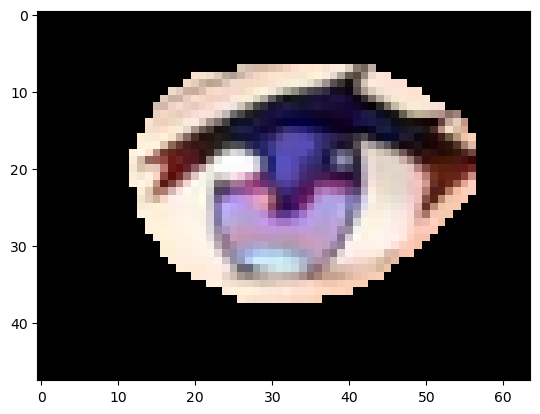

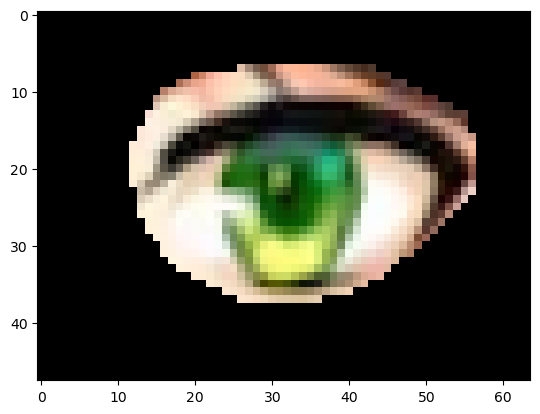

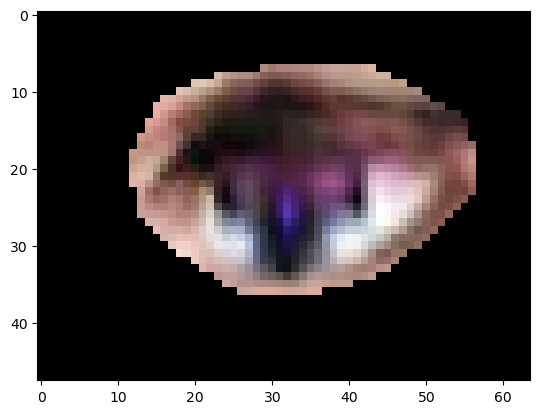

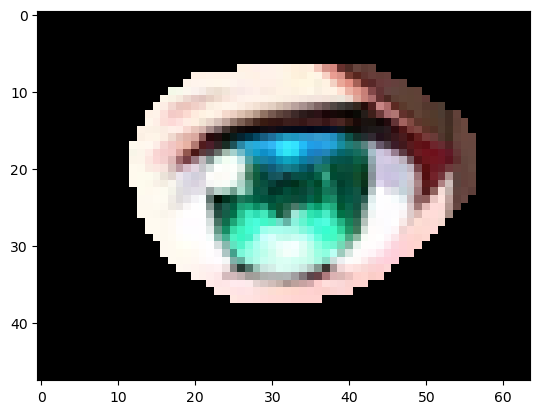

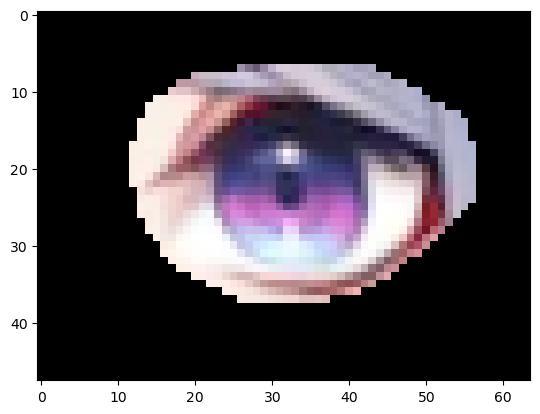

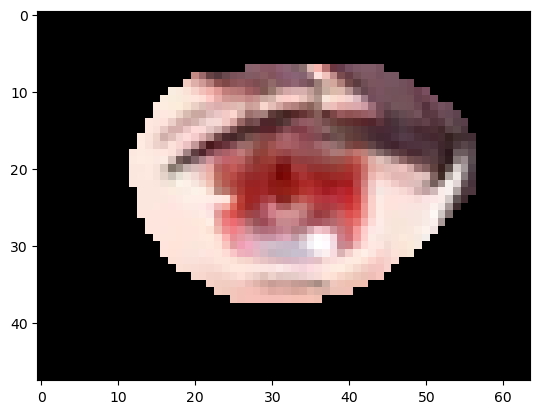

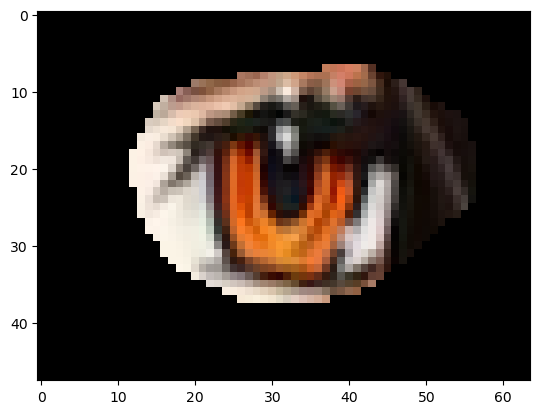

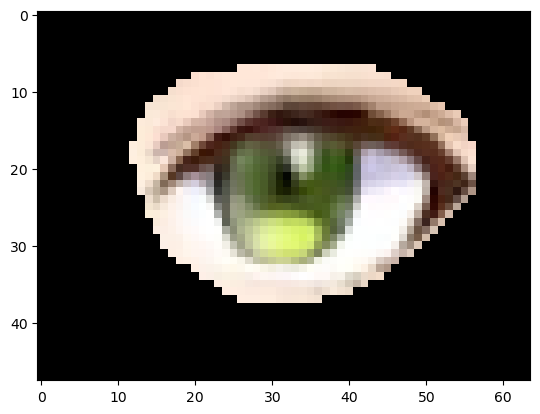

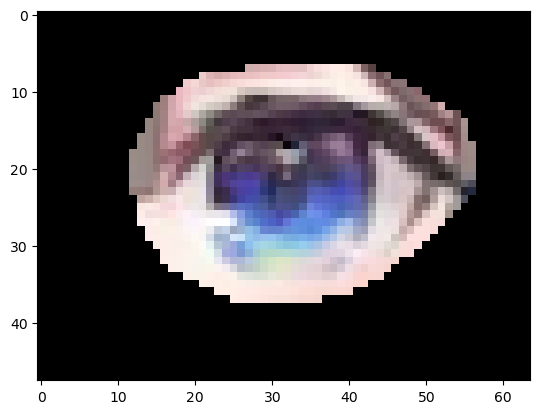

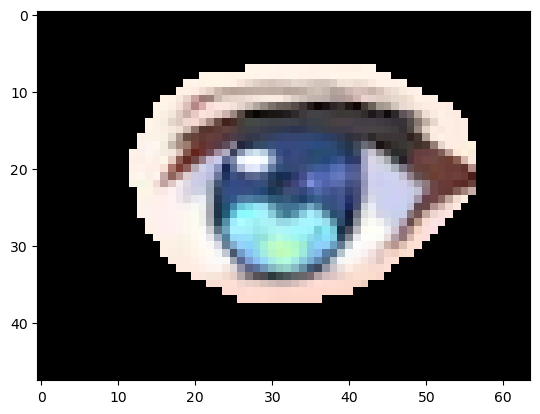

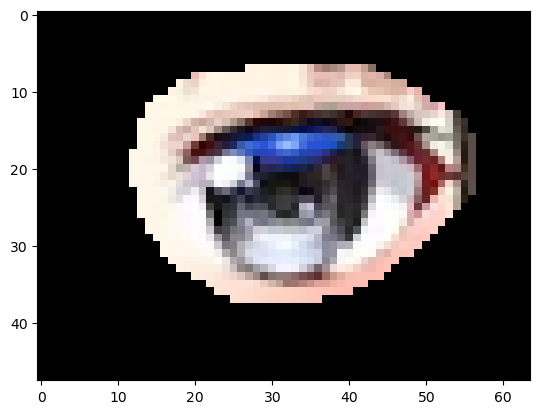

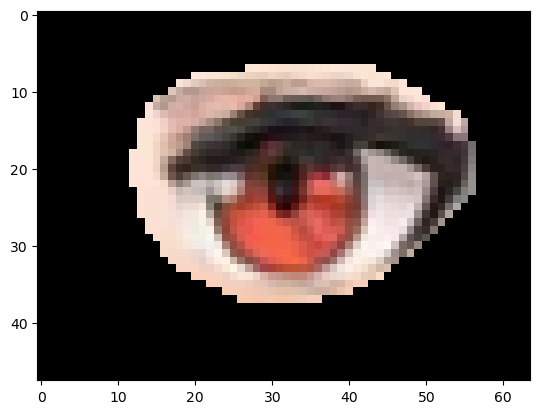

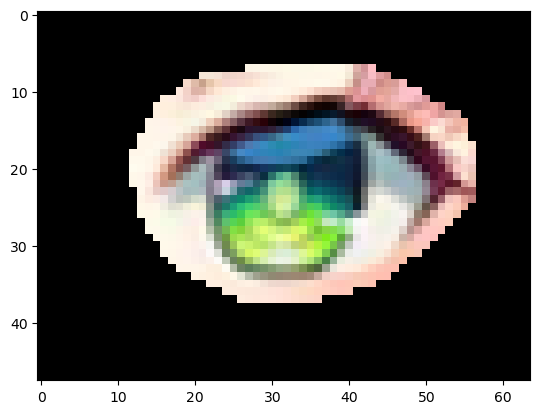

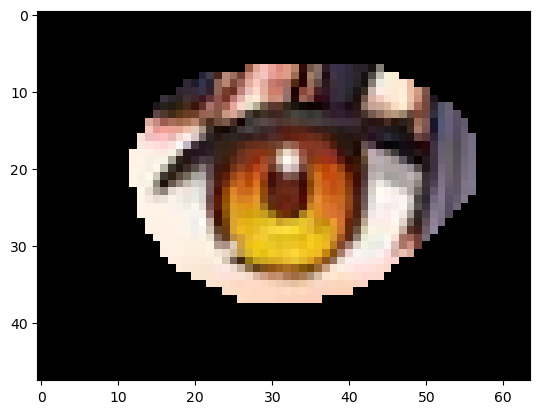

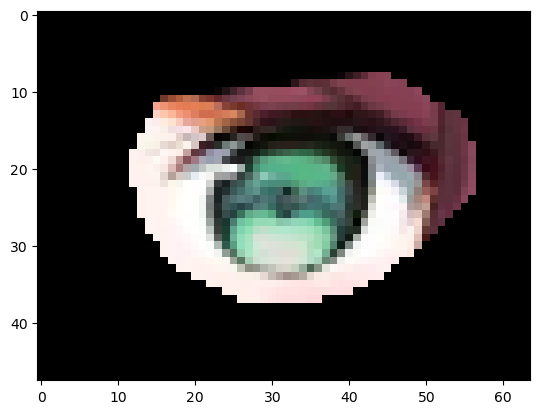

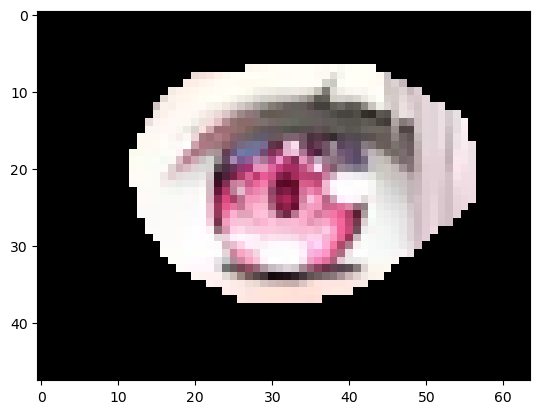

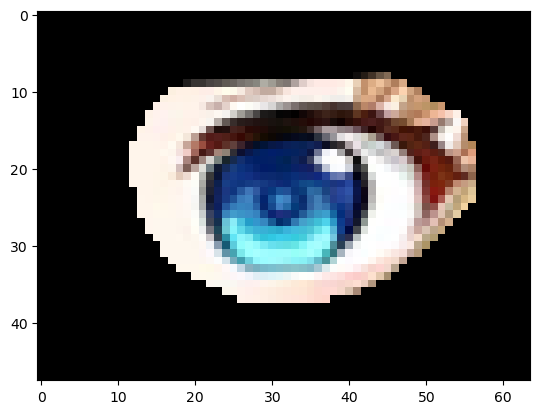

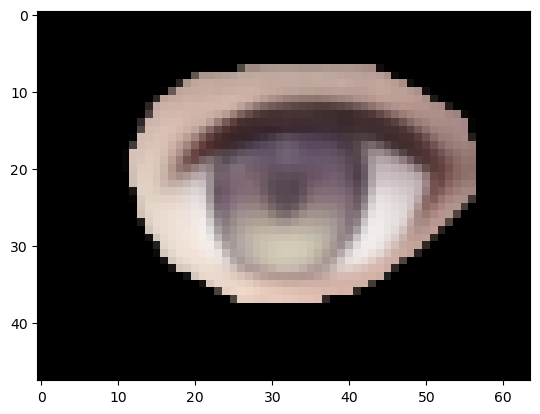

In [159]:
avgEye = np.zeros_like(img1)*(1.0)
eyeDatas = []
handleDatas = []
handCoeff = 300

for i in range(N):
    
    if i == 84 or i == 122 or i == 123:
        continue
    
    tex = cv2.imread('data_eyes/'+ str(i+1).zfill(3)+ '.png')
    eyeMesh = mesh2(64,48, tex)
    eyeMesh.setHandlesOrg(handlesArr[i])
    eyeMesh.setHandlesDfm(handlesAvg)
    eyeMesh.applyHandles()
    
    newImg = eyeMesh.deform()
    
    avgEye += newImg/1
    
    plt.imshow(cv2.cvtColor(newImg, cv2.COLOR_BGR2RGB)) # OpenCV は色がGBR順なのでRGB順に並べ替える
    plt.show()
    
    eyeVec = newImg.reshape(48*64*3)
    
    handleVec = handlesArr[i].reshape(H*1*2) * handCoeff
    
    eyeData = np.append(eyeVec, handleVec)
    
    eyeDatas.append(eyeData)
    handleDatas.append(handleVec)
    
avgEye = avgEye / (N-3)

avgEye = avgEye.astype(np.uint8)

eyeDatas = np.array(eyeDatas)

plt.imshow(cv2.cvtColor(avgEye, cv2.COLOR_BGR2RGB)) # OpenCV は色がGBR順なのでRGB順に並べ替える
plt.show()
#cv2.imwrite('output/avgEye_5p.png', avgEye)

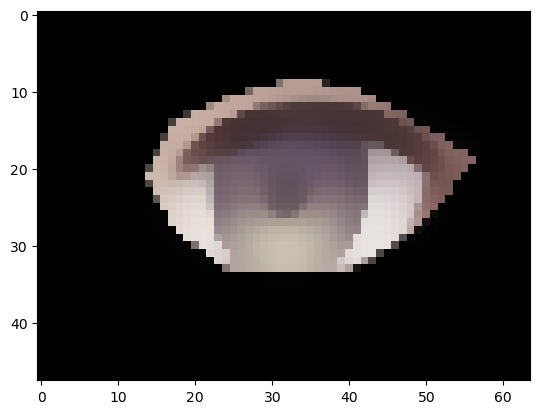

In [13]:
avgEyeFilt = avgEye
for i in range(3):
    avgEyeFilt = br_filter = cv2.bilateralFilter(avgEyeFilt,  # 入力画像
                                    5,  # 注目画素の周辺領域（値が大きいほどぼかしが強くなる）
                                    50,  # 色空間の標準偏差
                                    15    # 距離空間の標準偏差
                                   )

plt.imshow(cv2.cvtColor(avgEyeFilt, cv2.COLOR_BGR2RGB)) # OpenCV は色がGBR順なのでRGB順に並べ替える
plt.show()

In [104]:
# ファイル名変更
for i in range(N):
    
    if i == 84 or i == 122 or i == 123:
        continue
        
    img = cv2.imread('data_eyes_p3/'+ str(i+1).zfill(3)+ '.png')
    cv2.imwrite('data_eyes_p3/'+ str(i+1).zfill(3)+ '_p3.png', img)

In [85]:
def freqDatas(gray, level):
    datas = []
    shapes = []
    coeffs = pywt.wavedec2(gray, 'bior1.3', level=level)
    for i in range(level+1):
        datas.append(np.array(coeffs[i]).reshape(np.prod(np.array(coeffs[i]).shape)))
        shapes.append(np.array(coeffs[i]).shape)
        
    return datas, shapes

In [86]:
def recovFreqDatas(datas, shapes):
    coeffs = []
    for data, shape in zip(datas, shapes):
        coeff = data.reshape(shape)
        if len(shape) == 2:
            coeffs.append(coeff)
        else:
            temp = []
            for i in range(shape[0]):
                temp.append(coeff[i])
            coeffs.append(tuple(temp))
            
    coeffs = tuple(coeffs)
    img = pywt.waverec2(coeffs,'bior1.3')
    return img

In [242]:
# 多重ウェーブレット データ加工
N = 143
level = 2

datasArr = [[] for i in range(level+1)]

for i in range(N):
    
    if i == 84 or i == 122 or i == 123:
        for i in range(level+1):
            datasArr[i].append("")
        continue
    tex = cv2.imread('data_eyes/'+ str(i+1).zfill(3)+ '.png')
    eyeMesh = mesh2(64,48, tex)
    eyeMesh.setHandlesOrg(handlesArr[i])
    eyeMesh.setHandlesDfm(handlesAvg)
    eyeMesh.applyHandles()
    
    newImg = eyeMesh.deform()
    
    newImg = cv2.cvtColor(newImg, cv2.COLOR_BGR2YCrCb)
    
    Y, Cr, Cb = cv2.split(newImg)
    
    datasY, shapesY = freqDatas(Y, level)
    datasCr, shapesCr = freqDatas(Cr, level)
    datasCb, shapesCb = freqDatas(Cb, level)
    
    for i in range(level+1):
        data = np.concatenate([datasY[i], datasCr[i], datasCb[i]])
        datasArr[i].append(data)

In [50]:
# 多重ウェーブレット データ加工
avgDatas = []
datasCenterArr = []
for datas in datasArr:
    avgData = np.sum(datas, axis=0) / (N-3)
    avgDatas.append(avgData)
    datasCenterArr.append(datas - avgData)

C:\Users\souta\anaconda3\envs\exp3\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('float64'), dtype('<U1')) -> None

In [13]:
# 多重ウェーブレット 固有値計算
dataEigs = []
for datas in datasCenterArr:
    covMat = np.cov(datas.T)
    dataEigs.append(np.linalg.eig(covMat))

In [14]:
np.save('saves/eigValLev2L_13p', dataEigs[0][0].real)
np.save('saves/eigVecLev2L_13p', dataEigs[0][1].real.T)

np.save('saves/eigValLev2M_13p', dataEigs[1][0].real)
np.save('saves/eigVecLev2M_13p', dataEigs[1][1].real.T)

np.save('saves/eigValLev2H_13p', dataEigs[2][0].real)
np.save('saves/eigVecLev2H_13p', dataEigs[2][1].real.T)

In [17]:
dataEigsLoad = [[np.load('saves/eigValLev2L_13p.npy'), np.load('saves/eigVecLev2L_13p.npy')], 
           [np.load('saves/eigValLev2M_13p.npy'), np.load('saves/eigVecLev2M_13p.npy')], 
           [np.load('saves/eigValLev2H_13p.npy'), np.load('saves/eigVecLev2H_13p.npy')]]

40
94
106


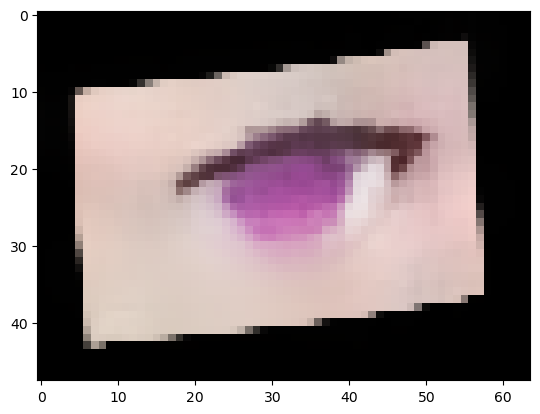

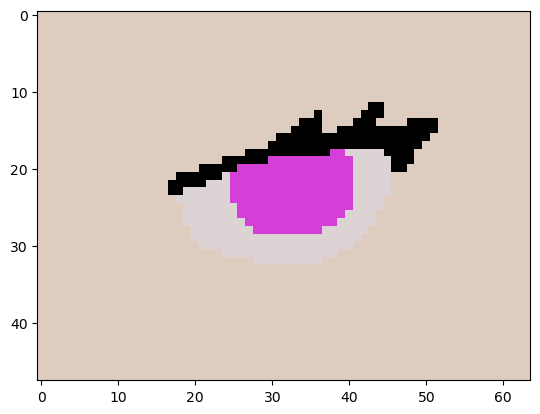

In [52]:
# 多重ウェーブレット 投影
contRate = 0.95
level = 2

name = 'rough_eye3'
variation = '_c3'

handles = detectP('data_eyes_p/'+ name +'_p.png')
handles2 = detectP('data_eyes_p2/'+ name +'_p2.png')
handles3 = detectP('data_eyes_p3/'+ name +'_p3.png')

handles = np.append(handles, handles2, axis=0)
handles = np.append(handles, handles3, axis=0)
handles = np.append(handles, np.array([[[32.5, 24.5]]]), axis=0)

tex = cv2.imread('data_eyes/'+ name + variation + '.png')
eyeMesh = mesh(10,10,64,48, tex)
eyeMesh.setHandlesOrg(handles)
eyeMesh.setHandlesDfm(handlesAvg)
eyeMesh.applyHandles()
newImg = eyeMesh.deform()

newImg = cv2.cvtColor(newImg, cv2.COLOR_BGR2YCrCb)
Y, Cr, Cb = cv2.split(newImg)

datasY, shapesY = freqDatas(Y, level)
datasCr, shapesCr = freqDatas(Cr, level)
datasCb, shapesCb = freqDatas(Cb, level)

datas = []
for i in range(level+1):
    data = np.concatenate([datasY[i], datasCr[i], datasCb[i]])
    datas.append(data)

datasCenter = []
for data, avgData in zip(datas, avgDatas):
    datasCenter.append(data - avgData)

pDatasY = []
pDatasCr = []
pDatasCb = []
for i in range(level+1):
    eigVal = dataEigsLoad[i][0]
    eigVec = dataEigsLoad[i][1]
    indices = np.argsort(eigVal)[::-1]
    eigValSum = np.sum(eigVal)

    A = []
    temp = 0
    for n in range(len(eigVal)):
        temp += eigVal[indices[n]]
        if temp / eigValSum > contRate:
            D = n
            break
    
    print(D)
    for n in range(D):
        A.append(eigVec[indices[n]])

    A = np.array(A)
    A = A.T
    P = np.linalg.inv(A.T @ A) @ A.T

    x = P @ datasCenter[i]
    p = A @ x
    
    pDataY, pDataCr, pDataCb = np.split((avgDatas[i] + p), 3)
    pDatasY.append(pDataY)
    pDatasCr.append(pDataCr)
    pDatasCb.append(pDataCb)

newImgY = recovFreqDatas(pDatasY, shapesY)
newImgCr = recovFreqDatas(pDatasCr, shapesCr)
newImgCb = recovFreqDatas(pDatasCb, shapesCb)

newImg = cv2.merge((newImgY, newImgCr, newImgCb))
newImg = np.clip(newImg, 0, 255)
newImg = newImg.astype(np.uint8)

newMesh = mesh(10,10,64,48, cv2.cvtColor(newImg, cv2.COLOR_YCrCb2BGR))
newMesh.setHandlesOrg(handlesAvg)
newMesh.setHandlesDfm(handles)
newMesh.applyHandles()

newEye = newMesh.deform()

cv2.imwrite('output/'+ name + variation + '_projected_mf_'+str(contRate)+'.png', newEye)

newEye = br_filter = cv2.bilateralFilter(newEye, 10, 100, 10)

plt.imshow(cv2.cvtColor(newEye, cv2.COLOR_BGR2RGB))
plt.show()

plt.imshow(cv2.cvtColor(tex, cv2.COLOR_BGR2RGB))
plt.show()


In [282]:
LC = 1
MC = 100
HC = 1
handC = (LC+MC+HC) * 50
is_file = os.path.isfile('saves/eigValLev2_'+str(LC)+'_'+str(MC)+'_'+str(HC)+'_'+str(handC)+'.npy')

print(is_file)
dataArr = []
print(datasArr[0][0].shape, datasArr[1][0].shape, datasArr[2][0].shape, handlesArr[0].reshape(H*1*2).shape)
for i in range(N):
    if i == 84 or i == 122 or i == 123:
        continue
    data = np.concatenate([LC*datasArr[0][i], MC*datasArr[1][i], HC*datasArr[2][i], handC*handlesArr[i].reshape(H*1*2)])
    dataArr.append(data)
    
dataArr = np.array(dataArr)

True
(855,) (2565,) (7956,) (26,)


In [283]:
avgData = np.sum(dataArr, axis=0) / (N-3)
print(len(avgData))
dataCentArr = []
for i in range(len(dataArr)):
    dataCentArr.append(dataArr[i] - avgData)
dataCentArr = np.array(dataCentArr)

11402


In [256]:
covMat = np.cov(dataCentArr.T)
dataEig = np.linalg.eig(covMat)

In [257]:
np.save('saves/eigValLev2_'+str(LC)+'_'+str(MC)+'_'+str(HC)+'_'+str(handC), dataEig[0].real)
np.save('saves/eigVecLev2_'+str(LC)+'_'+str(MC)+'_'+str(HC)+'_'+str(handC), dataEig[1].real.T)

(13, 1, 2)
33
(855,) (2565,) (7956,) (26,)


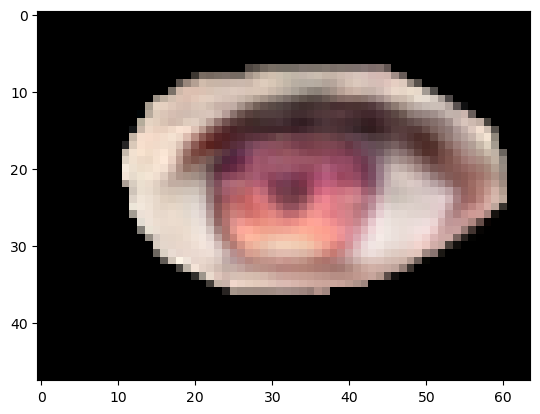

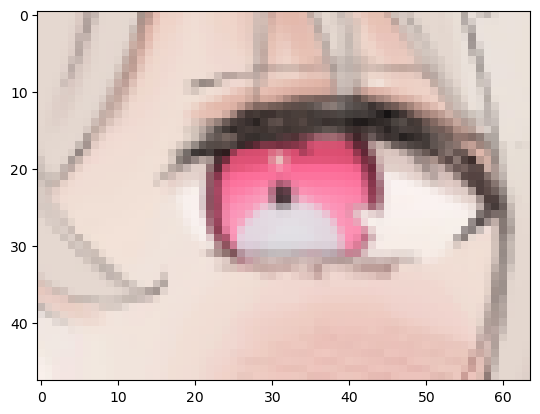

In [285]:
# 多重ウェーブレット 投影
contRate = 0.80
level = 2
H = 13 

name = 'rough_eye6'
variation = ''

handles = detectP('data_eyes_p/'+ name +'_p.png')
handles2 = detectP('data_eyes_p2/'+ name +'_p2.png')
handles3 = detectP('data_eyes_p3/'+ name +'_p3.png')

handles = np.append(handles, handles2, axis=0)
handles = np.append(handles, handles3, axis=0)
handles = np.append(handles, np.array([[[32.5, 24.5]]]), axis=0)

print(handles.shape)

handlesVec = handles.reshape(H*1*2)

tex = cv2.imread('data_eyes/'+ name + variation + '.png')
eyeMesh = mesh2(64,48, tex)
eyeMesh.setHandlesOrg(handles)
eyeMesh.setHandlesDfm(handlesAvg)
eyeMesh.applyHandles()
newImg = eyeMesh.deform()

newImg = cv2.cvtColor(newImg, cv2.COLOR_BGR2YCrCb)
Y, Cr, Cb = cv2.split(newImg)

datasY, shapesY = freqDatas(Y, level)
datasCr, shapesCr = freqDatas(Cr, level)
datasCb, shapesCb = freqDatas(Cb, level)

datas = []
for i in range(level+1):
    data = np.concatenate([datasY[i], datasCr[i], datasCb[i]])
    datas.append(data)
    
data = np.concatenate([LC*datas[0], MC*datas[1], HC*datas[2], handC*handlesVec])

dataCent = data - avgData


eigVal = np.load('saves/eigValLev2_'+str(LC)+'_'+str(MC)+'_'+str(HC)+'_'+str(handC)+'.npy')
eigVec = np.load('saves/eigVecLev2_'+str(LC)+'_'+str(MC)+'_'+str(HC)+'_'+str(handC)+'.npy')
indices = np.argsort(eigVal)[::-1]
eigValSum = np.sum(eigVal)

A = []
temp = 0
for n in range(len(eigVal)):
    temp += eigVal[indices[n]]
    if temp / eigValSum > contRate:
        D = n
        break

print(D)
for n in range(D):
    A.append(eigVec[indices[n]])

A = np.array(A)
A = A.T
P = np.linalg.inv(A.T @ A) @ A.T

x = P @ dataCent
p = A @ x

Ld, Md, Hd, hand = np.split((avgData + p), [855, 855+2565, 855+2565+7956])
Ld = Ld / LC
Md = Md / MC
Hd = Hd / HC
hand = hand / handC
print(Ld.shape, Md.shape, Hd.shape, hand.shape)

fDatas = (Ld, Md, Hd)

pDatasY = []
pDatasCr = []
pDatasCb = []
for i in range(level + 1):
    pDataY, pDataCr, pDataCb = np.split(fDatas[i], 3)
    pDatasY.append(pDataY)
    pDatasCr.append(pDataCr)
    pDatasCb.append(pDataCb)


newImgY = recovFreqDatas(pDatasY, shapesY)
newImgCr = recovFreqDatas(pDatasCr, shapesCr)
newImgCb = recovFreqDatas(pDatasCb, shapesCb)

newImg = cv2.merge((newImgY, newImgCr, newImgCb))
newImg = np.clip(newImg, 0, 255)
newImg = newImg.astype(np.uint8)

newHandles = hand.reshape(H, 1, 2)
newMesh = mesh2(64,48, cv2.cvtColor(newImg, cv2.COLOR_YCrCb2BGR))
newMesh.setHandlesOrg(handlesAvg)
newMesh.setHandlesDfm(newHandles)
newMesh.applyHandles()

newEye = newMesh.deform()

#newEye = br_filter = cv2.bilateralFilter(newEye, 10, 100, 10)

plt.imshow(cv2.cvtColor(newEye, cv2.COLOR_BGR2RGB))
plt.show()

plt.imshow(cv2.cvtColor(tex, cv2.COLOR_BGR2RGB))
plt.show()

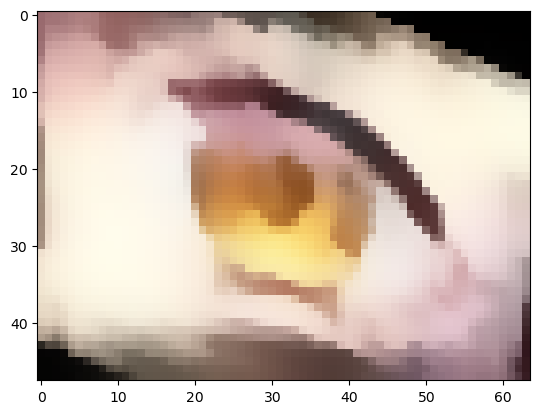

In [36]:
eyeFilt = newEye
for i in range(1):
    eyeFilt = br_filter = cv2.bilateralFilter(eyeFilt,  # 入力画像
                                    5,  # 注目画素の周辺領域（値が大きいほどぼかしが強くなる）
                                    50,  # 色空間の標準偏差
                                    15    # 距離空間の標準偏差
                                   )

plt.imshow(cv2.cvtColor(eyeFilt, cv2.COLOR_BGR2RGB)) # OpenCV は色がGBR順なのでRGB順に並べ替える
plt.show()

In [23]:
def convertLFHF(LFvec, HFvec):

    LL_B, LL_G, LL_R = np.split(LFvec, 3)

    H_B, H_G, H_R = np.split(HFvec, 3)
    LH_B, HL_B, HH_B = np.split(H_B, 3)
    LH_G, HL_G, HH_G = np.split(H_G, 3)
    LH_R, HL_R, HH_R = np.split(H_R, 3)

    LL_B, LL_G, LL_R = LL_B.reshape(26, 34), LL_G.reshape(26, 34), LL_R.reshape(26, 34)
    LH_B, LH_G, LH_R = LH_B.reshape(26, 34), LH_G.reshape(26, 34), LH_R.reshape(26, 34)
    HL_B, HL_G, HL_R = HL_B.reshape(26, 34), HL_G.reshape(26, 34), HL_R.reshape(26, 34)
    HH_B, HH_G, HH_R = HH_B.reshape(26, 34), HH_G.reshape(26, 34), HH_R.reshape(26, 34)

    coeffsB = (LL_B, (LH_B, HL_B, HH_B))
    coeffsG = (LL_G, (LH_G, HL_G, HH_G))
    coeffsR = (LL_R, (LH_R, HL_R, HH_R))

    B=pywt.idwt2(coeffsB,'bior1.3')
    G=pywt.idwt2(coeffsG,'bior1.3')
    R=pywt.idwt2(coeffsR,'bior1.3')

    recov = cv2.merge((B,G,R))
    return(recov.astype(np.uint8))

In [160]:
avgEyeVec = avgEye.reshape(48*64*3)
#avgEyeHSVVec = avgEyeHSV.reshape(48*64*3)

handlesAvgVec = handlesAvg.reshape(H*1*2) * handCoeff

avgEyeData = np.append(avgEyeVec, handlesAvgVec)
#avgEyeDataHSV = np.append(avgEyeHSVVec, handlesAvgVec)

In [162]:
# 固有値計算
eyeDatasCenter = eyeDatas - avgEyeData
covMat = np.cov(eyeDatasCenter.T)
eyeDatasEig = np.linalg.eig(covMat)

In [44]:
# 固有値計算　HSV
eyeDatasHSVCenter = eyeDatasHSV - avgEyeDataHSV
covMatHSV = np.cov(eyeDatasHSVCenter.T)
eyeDatasHSVEig = np.linalg.eig(covMatHSV)

In [20]:
# 固有値　低周波
eyeDatasLFCenter = eyeDatasLF - avgLFvec
covMatLF = np.cov(eyeDatasLFCenter.T)
eyeDatasLFEig = np.linalg.eig(covMatLF)

In [21]:
# 固有値　高周波
eyeDatasHFCenter = eyeDatasHF - avgHFvec
covMatHF = np.cov(eyeDatasHFCenter.T)
eyeDatasHFEig = np.linalg.eig(covMatHF)

In [44]:
# 固有値　ハンドル
handleDatasCenter = handleDatas - handlesAvg.reshape(5*1*2)
covMatHandle = np.cov(handleDatasCenter.T)
handleDatasEig = np.linalg.eig(covMatHandle)

ValueError: cannot reshape array of size 18 into shape (10,)

In [163]:
np.save('saves/eye_eig_val_13p_mesh_coef300', eyeDatasEig[0].real)
np.save('saves/eye_eig_vec_13p_mesh_coef300', eyeDatasEig[1].real.T)

In [24]:
np.save('saves/eye_eig_val_3_HSV', eyeDatasHSVEig[0].real)
np.save('saves/eye_eig_vec_3_HSV', eyeDatasHSVEig[1].real.T)

NameError: name 'eyeDatasHSVEig' is not defined

In [25]:
np.save('saves/eye_eig_val_LF', eyeDatasLFEig[0].real)
np.save('saves/eye_eig_vec_LF', eyeDatasLFEig[1].real.T)

In [26]:
np.save('saves/eye_eig_val_HF', eyeDatasHFEig[0].real)
np.save('saves/eye_eig_vec_HF', eyeDatasHFEig[1].real.T)

In [27]:
np.save('saves/handle_eig_val_1', handleDatasEig[0].real)
np.save('saves/handle_eig_vec_1', handleDatasEig[1].real.T)

interactive(children=(FloatSlider(value=0.55, description='contRate', max=1.0, min=0.1, step=0.01), Output()),…

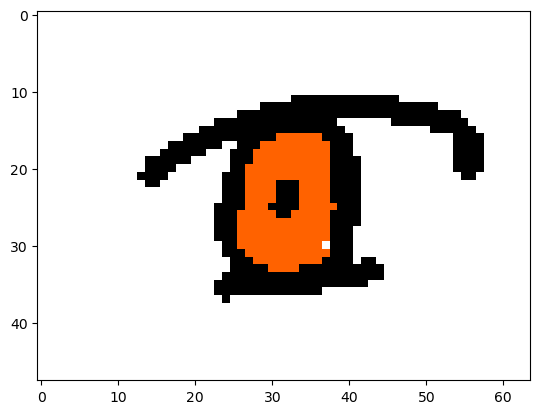

In [161]:
# 投影

eigVal = np.load('saves/eye_eig_val_13p_mesh_coef300.npy')
eigVec = np.load('saves/eye_eig_vec_13p_mesh_coef300.npy')
indices = np.argsort(eigVal)[::-1]
eigValSum = np.sum(eigVal)

name = 'rough_eye1'
variation = ''

handles = detectP('data_eyes_p/'+ name +'_p.png')
handles2 = detectP('data_eyes_p2/'+ name +'_p2.png')
handles3 = detectP('data_eyes_p3/'+ name +'_p3.png')

handles = np.append(handles, handles2, axis=0)
handles = np.append(handles, handles3, axis=0)
handles = np.append(handles, np.array([[[32.5, 24.5]]]), axis=0)

tex = cv2.imread('data_eyes/'+ name + variation + '.png')
eyeMesh = mesh2(64,48, tex)
eyeMesh.setHandlesOrg(handles)
eyeMesh.setHandlesDfm(handlesAvg)
eyeMesh.applyHandles()

newImg = eyeMesh.deform()

#plt.imshow(cv2.cvtColor(newImg, cv2.COLOR_BGR2RGB)) # OpenCV は色がGBR順なのでRGB順に並べ替える
#plt.show()

eyeVec = newImg.reshape(48*64*3)
handleVec = handles.reshape(H*1*2) * handCoeff

eyeData = np.append(eyeVec, handleVec)

eyeDataCenter = eyeData - avgEyeData

def project(contRate):
    A = []
    temp = 0
    for n in range(len(eigVal)):
        temp += eigVal[indices[n]]
        if temp / eigValSum > contRate:
            D = n
            break
    print(D)
    for n in range(D):
        A.append(eigVec[indices[n]])

    A = np.array(A)
    A = A.T
    P = np.linalg.inv(A.T @ A) @ A.T

    x = P @ eyeDataCenter
    p = A @ x

    p = avgEyeData + p
    newImg, newHandles = np.split(p, [48*64*3])



    newImg = newImg.reshape(48,64,3)
    newImg = np.clip(newImg, 0, 255)
    newImg = newImg.astype(np.uint8)

    newHandles = newHandles / handCoeff
    newHandles = newHandles.reshape(H,1,2)

    newMesh = mesh2(64,48, newImg)
    newMesh.setHandlesOrg(handlesAvg)
    newMesh.setHandlesDfm(newHandles)
    #newMesh.setHandlesDfm(handles)
    newMesh.applyHandles()

    newEye = newMesh.deform()

    #cv2.imwrite('output/'+ name + variation + '_projected_'+str(contRate)+'.png', newEye)


    plt.imshow(cv2.cvtColor(newEye, cv2.COLOR_BGR2RGB)) # OpenCV は色がGBR順なのでRGB順に並べ替える
    plt.show()
    
interact(project, contRate=(0.1, 1, 0.01))

plt.imshow(cv2.cvtColor(tex, cv2.COLOR_BGR2RGB)) # OpenCV は色がGBR順なのでRGB順に並べ替える
plt.show()

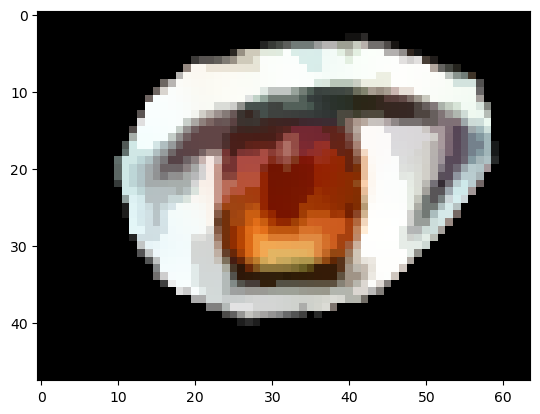

In [97]:
eyeFilt = newEye
for i in range(5):
    eyeFilt = br_filter = cv2.bilateralFilter(eyeFilt, 5, 15, 50)

plt.imshow(cv2.cvtColor(eyeFilt, cv2.COLOR_BGR2RGB)) # OpenCV は色がGBR順なのでRGB順に並べ替える
plt.show()

In [19]:
print((eigVal[indices[0]] + eigVal[indices[1]] + eigVal[indices[2]] + eigVal[indices[3]] + eigVal[indices[4]]) / eigValSum)
def PCA(x1, x2, x3, x4, x5):
    newData = avgEyeData + x1 * eigVec[indices[0]] + x2 * eigVec[indices[1]] + x3 * eigVec[indices[2]] + x4 * eigVec[indices[3]] + x5 * eigVec[indices[4]]
    
    newImg, newHandles = np.split(newData, [48*64*3])
    
    
    
    newImg = newImg.reshape(48,64,3)
    newImg = newImg.astype(np.uint8)
    
    newHandles = newHandles.reshape(5,1,2)
    
    newMesh = mesh(10,10,64,48, newImg)
    newMesh.setHandlesOrg(handlesAvg)
    newMesh.setHandlesDfm(newHandles)
    newMesh.applyHandles()
    
    newEye = newMesh.deform()
    

    plt.imshow(cv2.cvtColor(newEye, cv2.COLOR_BGR2RGB)) # OpenCV は色がGBR順なのでRGB順に並べ替える
    plt.show()
    
interact(PCA, x1=(-10000, 10000, 1000), x2=(-10000, 10000, 1000), x3=(-10000, 10000, 1000), x4=(-10000, 10000, 1000), x5=(-10000, 10000, 1000))

0.5434722002454997


interactive(children=(IntSlider(value=0, description='x1', max=10000, min=-10000, step=1000), IntSlider(value=…

<function __main__.PCA(x1, x2, x3, x4, x5)>

In [14]:
eigValLF = np.load('saves/eye_eig_val_LF.npy')
eigVecLF = np.load('saves/eye_eig_vec_LF.npy')
indicesLF = np.argsort(eigValLF)[::-1]
eigValSumLF = np.sum(eigValLF)

eigValHF = np.load('saves/eye_eig_val_HF.npy')
eigVecHF = np.load('saves/eye_eig_vec_HF.npy')
indicesHF = np.argsort(eigValHF)[::-1]
eigValSumHF = np.sum(eigValHF)

In [15]:
eigValHand = handleDatasEig[0].real
eigVecHand = handleDatasEig[1].real.T
indicesHand = np.argsort(eigValHand)[::-1]
eigValSumHand = np.sum(eigValHand)

In [17]:
def freqPCA(L1, L2, H1, H2, s1, s2):
    newLF = avgLFvec + L1*eigVecLF[indicesLF[0]] + L2*eigVecLF[indicesLF[1]]
    newHF = avgHFvec + H1*eigVecHF[indicesHF[0]] + H2*eigVecHF[indicesHF[1]]
    newHandles = handlesAvg.reshape(5*1*2) + s1*eigVecHand[indicesHand[0]] + s2*eigVecHand[indicesHand[1]]
    newHandles = newHandles.reshape(5,1,2)
    
    #print(newHandles, handlesAvg)
    
    newImg = convertLFHF(newLF, newHF)
    
    newMesh = mesh(10,10,64,48, newImg)
    newMesh.setHandlesOrg(handlesAvg)
    newMesh.setHandlesDfm(newHandles)
    newMesh.applyHandles()
    
    newEye = newMesh.deform()
    
    plt.imshow(cv2.cvtColor(newEye, cv2.COLOR_BGR2RGB)) # OpenCV は色がGBR順なのでRGB順に並べ替える
    plt.show()
    
rangeL1 = 2 * math.sqrt(eigValLF[indicesLF[0]])
rangeL2 = 2 * math.sqrt(eigValLF[indicesLF[1]])
rangeH1 = 2 * math.sqrt(eigValHF[indicesHF[0]])
rangeH2 = 2 * math.sqrt(eigValHF[indicesHF[1]])
ranges1 = 2 * math.sqrt(eigValHand[indicesHand[0]])
ranges2 = 2 * math.sqrt(eigValHand[indicesHand[1]])
interact(freqPCA, L1=((-1)*rangeL1, rangeL1, rangeL1/10), L2=((-1)*rangeL2, rangeL2, rangeL2/10), 
         H1=((-1)*rangeH1, rangeH1, rangeH1/10), H2=((-1)*rangeH2, rangeH2, rangeH2/10), 
         s1=((-1)*ranges1, ranges1, ranges1/10), s2=((-1)*ranges2, ranges2, ranges2/10), )

interactive(children=(FloatSlider(value=0.0, description='L1', max=9684.194014411602, min=-9684.194014411602, …

<function __main__.freqPCA(L1, L2, H1, H2, s1, s2)>

8323.389675443383 4401.920419832719


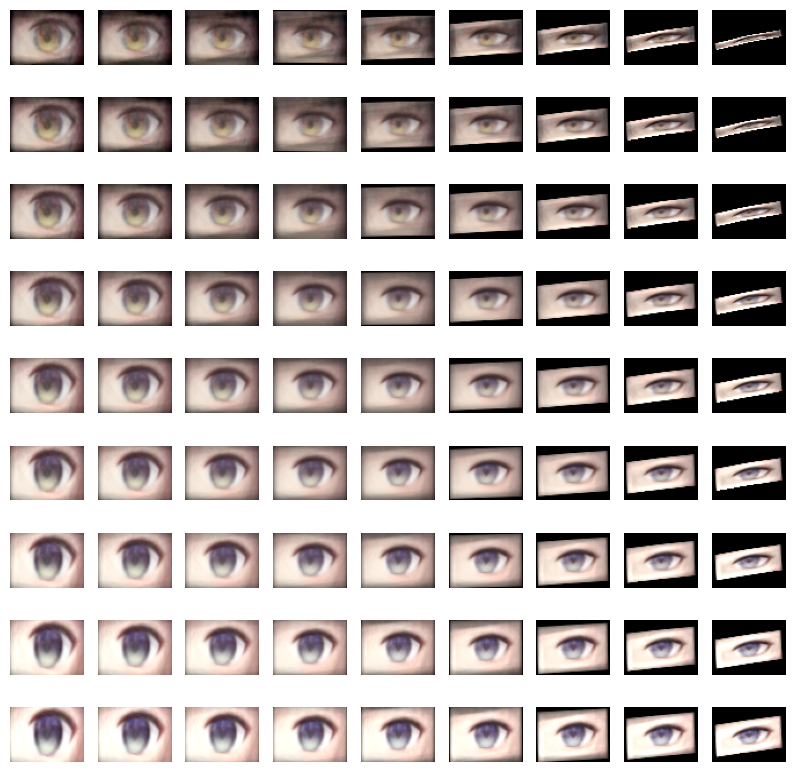

In [30]:
range1 = 2 * math.sqrt(eigVal[indices[0]])
range2 = 2 * math.sqrt(eigVal[indices[1]])

print(range1, range2)

fig = plt.figure(figsize = [10, 10])
for i in range(9):
    for j in range(9):
        
        newData = avgEyeData + (range1/4*j - range1) * eigVec[indices[0]] + (range2/4*i - range2) * eigVec[indices[1]]
    
        newImg, newHandles = np.split(newData, [48*64*3])


        newImg = newImg.reshape(48,64,3)
        newImg = np.clip(newImg, 0, 255)
        newImg = newImg.astype(np.uint8)

        newHandles = newHandles.reshape(5,1,2)

        newMesh = mesh(10,10,64,48, newImg)
        newMesh.setHandlesOrg(handlesAvg)
        newMesh.setHandlesDfm(newHandles)
        newMesh.applyHandles()

        newEye = newMesh.deform()
        
        
        ax = fig.add_subplot(9, 9, i*9+j+1)
        ax.imshow(cv2.cvtColor(newEye, cv2.COLOR_BGR2RGB))
        ax.axis("off")

plt.show()

(48, 64)


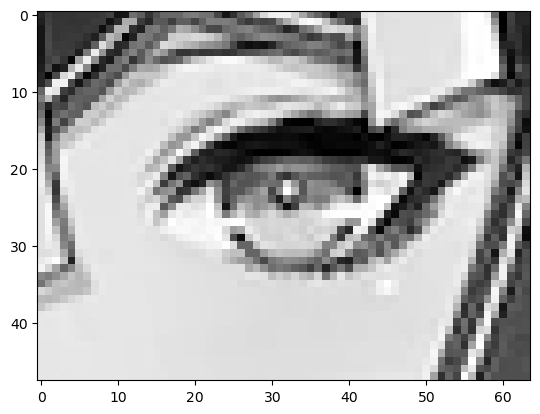

In [56]:
uma = cv2.imread('data_eyes/020.png')

gray = cv2.cvtColor(uma, cv2.COLOR_BGR2GRAY)

print(gray.shape)

plt.imshow(cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)) # OpenCV は色がGBR順なのでRGB順に並べ替える
plt.show()

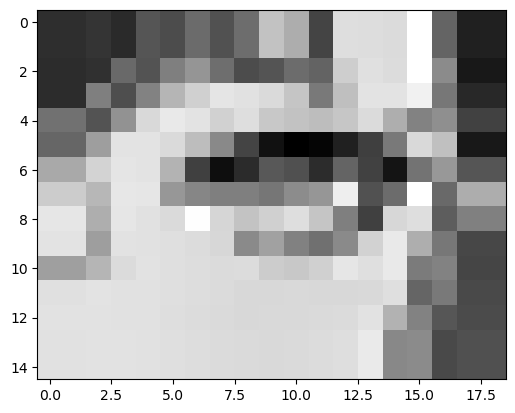

In [59]:
coeffs = pywt.wavedec2(gray, 'bior1.3', level=2)

plt.imshow(coeffs[0], interpolation="nearest", cmap='gray')
plt.show()

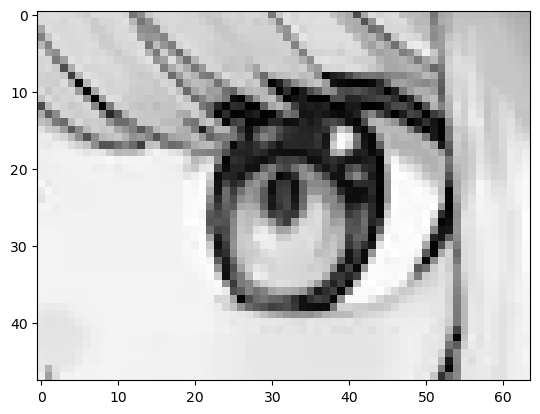

In [40]:
recovm2=pywt.waverec2(coeffs,'bior1.3')

b = recovm2.astype(np.uint8)

plt.imshow(cv2.cvtColor(b, cv2.COLOR_GRAY2RGB)) # OpenCV は色がGBR順なのでRGB順に並べ替える
plt.show()